In [1]:
%matplotlib inline
import datetime as dt
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
#sys.path.append("C:\\Users\\konar\\IdeaProjects\\lobSimulations")#
sys.path.append("/home/konajain/code/lobSimulations")
from src.data.dataLoader import dataLoader #, fit, inference, simulate
import numpy as np
import time
import pickle
import statsmodels.api as sm


In [2]:
stocks = ['SIRI','BAC', 'INTC','CSCO','ORCL','MSFT','AAPL','ABBV', 'PM','IBM','TSLA','CHTR','AMZN', 'GOOG', 'BKNG']

# IS intensity params

In [7]:
params = {}
for ric in stocks:
    inspreadInt = []
    counts = []
    for d in pd.date_range(dt.date(2019,1,2), dt.date(2019,3,31)):
            l = dataLoader(ric, d, d, nlevels = 2, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
            data = l.load()
            if len(data):
                # ask price new < ask price prev or bid price new > bid price prev and event type = LO
                for i in range(len(data)):
                    df = data[i]
                    df['BidDiff'] = df['Bid Price 1'].diff()
                    df['AskDiff'] = df['Ask Price 1'].diff()
                    df = df.iloc[1:]
                    df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
                    df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
                    df['seqNo'] = np.arange(len(df))
                    data[i] = df
                # df_inspread_bid = df_inspread.loc[df_inspread.TradeDirection == 1]
        
                for df_inspread in data:
                    df_inspread_bid = df_inspread.loc[df_inspread.TradeDirection == 1]
                    df_inspread_bid = df_inspread_bid.set_index([df_inspread_bid.apply(lambda x : dt.datetime.strptime(x['Date'], "%Y-%m-%d")+dt.timedelta(seconds=x['Time']), axis = 1 ), 'seqNo'])
                    tau = 1e-3
                    s = df_inspread_bid.sort_index(ascending=False).reset_index().set_index('level_0').rolling(window = dt.timedelta(seconds=tau))['inspread'].sum()
                    s=s.to_frame()
                    s['seqNo'] = df_inspread_bid.sort_index(ascending=False).reset_index().set_index('level_0')['seqNo']
                    s = s.reset_index().set_index(['level_0','seqNo'])
                    df_inspread_bid['Count0.01sec'] = s
                    df_inspread_bid['prev spread ticks'] = (df_inspread_bid['prev spread']*100).apply(np.round).astype(int)
                    inspreadInt.append(df_inspread_bid.groupby("prev spread ticks")['Count0.01sec'].apply(np.average))
                    counts.append(df_inspread_bid.groupby("prev spread ticks")['Count0.01sec'].count())
                    df_inspread_ask = df_inspread.loc[df_inspread.TradeDirection == -1]
                    df_inspread_ask = df_inspread_ask.set_index([df_inspread_ask.apply(lambda x : dt.datetime.strptime(x['Date'], "%Y-%m-%d")+dt.timedelta(seconds=x['Time']), axis = 1 ), 'seqNo'])
                    tau = 1e-3
                    s = df_inspread_ask.sort_index(ascending=False).reset_index().set_index('level_0').rolling(window = dt.timedelta(seconds=tau))['inspread'].sum()
                    s=s.to_frame()
                    s['seqNo'] = df_inspread_ask.sort_index(ascending=False).reset_index().set_index('level_0')['seqNo']
                    s = s.reset_index().set_index(['level_0','seqNo'])
                    df_inspread_ask['Count0.01sec'] = s
                    df_inspread_ask['prev spread ticks'] = (df_inspread_ask['prev spread']*100).apply(np.round).astype(int)
                    inspreadInt.append(df_inspread_ask.groupby("prev spread ticks")['Count0.01sec'].apply(np.average))
                    counts.append(df_inspread_ask.groupby("prev spread ticks")['Count0.01sec'].count())

    df = pd.concat(inspreadInt)
    
    c = pd.concat(counts)
    
    df.to_csv("/SAN/fca/Konark_PhD_Experiments/smallTick"+ric+"_inspreadInt.csv")
    c.to_csv("/SAN/fca/Konark_PhD_Experiments/smallTick"+ric+"_inspreadCount.csv")
    #df = df.loc[df.index < 10]
    df = df.reset_index().groupby("prev spread ticks")['Count0.01sec'].apply(np.average).reset_index()
    X = np.log(df['prev spread ticks'].values)
    y = df['Count0.01sec'].apply(lambda x: np.log(x) if x > 0 else -4).values
    X = sm.add_constant(X)
    
    #c = c.loc[c.index > 1]
    #c = c.loc[c.index < 10]
    weights = c
    mod_wls = sm.OLS(y,X) #sm.WLS(y, X, weights=weights)
    res_wls = mod_wls.fit()
    print(res_wls.summary())
    params[ric] = res_wls.params

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-02_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-03_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-09_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-10_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-16_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-17_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-23_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-24_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-30_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-01-31_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-02-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-05_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-03-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     7.228
Date:                Wed, 02 Oct 2024   Prob (F-statistic):             0.0276
Time:                        13:43:39   Log-Likelihood:                -10.988
No. Observations:                  10   AIC:                             25.98
Df Residuals:                       8   BIC:                             26.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9543      0.609     -3.210      0.0

/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-03_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-10_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-16_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-17_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-23_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-24_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-30_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-01-31_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-02-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BAC_2019-03-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     3.890
Date:                Wed, 02 Oct 2024   Prob (F-statistic):             0.0633
Time:                        14:51:21   Log-Likelihood:                -22.260
No. Observations:                  21   AIC:                             48.52
Df Residuals:                      19   BIC:                             50.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5296      0.463     -3.307      0.0

/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-03_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-16_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-17_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-23_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-24_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-30_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-31_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-02-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-03-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     11.57
Date:                Wed, 02 Oct 2024   Prob (F-statistic):            0.00169
Time:                        16:16:43   Log-Likelihood:                -36.932
No. Observations:                  37   AIC:                             77.86
Df Residuals:                      35   BIC:                             81.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8057      0.345     -2.336      0.0

/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-03_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-10_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-16_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-17_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-23_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-24_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-30_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-31_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     37.21
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           6.38e-07
Time:                        17:22:07   Log-Likelihood:                -26.370
No. Observations:                  36   AIC:                             56.74
Df Residuals:                      34   BIC:                             59.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2194      0.280     -4.355      0.0

/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-03_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-16_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-17_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-23_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-24_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-30_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-01-31_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-02-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ORCL_2019-03-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     4.823
Date:                Wed, 02 Oct 2024   Prob (F-statistic):             0.0314
Time:                        18:13:29   Log-Likelihood:                -94.724
No. Observations:                  72   AIC:                             193.4
Df Residuals:                      70   BIC:                             198.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1067      0.396     -0.270      0.7

/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-03_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-10_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-16_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-17_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-23_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-24_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-30_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-31_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-02-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-03-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8690
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.354
Time:                        20:04:12   Log-Likelihood:                -161.43
No. Observations:                  82   AIC:                             326.9
Df Residuals:                      80   BIC:                             331.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1469      0.730      0.201      0.8

/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-03_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-16_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-17_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-23_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-24_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-30_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-31_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-05_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-02-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-03-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     334.9
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           9.18e-28
Time:                        21:25:30   Log-Likelihood:                -15.437
No. Observations:                  69   AIC:                             34.87
Df Residuals:                      67   BIC:                             39.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9184      0.139    -13.790      0.0

/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-03_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-16_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-17_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-23_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-24_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-30_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-01-31_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-05_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-02-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-05_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ABBV_2019-03-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1482
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.701
Time:                        21:44:20   Log-Likelihood:                -192.18
No. Observations:                 150   AIC:                             388.4
Df Residuals:                     148   BIC:                             394.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5816      0.313     -1.856      0.0

/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-03_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-16_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-17_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-23_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-24_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-30_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-01-31_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-05_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-02-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-05_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/PM_2019-03-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2178
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.641
Time:                        22:01:45   Log-Likelihood:                -195.84
No. Observations:                 158   AIC:                             395.7
Df Residuals:                     156   BIC:                             401.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2162      0.283     -4.303      0.0

/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-03_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-16_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-17_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-23_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-24_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-30_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-01-31_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-02-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-05_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/IBM_2019-03-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8829
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.349
Time:                        22:23:08   Log-Likelihood:                -175.63
No. Observations:                 140   AIC:                             355.3
Df Residuals:                     138   BIC:                             361.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6696      0.308     -2.173      0.0

/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-03_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-09_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-16_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-17_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-23_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-24_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-30_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-01-31_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-05_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-02-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/TSLA_2019-03-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.937
Date:                Wed, 02 Oct 2024   Prob (F-statistic):             0.0883
Time:                        22:48:09   Log-Likelihood:                -213.42
No. Observations:                 177   AIC:                             430.8
Df Residuals:                     175   BIC:                             437.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3105      0.276     -4.749      0.0

/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-03_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-09_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-16_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-17_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-23_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-24_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-30_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-31_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.588
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.108
Time:                        22:54:58   Log-Likelihood:                -830.14
No. Observations:                 605   AIC:                             1664.
Df Residuals:                     603   BIC:                             1673.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4224      0.201     -7.069      0.0

/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-03_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-16_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-17_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-23_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-24_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-30_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-01-31_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-05_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-02-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-05_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-07_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-12_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AMZN_2019-03-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     61.85
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           3.53e-14
Time:                        23:32:13   Log-Likelihood:                -383.04
No. Observations:                 400   AIC:                             770.1
Df Residuals:                     398   BIC:                             778.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1207      0.164    -12.926      0.0

/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-03_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-16_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-17_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-23_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-24_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-30_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-01-31_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-01_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-05_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-08_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-02-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-04_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-06_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-11_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-18_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-19_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-21_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-22_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-25_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-26_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-27_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-28_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/GOOG_2019-03-29_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     102.4
Date:                Thu, 03 Oct 2024   Prob (F-statistic):           1.76e-21
Time:                        00:28:23   Log-Likelihood:                -373.02
No. Observations:                 383   AIC:                             750.0
Df Residuals:                     381   BIC:                             757.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8326      0.170    -16.651      0.0

/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-03_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-10_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-16_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-17_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-23_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-24_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-30_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-01-31_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-13_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-02-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-14_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev spread'] = df.BidDiff - df.AskDiff + df['Ask Price 1'] - df['Bid Price 1']
/tmp/ipykernel_60311/3783292936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/BKNG_2019-03-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
/tmp/ipykernel_60311/3783292936.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspread'] = ((df.Type == 1)&((df['BidDiff'] > 0)|(df['AskDiff'] < 0))).astype(int)
/tmp/ipykernel_60311/3783292936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.816
Date:                Thu, 03 Oct 2024   Prob (F-statistic):             0.0935
Time:                        00:31:29   Log-Likelihood:                -1862.3
No. Observations:                1401   AIC:                             3729.
Df Residuals:                    1399   BIC:                             3739.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8244      0.146     -5.650      0.0

In [8]:
params

{'SIRI': array([-1.95433258,  0.97651622]),
 'BAC': array([-1.52962275,  0.39608514]),
 'INTC': array([-0.80572216,  0.40146344]),
 'CSCO': array([-1.21936846,  0.60898961]),
 'ORCL': array([-0.10671632, -0.24896093]),
 'MSFT': array([ 0.14688361, -0.186966  ]),
 'AAPL': array([-1.91844422,  0.74828017]),
 'ABBV': array([-0.58155933, -0.02906079]),
 'PM': array([-1.21623421,  0.03092083]),
 'IBM': array([-0.66955777,  0.07063027]),
 'TSLA': array([-1.31048569,  0.10977298]),
 'CHTR': array([-1.42235455,  0.05766901]),
 'AMZN': array([-2.12071718,  0.25253372]),
 'GOOG': array([-2.83256435,  0.34024865]),
 'BKNG': array([-0.82437575, -0.03820167])}

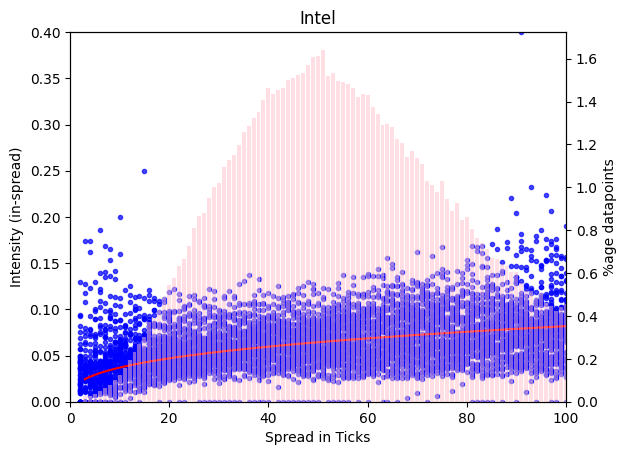

In [11]:
fig, ax1 = plt.subplots()
x = weights.index.unique()
ax2 = ax1.twinx()

ax2.bar(x+1, 100*weights.reset_index().groupby('prev spread ticks').mean().values.flatten(), color = 'pink', alpha = 0.5)

ax1.plot(df, 'b.', alpha = 0.7)
ax1.set_title("Intel")
y = [np.exp(-4.0927)*i**0.3451 for i in (x+1)]
ax1.plot(x+1, y, 'r')

ax1.set_xlabel('Spread in Ticks')
ax1.set_ylabel('Intensity (in-spread)')
ax1.set_ylim(0,.4)
ax2.set_ylabel('%age datapoints')
plt.xlim(0,100)
plt.show()

# Example

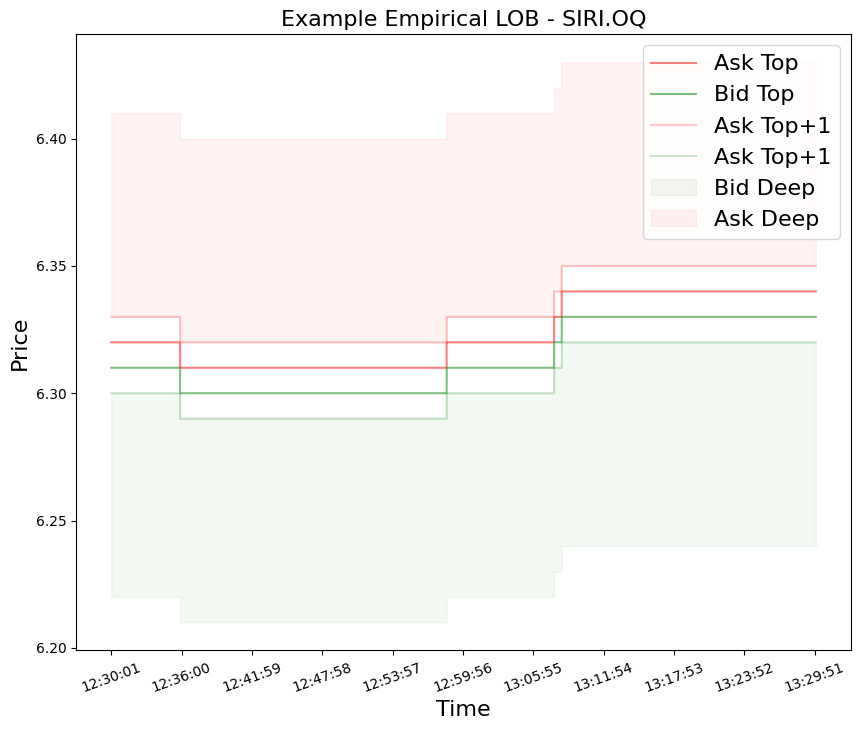

In [5]:
col = ['Ask Price ', 'Ask Size ', 'Bid Price ', 'Bid Size ']
if True:
            theNames = []
            cols = []
            for i in range(1, 11):
                for j in col:
                    cols.append(str(j)+str(i))
                    theNames.append(str(j) + str(i))
data = pd.read_csv("/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-10-14_34200000_57600000_orderbook_10.csv", names=theNames)
theMessageBook = pd.read_csv("/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/SIRI_2019-10-14_34200000_57600000_message_10.csv", names=['Time', 'Type', 'OrderID', 'Size', 'Price', 'TradeDirection', 'tmp'])
data = pd.concat([theMessageBook , data], axis = 1)
data_s = data.loc[(data.Time < 34200+3*3600 + 3600)&(data.Time > 34200+3*3600)]
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(data_s.Time, data_s["Ask Price 1"].values/1e4, color = "red", alpha =0.5, label = 'Ask Top')
ax.plot(data_s.Time, data_s["Bid Price 1"].values/1e4, color = "green", alpha =0.5, label = 'Bid Top')
ax.plot(data_s.Time, data_s["Ask Price 2"].values/1e4, color = "red", alpha = 0.2, label = 'Ask Top+1')
ax.plot(data_s.Time, data_s["Bid Price 2"].values/1e4, color = "green", alpha = 0.2, label = 'Ask Top+1')
ax.fill_between(data_s.Time, data_s["Bid Price 2"].values/1e4, data_s["Bid Price 10"].values/1e4, color="g", alpha = 0.05 , label = 'Bid Deep')
ax.fill_between(data_s.Time, data_s["Ask Price 2"].values/1e4, data_s["Ask Price 10"].values/1e4, color="r", alpha = 0.05, label = 'Ask Deep')
t = data_s.Time.values
count = int((max(t) - min(t))/10)
ax.ticklabel_format(useOffset=False)
ax.set_xticks(ticks = np.arange(min(t), max(t), count), labels = [time.strftime('%H:%M:%S', time.gmtime(x)) for x in np.arange(min(t), max(t), count)], rotation = 20)
# ax.set_xlim(min(t)+3000, min(t)+4000)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Price', fontsize=16)
ax.legend( fontsize=16)
ax.set_title('Example Empirical LOB - SIRI.OQ', fontsize=16)
plt.savefig('/SAN/fca/Konark_PhD_Experiments/simulated/smallTick/exampleRealLarge.png')
plt.show()

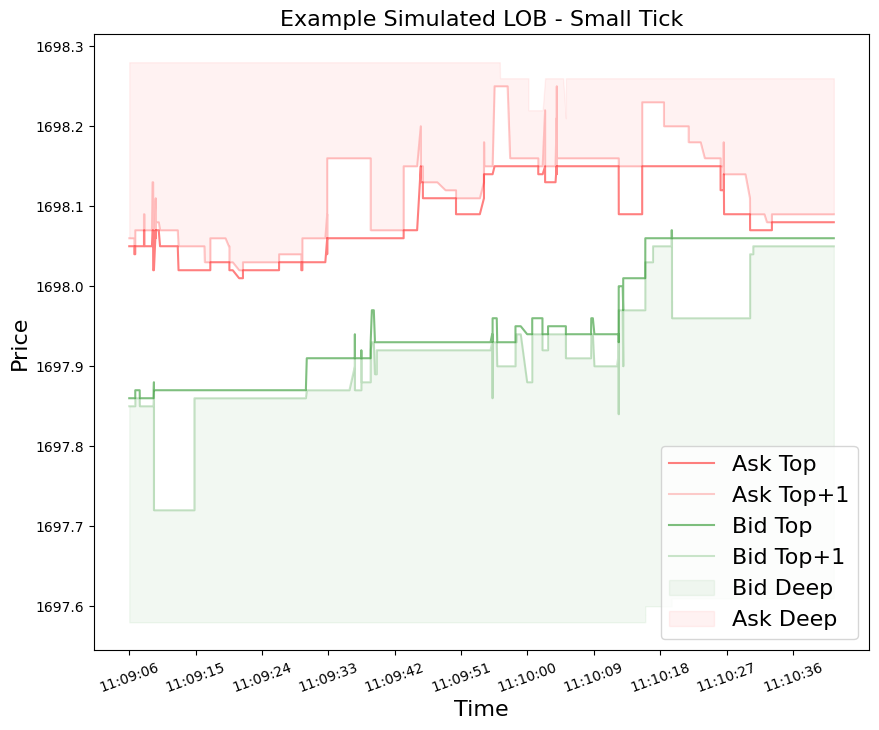

In [49]:

path = '/SAN/fca/Konark_PhD_Experiments/simulated/smallTick/ergStudy/demo_erg_Mmed_20'
path = '/SAN/fca/Konark_PhD_Experiments/simulated/smallTick/ergStudy/demo_erg_eta_0.5'

with open(path, 'rb') as f:
    T, lob = pickle.load(f)
a = np.random.randint(0,len(lob))
b = a + 1000
ask_t = []
bid_t = []
ask_d = []
bid_d= []
ask_m_D = []
bid_m_D = []
spread = []
for r in lob[a:b]:
    ask_t.append(r['Ask_touch'][0])
    bid_t.append(r['Bid_touch'][0])
    ask_d.append(r['Ask_deep'][0])
    bid_d.append(r['Bid_deep'][0])
    bid_m_D.append(r['Bid_deep'][0] - 0.01*r['Bid_m_D'])
    ask_m_D.append(r['Ask_deep'][0] + 0.01*r['Ask_m_D'])
    spread.append(100*(r['Ask_touch'][0] - r['Bid_touch'][0]))
t = np.array(T[a:b])[:,1]
t = t.astype(float) + 9.5*3600

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(t, ask_t, color = "r", alpha =0.5, label = 'Ask Top')
ax.plot(t, ask_d, color="r", alpha = 0.2, label = 'Ask Top+1')
# ax.plot(t, ask_m_D, color="purple", alpha = 0.2, label = 'Ask Deepm')
ax.plot(t, bid_t, color="g", alpha =0.5, label = 'Bid Top')
ax.plot(t, bid_d, color="g", alpha = 0.2, label = 'Bid Top+1')
# ax.plot(t, bid_m_D, color="cyan", alpha = 0.2, label = 'Bid Deep')
ax.fill_between(t, bid_d, bid_m_D, color="g", alpha = 0.05 , label = 'Bid Deep')
ax.fill_between(t, ask_d, ask_m_D, color="r", alpha = 0.05, label = 'Ask Deep')
count = int((max(t) - min(t))/10)
ax.ticklabel_format(useOffset=False)
ax.set_xticks(ticks = np.arange(min(t), max(t), count), labels = [time.strftime('%H:%M:%S', time.gmtime(x)) for x in np.arange(min(t), max(t), count)], rotation = 20)
# ax.set_xlim(min(t)+3000, min(t)+4000)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Price', fontsize=16)
ax.legend( fontsize=16)
ax.set_title('Example Simulated LOB - Small Tick', fontsize=16)
plt.savefig('/SAN/fca/Konark_PhD_Experiments/simulated/smallTick/example.png')
plt.show()

# Rough

In [9]:
T, lob , _ = simulate_smalltick.simulate_smallTick(23400, "D:\PhD\\results - small tick\AMZN.OQ_ParamsInferredWCutoffEyeMu_Symm_2019-01-02_2019-12-31_CLSLogLin_10","D:\PhD\\results - small tick\\AMZN.OQ_Params_2019-01-02_2019-12-30_dictTOD_symmetric" , beta = 0.6, avgSpread = .95, spread0 = 110, price0 = 1700, M_med = 50, verbose= False)

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\konar\AppData\Local\Temp\ipykernel_36236\3251714528.py:1: SyntaxWarning: invalid escape sequence '\P'
  T, lob , _ = simulate_smalltick.simulate_smallTick(23400, "D:\PhD\\results - small tick\AMZN.OQ_ParamsInferredWCutoffEyeMu_Symm_2019-01-02_2019-12-31_CLSLogLin_10","D:\PhD\\results - small tick\\AMZN.OQ_Params_2019-01-02_2019-12-30_dictTOD_symmetric" , beta = 0.6, avgSpread = .95, spread0 = 110, price0 = 1700, M_med = 50, verbose= False)
C:\Users\konar\AppData\Local\Temp\ipykernel_36236\3251714528.py:1: SyntaxWarning: invalid escape sequence '\P'
  T, lob , _ = simulate_smalltick.simulate_smallTick(23400, "D:\PhD\\results - small tick\AMZN.OQ_ParamsInferredWCutoffEyeMu_Symm_2019-01-02_2019-12-31_CLSLogLin_10","D:\PhD\\results - small tick\\AMZN.OQ_Params_2019-01-02_2019-12-30_di

initial spread:  1.099999999999909 



In [10]:
lob[0]

{'mid': 1700,
 'Ask_touch': (np.float64(1700.55), np.int64(37)),
 'Bid_touch': (np.float64(1699.45), np.int64(427)),
 'Ask_m_T': np.int64(17),
 'Ask_m_D': np.int64(2),
 'Bid_m_T': np.int64(2),
 'Bid_m_D': np.int64(2),
 'Ask_deep': (np.float64(1700.72), np.int64(178)),
 'Bid_deep': (np.float64(1699.43), np.int64(84))}

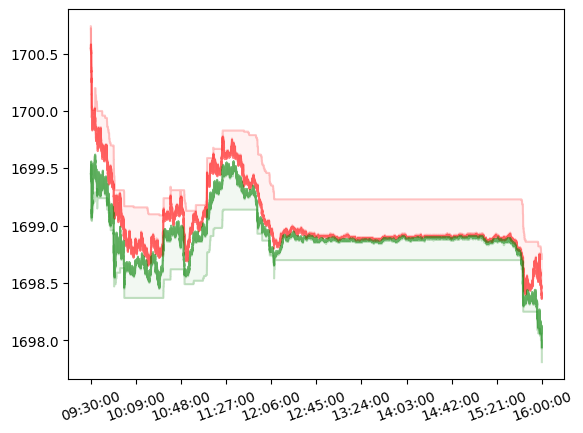

In [11]:
ask_t = []
bid_t = []
ask_d = []
bid_d= []
ask_m_D = []
bid_m_D = []
spread = []
for r in lob:
    ask_t.append(r['Ask_touch'][0])
    bid_t.append(r['Bid_touch'][0])
    ask_d.append(r['Ask_deep'][0])
    bid_d.append(r['Bid_deep'][0])
    bid_m_D.append(r['Bid_deep'][0] - 0.01*r['Bid_m_D'])
    ask_m_D.append(r['Ask_deep'][0] + 0.01*r['Ask_m_D'])
    spread.append(100*(r['Ask_touch'][0] - r['Bid_touch'][0]))
t = np.append([0], np.array(T[1:])[:,1])
t = t.astype(float) + 9.5*3600

fig, ax = plt.subplots()
ax.plot(t, ask_t, color = "r", alpha =0.5)
ax.plot(t, ask_d, color="r", alpha = 0.2)
ax.plot(t, ask_m_D, color="r", alpha = 0.2)
ax.plot(t, bid_t, color="g", alpha =0.5)
ax.plot(t, bid_d, color="g", alpha = 0.2)
ax.plot(t, bid_m_D, color="g", alpha = 0.2)
ax.fill_between(t, bid_d, bid_m_D, color="g", alpha = 0.05)
ax.fill_between(t, ask_d, ask_m_D, color="r", alpha = 0.05)
count = int((max(t) - min(t))/10)
ax.ticklabel_format(useOffset=False)
ax.set_xticks(ticks = np.arange(min(t), max(t), count), labels = [time.strftime('%H:%M:%S', time.gmtime(x)) for x in np.arange(min(t), max(t), count)], rotation = 20)
plt.show()

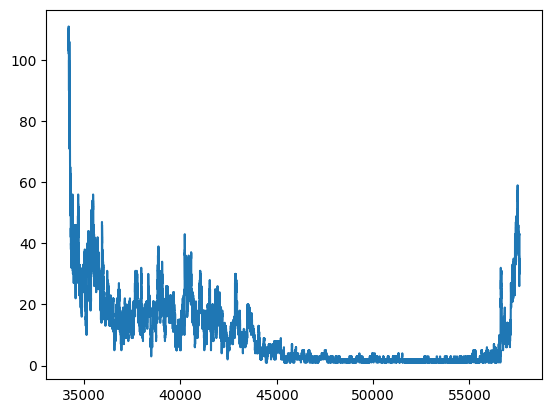

In [12]:
plt.plot(t, spread)

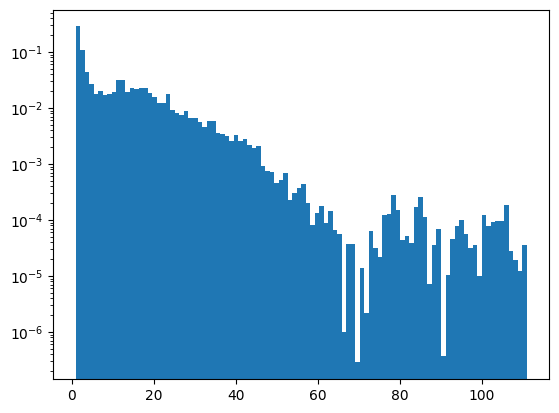

In [22]:
plt.hist(spread[1:], weights = np.diff(t), density=True,bins=100)
plt.yscale('log')
# plt.xscale('log')

In [14]:
len(spread)

245607

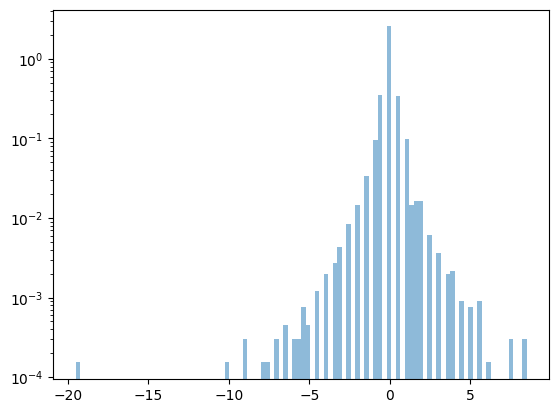

In [24]:
mid = (np.array(ask_t) + np.array(bid_t))/2
tau = 1
max_t = np.round(max(np.array(t) - 34200), decimals=0)
sample_x = np.linspace(0, max_t, int(max_t/tau))
idxs = np.searchsorted(np.array(t) - 34200, sample_x)[1:-1] - 1
sample_y = mid[idxs]
rets = np.diff(sample_y)# np.exp(np.diff(np.log(sample_y))) - 1
plt.hist(rets*100, bins = 100, alpha = 0.5, density = True)
plt.yscale('log')
plt.show()

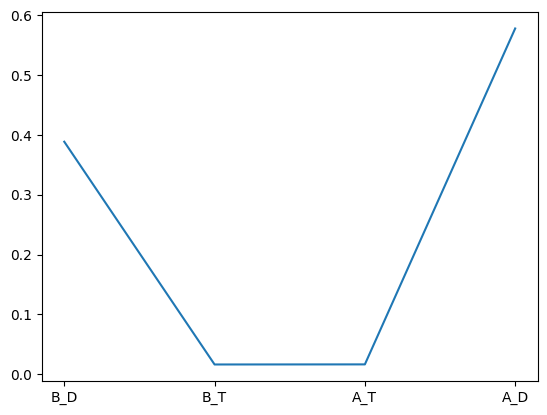

In [43]:
q_ask_t = []
q_bid_t = []
q_ask_d = []
q_bid_d= []
for r in lob:
    q_ask_t.append(r['Ask_touch'][1])
    q_bid_t.append(r['Bid_touch'][1])
    q_ask_d.append(r['Ask_deep'][1])
    q_bid_d.append(r['Bid_deep'][1])
Q= np.array([q_bid_d, q_bid_t, q_ask_t, q_ask_d])
Q = np.multiply(Q,(1./Q.sum(axis=0)))
Q_shape = Q.sum(axis=1)
Q_shape =Q_shape/Q_shape.sum()
plt.plot(['B_D', 'B_T', 'A_T', 'A_D'],Q_shape)


In [44]:
# Large tick:

In [53]:
T, lob , _ = simulate_smalltick.simulate_smallTick(100, "D:\PhD\\results - small tick\AMZN.OQ_ParamsInferredWCutoffEyeMu_Symm_2019-01-02_2019-12-31_CLSLogLin_10","D:\PhD\\results - small tick\\AMZN.OQ_Params_2019-01-02_2019-12-30_dictTOD_symmetric" , beta = 0.6, avgSpread = .95, spread0 = 4, price0 = 45, M_med = 50, verbose= False)

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\konar\AppData\Local\Temp\ipykernel_36236\3615856382.py:1: SyntaxWarning: invalid escape sequence '\P'
  T, lob , _ = simulate_smalltick.simulate_smallTick(100, "D:\PhD\\results - small tick\AMZN.OQ_ParamsInferredWCutoffEyeMu_Symm_2019-01-02_2019-12-31_CLSLogLin_10","D:\PhD\\results - small tick\\AMZN.OQ_Params_2019-01-02_2019-12-30_dictTOD_symmetric" , beta = 0.6, avgSpread = .95, spread0 = 4, price0 = 45, M_med = 50, verbose= False)
C:\Users\konar\AppData\Local\Temp\ipykernel_36236\3615856382.py:1: SyntaxWarning: invalid escape sequence '\P'
  T, lob , _ = simulate_smalltick.simulate_smallTick(100, "D:\PhD\\results - small tick\AMZN.OQ_ParamsInferredWCutoffEyeMu_Symm_2019-01-02_2019-12-31_CLSLogLin_10","D:\PhD\\results - small tick\\AMZN.OQ_Params_2019-01-02_2019-12-30_dictTOD_sy

initial spread:  0.04000000000000625 



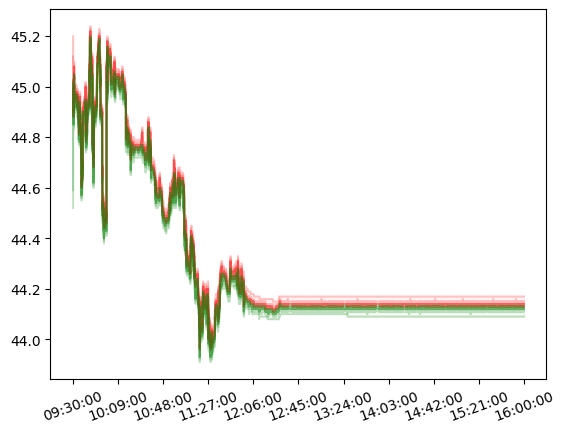

In [48]:
ask_t = []
bid_t = []
ask_d = []
bid_d= []
ask_m_D = []
bid_m_D = []
spread = []
for r in lob:
    ask_t.append(r['Ask_touch'][0])
    bid_t.append(r['Bid_touch'][0])
    ask_d.append(r['Ask_deep'][0])
    bid_d.append(r['Bid_deep'][0])
    bid_m_D.append(r['Bid_deep'][0] - 0.01*r['Bid_m_D'])
    ask_m_D.append(r['Ask_deep'][0] + 0.01*r['Ask_m_D'])
    spread.append(100*(r['Ask_touch'][0] - r['Bid_touch'][0]))
t = np.append([0], np.array(T[1:])[:,1])
t = t.astype(float) + 9.5*3600

fig, ax = plt.subplots()
ax.plot(t, ask_t, color = "r", alpha =0.5)
ax.plot(t, ask_d, color="r", alpha = 0.2)
ax.plot(t, ask_m_D, color="r", alpha = 0.2)
ax.plot(t, bid_t, color="g", alpha =0.5)
ax.plot(t, bid_d, color="g", alpha = 0.2)
ax.plot(t, bid_m_D, color="g", alpha = 0.2)
ax.fill_between(t, bid_d, bid_m_D, color="g", alpha = 0.05)
ax.fill_between(t, ask_d, ask_m_D, color="r", alpha = 0.05)
count = int((max(t) - min(t))/10)
ax.ticklabel_format(useOffset=False)
ax.set_xticks(ticks = np.arange(min(t), max(t), count), labels = [time.strftime('%H:%M:%S', time.gmtime(x)) for x in np.arange(min(t), max(t), count)], rotation = 20)
plt.show()

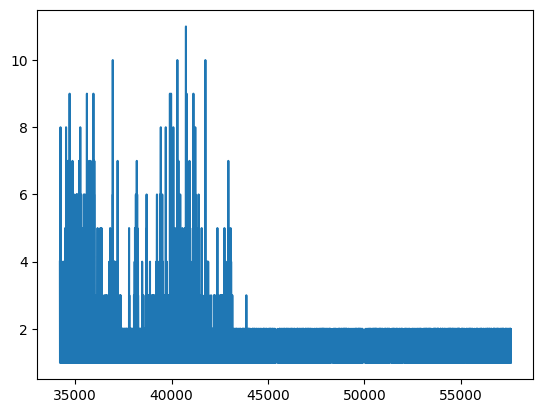

In [52]:
plt.plot(t, spread)

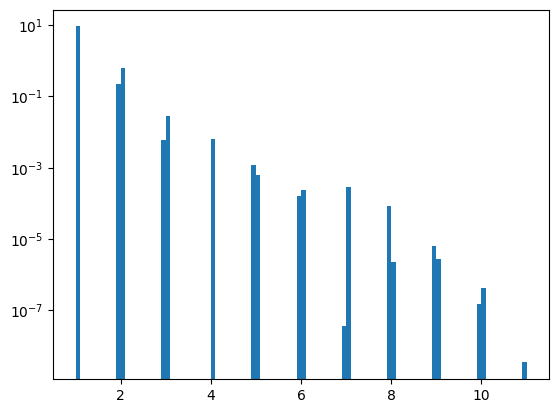

In [49]:
plt.hist(spread[1:], weights = np.diff(t), density=True,bins=100)
plt.yscale('log')
# plt.xscale('log')

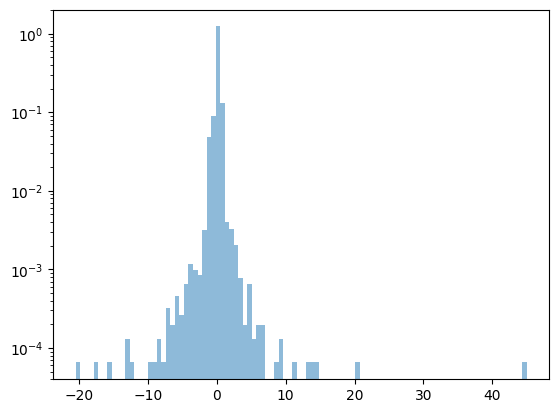

In [50]:
mid = (np.array(ask_t) + np.array(bid_t))/2
tau = 1
max_t = np.round(max(np.array(t) - 34200), decimals=0)
sample_x = np.linspace(0, max_t, int(max_t/tau))
idxs = np.searchsorted(np.array(t) - 34200, sample_x)[1:-1] - 1
sample_y = mid[idxs]
rets = np.diff(sample_y)# np.exp(np.diff(np.log(sample_y))) - 1
plt.hist(rets*100, bins = 100, alpha = 0.5, density = True)
plt.yscale('log')
plt.show()

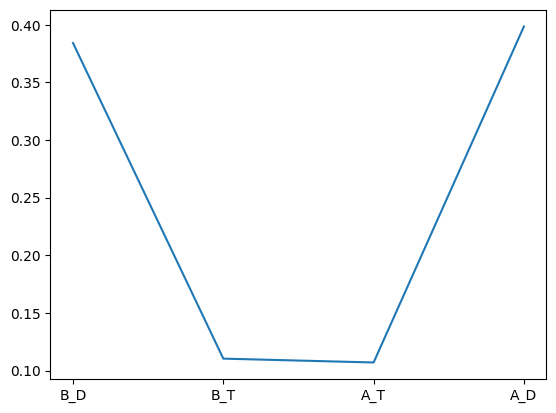

In [51]:
q_ask_t = []
q_bid_t = []
q_ask_d = []
q_bid_d= []
for r in lob:
    q_ask_t.append(r['Ask_touch'][1])
    q_bid_t.append(r['Bid_touch'][1])
    q_ask_d.append(r['Ask_deep'][1])
    q_bid_d.append(r['Bid_deep'][1])
Q= np.array([q_bid_d, q_bid_t, q_ask_t, q_ask_d])
Q = np.multiply(Q,(1./Q.sum(axis=0)))
Q_shape = Q.sum(axis=1)
Q_shape =Q_shape/Q_shape.sum()
plt.plot(['B_D', 'B_T', 'A_T', 'A_D'],Q_shape)


# Comparisons

In [3]:
path = '/SAN/fca/Konark_PhD_Experiments/simulated/smallTick/ergStudy/'
fnames = os.listdir(path)       

## spr0

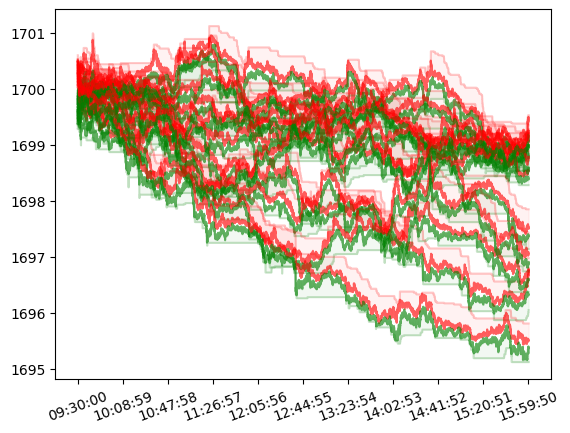

In [4]:
spreads = []
m_Ds, m_Ts = [], []
labels = []
fig, ax = plt.subplots()
for fname in fnames:
    if '_spr0_' in fname:
        with open(path+fname, 'rb') as f:
            T, lob = pickle.load(f)
        ask_t = []
        bid_t = []
        ask_d = []
        bid_d= []
        ask_m_D = []
        bid_m_D = []
        bid_m_D_1, bid_m_T_1 = [], []
        ask_m_D_1, ask_m_T_1 = [], []
        spread = []
        for r in lob:
            ask_t.append(r['Ask_touch'][0])
            bid_t.append(r['Bid_touch'][0])
            ask_d.append(r['Ask_deep'][0])
            bid_d.append(r['Bid_deep'][0])
            bid_m_D.append(r['Bid_deep'][0] - 0.01*r['Bid_m_D'])
            ask_m_D.append(r['Ask_deep'][0] + 0.01*r['Ask_m_D'])
            bid_m_D_1.append(r['Bid_m_D'])
            ask_m_D_1.append(r['Ask_m_D'])
            bid_m_T_1.append(r['Bid_m_T'])
            ask_m_T_1.append(r['Ask_m_T'])
            spread.append(100*(r['Ask_touch'][0] - r['Bid_touch'][0]))
        t = np.append([0], np.array(T[1:])[:,1])
        t = t.astype(float) + 9.5*3600
        
        
        ax.plot(t, ask_t, color = "r", alpha =0.5)
        ax.plot(t, ask_d, color="r", alpha = 0.2)
        ax.plot(t, ask_m_D, color="r", alpha = 0.2)
        ax.plot(t, bid_t, color="g", alpha =0.5)
        ax.plot(t, bid_d, color="g", alpha = 0.2)
        ax.plot(t, bid_m_D, color="g", alpha = 0.2)
        ax.fill_between(t, bid_d, bid_m_D, color="g", alpha = 0.05)
        ax.fill_between(t, ask_d, ask_m_D, color="r", alpha = 0.05)
        count = int((max(t) - min(t))/10)
        spreads.append(spread)
        labels.append(fname.split('_')[-1])
        m_Ds.append((np.array(bid_m_D_1)+np.array(ask_m_D_1))*0.5)
        m_Ts.append((np.array(bid_m_T_1)+np.array(ask_m_T_1))*0.5)
ax.ticklabel_format(useOffset=False)
ax.set_xticks(ticks = np.arange(min(t), max(t), count), labels = [time.strftime('%H:%M:%S', time.gmtime(x)) for x in np.arange(min(t), max(t), count)], rotation = 20)
plt.show()

Text(0.5, 1.0, 'Spread Distribution - various initial spread')

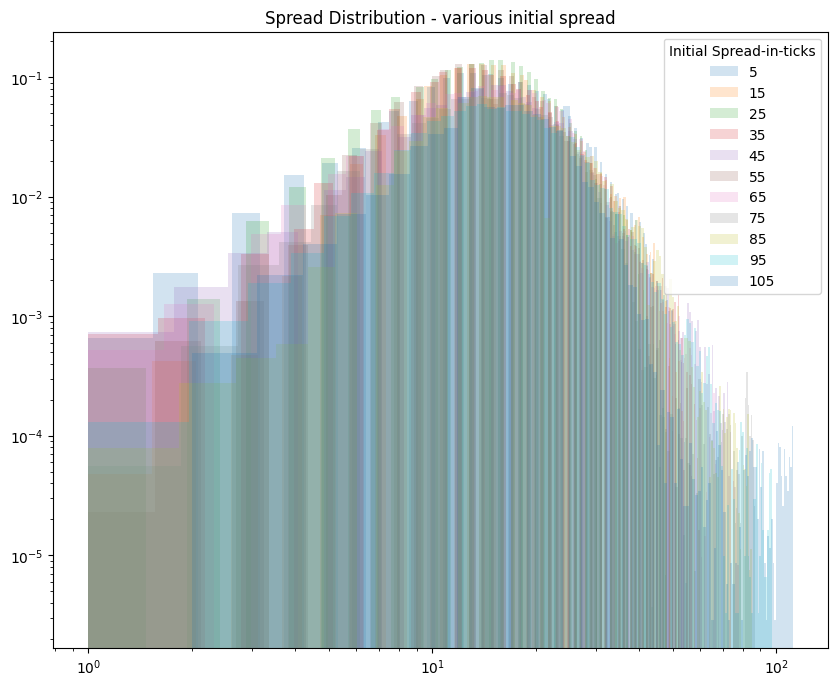

In [119]:
plt.figure(figsize=(10,8))
for s, l in sorted(zip(spreads, labels), key = lambda x: int(x[1])):
    plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.2)
plt.legend(loc='upper right', title = 'Initial Spread-in-ticks')
plt.xscale('log')
plt.yscale('log')
plt.title('Spread Distribution - various initial spread')

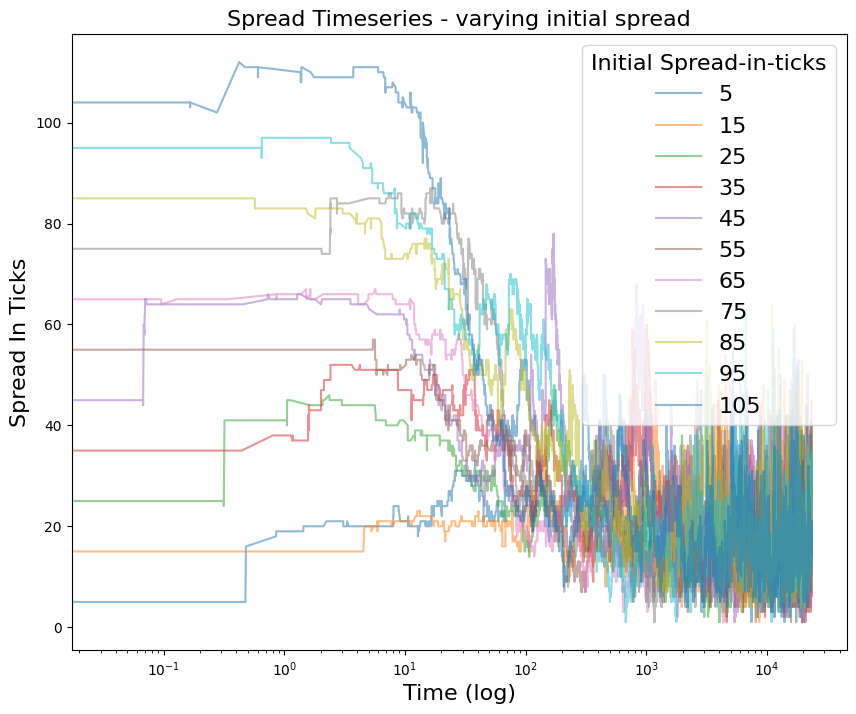

In [5]:
plt.figure(figsize=(10,8))
spreads = []
labels = []
for fname in sorted(fnames, key = lambda x: float(x.split('_')[-1])) :
    if '_spr0_' in fname:
        with open(path+'/'+fname, 'rb') as f:
            T, lob = pickle.load(f)
        ask_t = []
        bid_t = []
        ask_d = []
        bid_d= []
        ask_m_D = []
        bid_m_D = []
        spread = []
        for r in lob:
            ask_t.append(r['Ask_touch'][0])
            bid_t.append(r['Bid_touch'][0])
            ask_d.append(r['Ask_deep'][0])
            bid_d.append(r['Bid_deep'][0])
            bid_m_D.append(r['Bid_deep'][0] - 0.01*r['Bid_m_D'])
            ask_m_D.append(r['Ask_deep'][0] + 0.01*r['Ask_m_D'])
            spread.append(100*(r['Ask_touch'][0] - r['Bid_touch'][0]))
        t = np.append([0], np.array(T[1:])[:,1])
        t = t.astype(float) #+ 9.5*3600
        plt.plot(t,spread, label=fname.split('_')[-1], alpha= 0.5)
plt.legend(loc='upper right', title= 'Initial Spread-in-ticks', fontsize=16, title_fontsize=16)
plt.xscale('log')
plt.title('Spread Timeseries - varying initial spread', fontsize=16)
plt.xlabel('Time (log)', fontsize=16)
plt.ylabel('Spread In Ticks', fontsize=16)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/ergStudy_spr0.png")

Text(0.5, 1.0, '$m_D$ Distribution: Simulated')

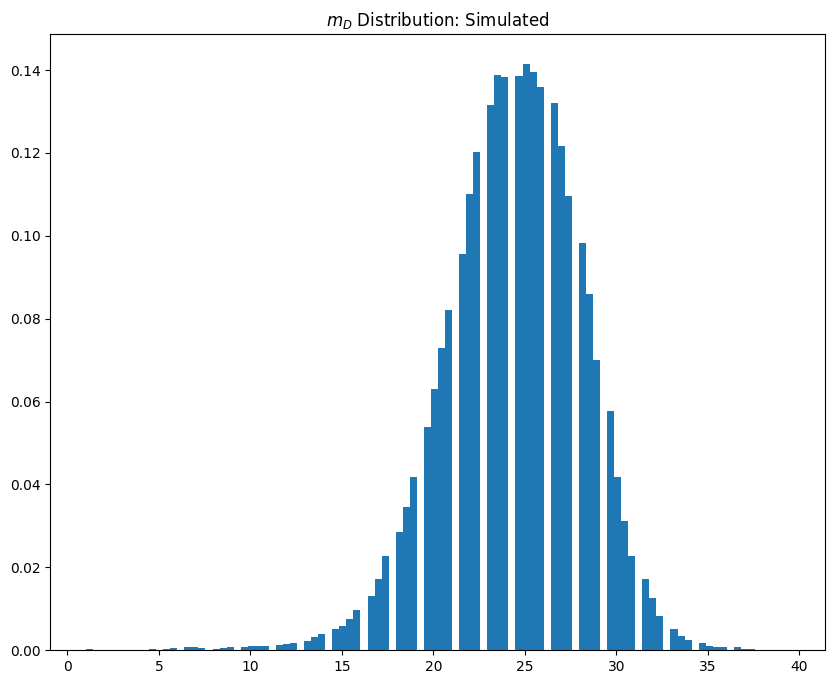

In [107]:
plt.figure(figsize=(10,8))
plt.hist(np.hstack(m_Ds), bins=100, density=True, histtype = 'stepfilled')
#plt.xscale('log')
#plt.yscale('log')
plt.title('$m_D$ Distribution: Simulated')

In [60]:
m_Ds_emp = []
ric = 'GOOG'
for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,1,10)):
            if j == dt.date(2019,1,9): continue
            #l = dataLoader(ric, j, j, nlevels = 10, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
            #_ = l.load()
            try:
                data= pd.read_csv("/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/"+ric+'_'+j.strftime('%Y-%m-%d')+'_12D.csv')
            except:
                continue
            # events wrt distance from mid in ticks
            data = data.loc[data['Type'] < 5]
            data = data.loc[data['Type'] !=2]
            data['sec'] = data['Time'].astype(int)
            intensityPerSec = data.groupby(['sec','Type','TradeDirection'])['Time'].count().apply(lambda x: [x])
            data['q_LO'] = np.nan
            data['q_LO'].loc[data['Type'] == 1] = data['Size'].loc[data['Type'] == 1]
            data['q_MO'] = np.nan
            data['q_MO'].loc[data['Type'] == 4] = data['Size'].loc[data['Type'] == 4]
            #
            data['is'] = 0
            data['diff'] = data['Ask Price 1'].shift(1) - data['Ask Price 1']
            data['is'].loc[data['diff'] > 0]  = 1
            data['diff'] = data['Bid Price 1'] - data['Bid Price 1'].shift(1)
            data['is'].loc[data['diff'] > 0]  = 1
            #
            data['eta_is'] = np.nan
            data['eta_is'].loc[data['is'] == 1] = 100*data['diff'].loc[data['is'] == 1]

            for side in ['Ask','Bid']:
                data['m_T_'+ side] = (data[side + ' Price 2'] - data[side + ' Price 1']).apply(lambda x: np.abs(100*np.round(x,decimals=2)))
                arr = data[[side + ' Size ' + str(i) for i in range(1,11)]].values
                x = abs(arr.cumsum(axis=1) - (arr.sum(axis=1)/2).reshape((len(arr),1))).argmin(axis=1)
                data['M_0.5_'+ side] = (data[[side + ' Price ' + str(i) for i in range(1,11)]].values)[np.arange(len(data)),x]
                data['m_D_'+ side] = (data['M_0.5_'+ side] - data[side + ' Price 2']).apply(lambda x: np.abs(100*np.round(x,decimals=2)))
            m_Ds_emp.append((data['m_D_Ask'].values+data['m_D_Bid'].values)*0.5)

/home/konajain/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/share/apps/python-3.8.5-shared/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


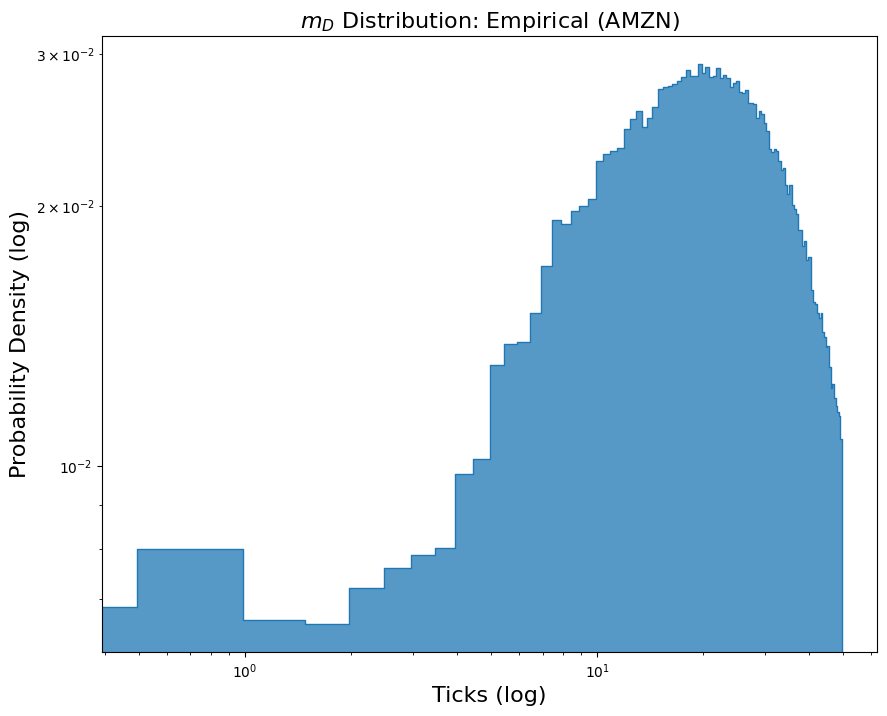

In [64]:
import seaborn as sns
plt.figure(figsize=(10,8))
emp = np.hstack(m_Ds_emp)
sns.histplot(emp[emp<50], bins=100, stat='density', element="step")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ticks (log)', fontsize=16)
plt.ylabel('Probability Density (log)', fontsize=16)
plt.title('$m_D$ Distribution: Empirical (AMZN)', fontsize=16)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/empirical_m_D.png")

## avgSpread, SpreadBeta:

$$\lambda^{(IS)}(s, t) = \bigg(\frac{s-1}{\alpha}\bigg)^\beta \times \lambda^{(IS)}(t)$$

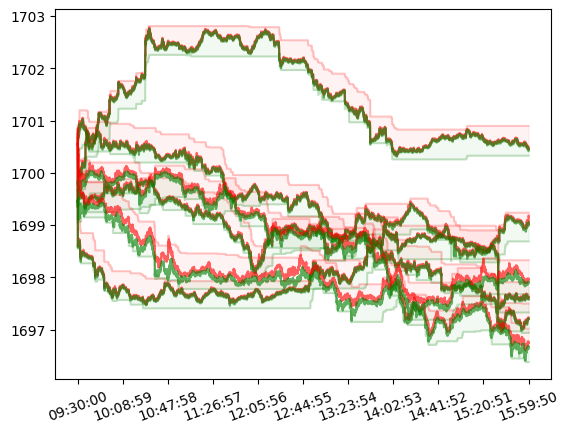

In [12]:
spreads = []
m_Ds, m_Ts = [], []
labels = []
fig, ax = plt.subplots()
for fname in fnames:
    if '_tickness_' in fname:
        with open(path+fname, 'rb') as f:
            T, lob = pickle.load(f)
        ask_t = []
        bid_t = []
        ask_d = []
        bid_d= []
        ask_m_D = []
        bid_m_D = []
        bid_m_D_1, bid_m_T_1 = [], []
        ask_m_D_1, ask_m_T_1 = [], []
        spread = []
        for r in lob:
            ask_t.append(r['Ask_touch'][0])
            bid_t.append(r['Bid_touch'][0])
            ask_d.append(r['Ask_deep'][0])
            bid_d.append(r['Bid_deep'][0])
            bid_m_D.append(r['Bid_deep'][0] - 0.01*r['Bid_m_D'])
            ask_m_D.append(r['Ask_deep'][0] + 0.01*r['Ask_m_D'])
            bid_m_D_1.append(r['Bid_m_D'])
            ask_m_D_1.append(r['Ask_m_D'])
            bid_m_T_1.append(r['Bid_m_T'])
            ask_m_T_1.append(r['Ask_m_T'])
            spread.append(100*(r['Ask_touch'][0] - r['Bid_touch'][0]))
        t = np.append([0], np.array(T[1:])[:,1])
        t = t.astype(float) + 9.5*3600
        
        
        ax.plot(t, ask_t, color = "r", alpha =0.5)
        ax.plot(t, ask_d, color="r", alpha = 0.2)
        ax.plot(t, ask_m_D, color="r", alpha = 0.2)
        ax.plot(t, bid_t, color="g", alpha =0.5)
        ax.plot(t, bid_d, color="g", alpha = 0.2)
        ax.plot(t, bid_m_D, color="g", alpha = 0.2)
        ax.fill_between(t, bid_d, bid_m_D, color="g", alpha = 0.05)
        ax.fill_between(t, ask_d, ask_m_D, color="r", alpha = 0.05)
        count = int((max(t) - min(t))/10)
        spreads.append(spread)
        labels.append(fname.split('_tickness_')[-1])
        m_Ds.append((np.array(bid_m_D_1)+np.array(ask_m_D_1))*0.5)
        m_Ts.append((np.array(bid_m_T_1)+np.array(ask_m_T_1))*0.5)
ax.ticklabel_format(useOffset=False)
ax.set_xticks(ticks = np.arange(min(t), max(t), count), labels = [time.strftime('%H:%M:%S', time.gmtime(x)) for x in np.arange(min(t), max(t), count)], rotation = 20)
plt.show()

Text(0.5, 1.0, 'Spread Distribution -  various IS intensities')

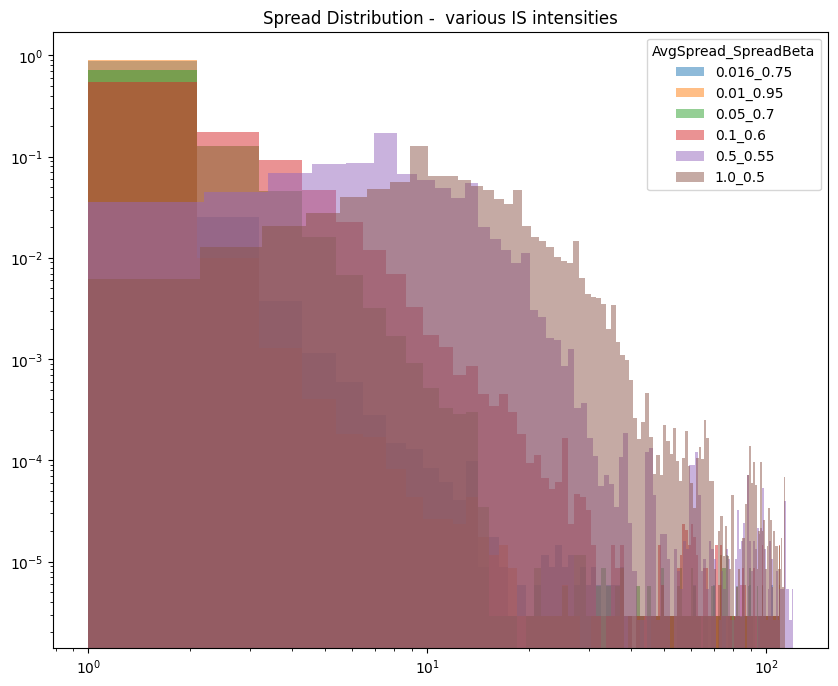

In [112]:
plt.figure(figsize=(10,8))
for s, l in zip(spreads, labels):
    plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.5)
plt.legend(loc='upper right', title = 'AvgSpread_SpreadBeta')
plt.xscale('log')
plt.yscale('log')
plt.title('Spread Distribution -  various IS intensities')

Text(0.5, 1.0, 'Spread Distribution - various IS intensities')

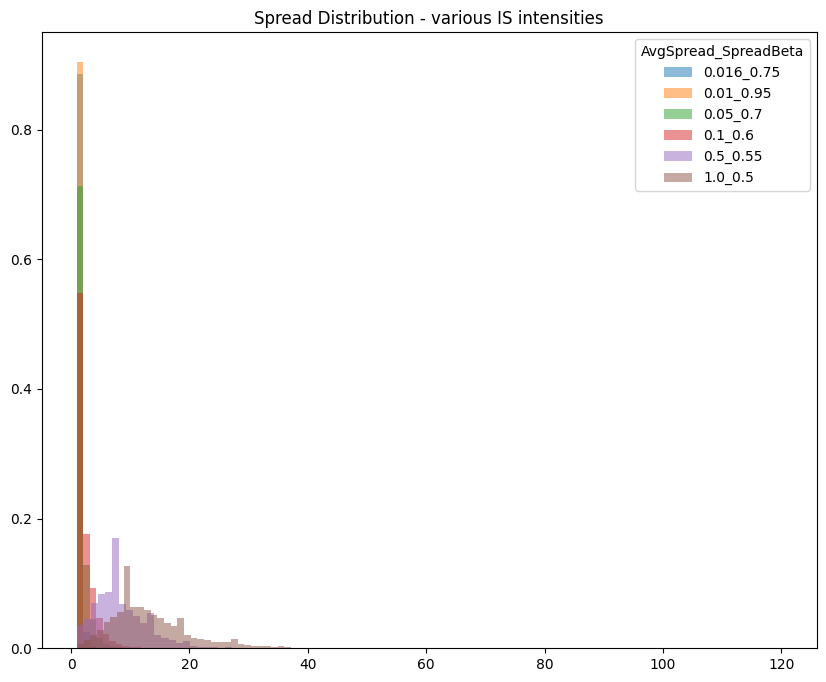

In [111]:
plt.figure(figsize=(10,8))
for s, l in zip(spreads, labels):
    plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.5)
plt.legend(loc='upper right', title = 'AvgSpread_SpreadBeta')
# plt.xscale('log')
# plt.yscale('log')
plt.title('Spread Distribution - various IS intensities')

In [ ]:
colors = iter([plt.cm.rainbow(100*i) for i in range(3)])
plt.figure(figsize=(10,8))
for s, l in zip(spreads, labels):
    if l in ['0.01_0.95', '0.05_0.7', '1.0_0.5']:
        plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.5, color=next(colors))
        #sns.histplot(s, bins=100, stat='density', element="step", label=l, alpha=0.5)
plt.legend(loc='upper right', title = '$\\alpha$ _ $\\beta$' , title_fontsize=16, fontsize=16)
# plt.xscale('log')
plt.yscale('log')
plt.title('Spread Distribution - various IS intensities', fontsize=16)
plt.ylabel('Probability Density (log)', fontsize=16)
# plt.title('Shape of the LOB - various IS intensities')
plt.xlabel('Spread in Ticks', fontsize=16)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/ergStudy_avgSpr.png")

In [13]:
volumes_1 , labels = [], [] 
for fname in fnames:
    if '_tickness_' in fname:
        # if  fname.split('_')[-1] not in ['5', '20', '50']:
        #     continue
        l = fname.split('beta_')[-1]
        if l in ['0.01_0.95', '0.05_0.7', '1.0_0.5']:
            with open(path+'/'+fname, 'rb') as f:
                T, lob = pickle.load(f)
            volumes = []
            for r in lob[2*len(lob)//5:3*len(lob)//5]:
                volume = [(( - r['Bid_deep'][0] + r['mid']) + 0.01*i, r['Bid_deep'][1]/r['Bid_m_D']) for i in range(int(r['Bid_m_D']))]
                volume += [((-r['Bid_touch'][0] + r['mid']), r['Bid_touch'][1])]
                volume += [((r['Ask_touch'][0] - r['mid']), r['Ask_touch'][1])]
                volume += [((r['Ask_deep'][0] - r['mid']) + 0.01*i, r['Ask_deep'][1]/r['Ask_m_D']) for i in range(int(r['Ask_m_D']))]
                volumes += [volume]
            volumes_1.append(volumes)
            labels.append(l)

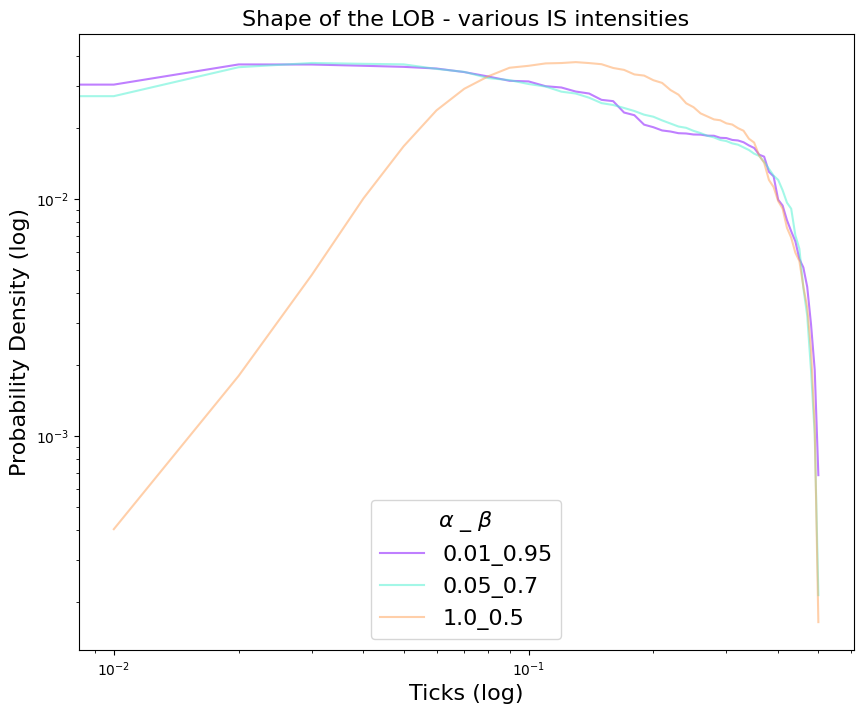

In [15]:
colors = iter([plt.cm.rainbow(100*i) for i in range(3)])
plt.figure(figsize=(10,8))
for volumes , label in zip(volumes_1, labels):
    dict_shape = {}
    for v in volumes:
        dists = np.array(v)[:,0]
        vols =  np.array(v)[:,1]
        for d, vol in zip(dists,vols):
            dict_shape[np.round(d, decimals=2)] = dict_shape.get(np.round(d, decimals=2), 0) + vol
    dist = np.sort(list(dict_shape.keys()))
    vol = np.array([dict_shape[d] for d in dist])
    vol = vol/vol.sum()
    plt.plot(np.array(dist)[vol > 1e-4], vol[vol > 1e-4], label = label, alpha=0.5, color=next(colors))
plt.yscale('log')
plt.xscale('log')
plt.legend( title = '$\\alpha$ _ $\\beta$' , title_fontsize=16, fontsize=16)
plt.ylabel('Probability Density (log)', fontsize=16)
plt.title('Shape of the LOB - various IS intensities', fontsize=16)
plt.xlabel('Ticks (log)', fontsize=16)
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/ergStudy_IS_shape.png')

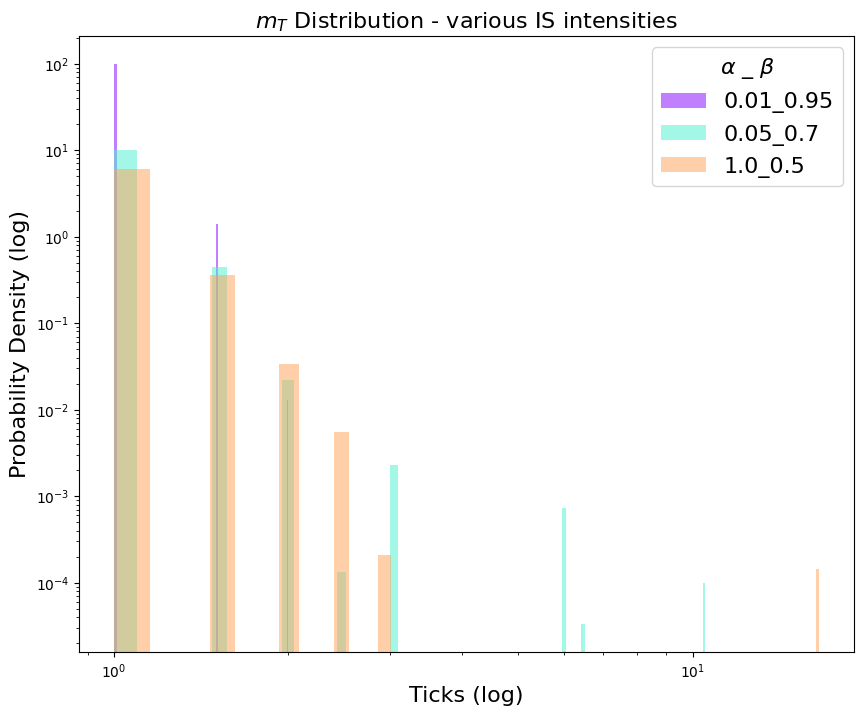

In [20]:
colors = iter([plt.cm.rainbow(100*i) for i in range(3)])
plt.figure(figsize=(10,8))
for s, l in zip(m_Ts, labels):
    l = l.split('beta_')[-1]
    if l in ['0.01_0.95', '0.05_0.7', '1.0_0.5']:
        plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.5, color=next(colors))
plt.legend( title = '$\\alpha$ _ $\\beta$' , title_fontsize=16, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ticks (log)', fontsize=16)
plt.ylabel('Probability Density (log)', fontsize=16)
plt.title('$m_T$ Distribution - various IS intensities', fontsize=16)
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/ergStudy_IS_m_T.png')

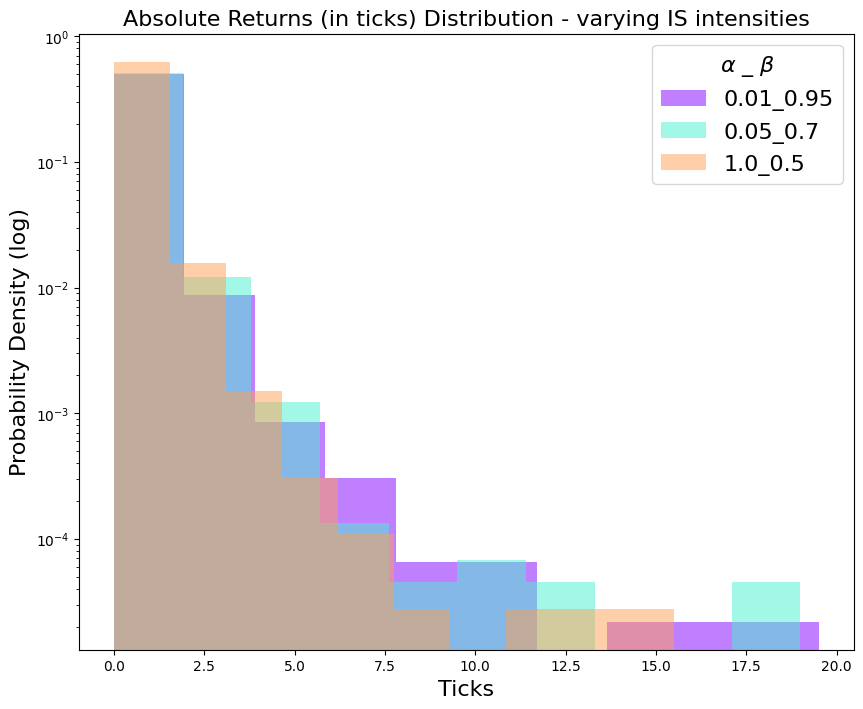

In [22]:
colors = iter([plt.cm.rainbow(100*i) for i in range(3)])
plt.figure(figsize=(10,8))
for fname in fnames:
   if '_tickness_' in fname:
        # if  fname.split('_')[-1] not in ['5', '20', '50']:
        #     continue
        l = fname.split('beta_')[-1]
        if l in ['0.01_0.95', '0.05_0.7', '1.0_0.5']:
            with open(path+'/'+fname, 'rb') as f:
                T, lob = pickle.load(f)
            ask_t = []
            bid_t = []
            ask_d = []
            bid_d= []
            ask_m_D = []
            bid_m_D = []
            bid_m_D_1 = []
            ask_m_D_1 = []
            spread = []
            for r in lob:
                ask_t.append(r['Ask_touch'][0])
                bid_t.append(r['Bid_touch'][0])
    
            mid = (np.array(ask_t) + np.array(bid_t))/2
            tau = 1
            max_t = np.round(max(np.array(t) - 34200), decimals=0)
            sample_x = np.linspace(0, max_t, int(max_t/tau))
            idxs = np.searchsorted(np.array(t) - 34200, sample_x)[1:-1] - 1
            sample_y = mid[idxs[idxs < len(mid)]]
            rets = np.diff(sample_y)# np.exp(np.diff(np.log(sample_y))) - 1
            plt.hist(np.abs(rets)*100, alpha = 0.5, density = True,  histtype = 'stepfilled', label = l, color=next(colors))
plt.legend( title = '$\\alpha$ _ $\\beta$' , title_fontsize=16, fontsize=16)
plt.yscale('log')
plt.title('Absolute Returns (in ticks) Distribution - varying IS intensities', fontsize=16)

plt.xlabel('Ticks', fontsize=16)
plt.ylabel('Probability Density (log)', fontsize=16)
# plt.title('$m_T$ Distribution - varying sparsity $\hat{\eta}$')
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/ergStudy_IS_ret.png')
plt.show()

## M_med

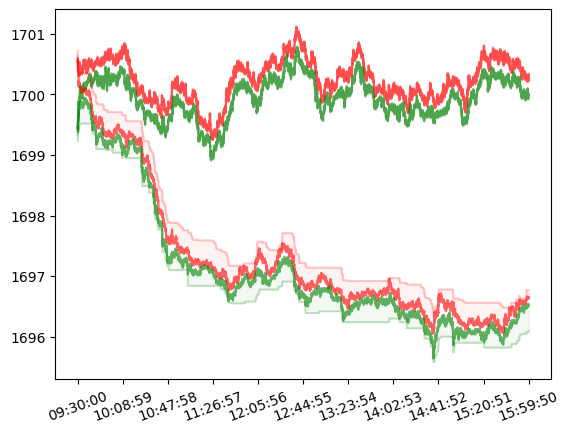

In [94]:
spreads = []
m_Ds, m_Ts = [], []
labels = []
fig, ax = plt.subplots()
for fname in fnames:
    if '_Mmed_' in fname:
        if  fname.split('_')[-1] not in ['5', '50']:
            continue
        with open(path+'\\'+fname, 'rb') as f:
            T, lob = pickle.load(f)
            
        ask_t = []
        bid_t = []
        ask_d = []
        bid_d= []
        ask_m_D = []
        bid_m_D = []
        bid_m_D_1, bid_m_T_1 = [], []
        ask_m_D_1, ask_m_T_1 = [], []
        spread = []
        for r in lob:
            ask_t.append(r['Ask_touch'][0])
            bid_t.append(r['Bid_touch'][0])
            ask_d.append(r['Ask_deep'][0])
            bid_d.append(r['Bid_deep'][0])
            bid_m_D.append(r['Bid_deep'][0] - 0.01*r['Bid_m_D'])
            ask_m_D.append(r['Ask_deep'][0] + 0.01*r['Ask_m_D'])
            bid_m_D_1.append(r['Bid_m_D'])
            ask_m_D_1.append(r['Ask_m_D'])
            bid_m_T_1.append(r['Bid_m_T'])
            ask_m_T_1.append(r['Ask_m_T'])
            spread.append(100*(r['Ask_touch'][0] - r['Bid_touch'][0]))
        t = np.append([0], np.array(T[1:])[:,1])
        t = t.astype(float) + 9.5*3600
        
        
        ax.plot(t, ask_t, color = "r", alpha =0.5)
        ax.plot(t, ask_d, color="r", alpha = 0.2)
        ax.plot(t, ask_m_D, color="r", alpha = 0.2)
        ax.plot(t, bid_t, color="g", alpha =0.5)
        ax.plot(t, bid_d, color="g", alpha = 0.2)
        ax.plot(t, bid_m_D, color="g", alpha = 0.2)
        ax.fill_between(t, bid_d, bid_m_D, color="g", alpha = 0.05)
        ax.fill_between(t, ask_d, ask_m_D, color="r", alpha = 0.05)
        count = int((max(t) - min(t))/10)
        spreads.append(spread)
        labels.append(fname.split('_')[-1])
        m_Ds.append((np.array(bid_m_D_1)+np.array(ask_m_D_1))*0.5)
        m_Ts.append((np.array(bid_m_T_1)+np.array(ask_m_T_1))*0.5)
ax.ticklabel_format(useOffset=False)
ax.set_xticks(ticks = np.arange(min(t), max(t), count), labels = [time.strftime('%H:%M:%S', time.gmtime(x)) for x in np.arange(min(t), max(t), count)], rotation = 20)
plt.show()

Text(0.5, 1.0, 'Spread Distribution - various maximum depth $M_{med}$')

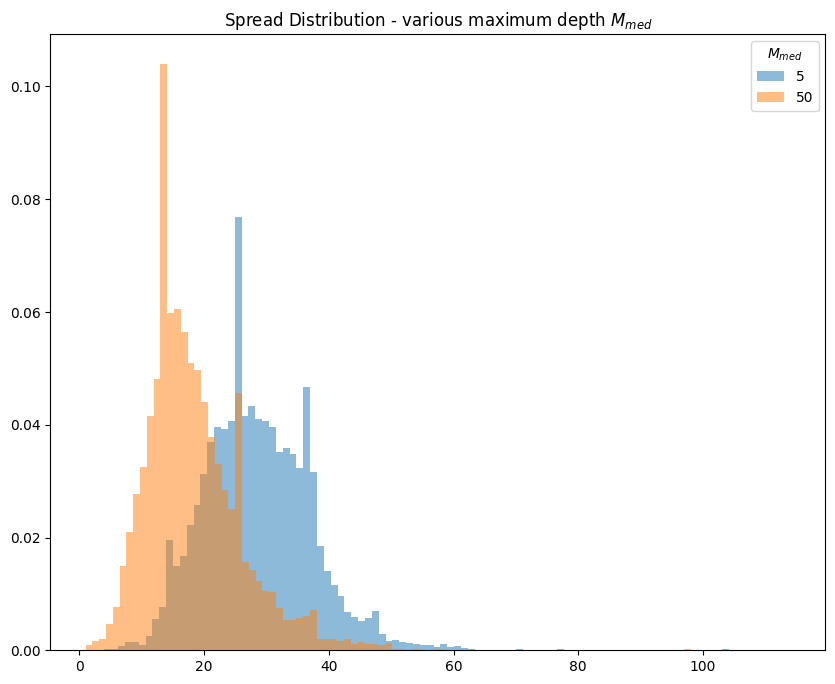

In [61]:
plt.figure(figsize=(10,8))
for s, l in sorted(zip(spreads, labels), key = lambda x: int(x[1])):
    if l not in ['5','10','20','50']:
        continue
    plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.5)
plt.legend(loc='upper right', title = '$M_{med}$')
# plt.xscale('log')
# plt.yscale('log')
plt.title('Spread Distribution - various maximum depth $M_{med}$')

Text(0.5, 1.0, '$m_D$ Distribution - various maximum depth $M_{med}$')

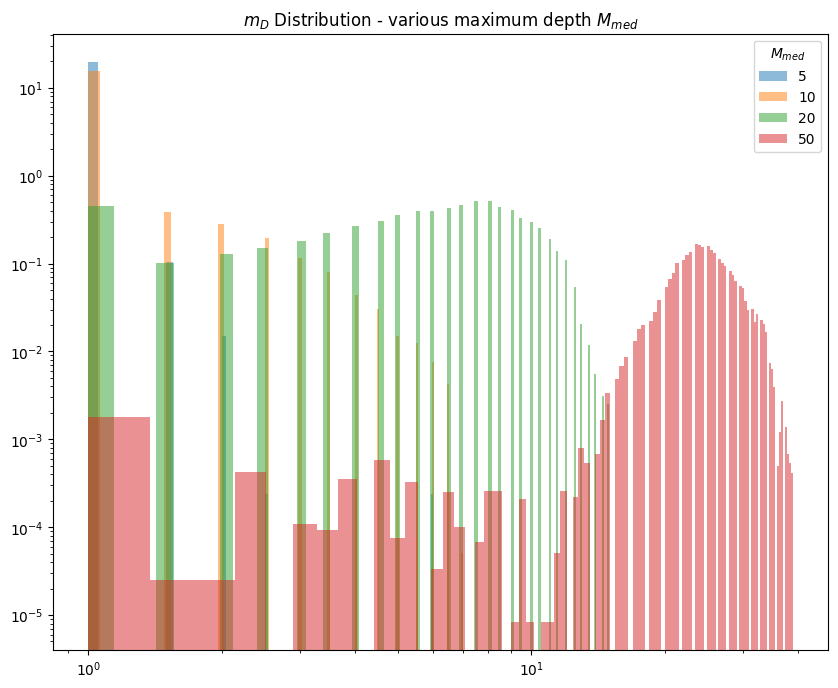

In [56]:
plt.figure(figsize=(10,8))
for s, l in sorted(zip(m_Ds, labels), key = lambda x: int(x[1])):
    if l not in ['5','10','20','50']:
        continue
    plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.5)
plt.legend(loc='upper right', title = '$M_{med}$')
plt.xscale('log')
plt.yscale('log')
plt.title('$m_D$ Distribution - various maximum depth $M_{med}$')

Text(0.5, 1.0, '$m_T$ Distribution - various maximum depth $M_{med}$')

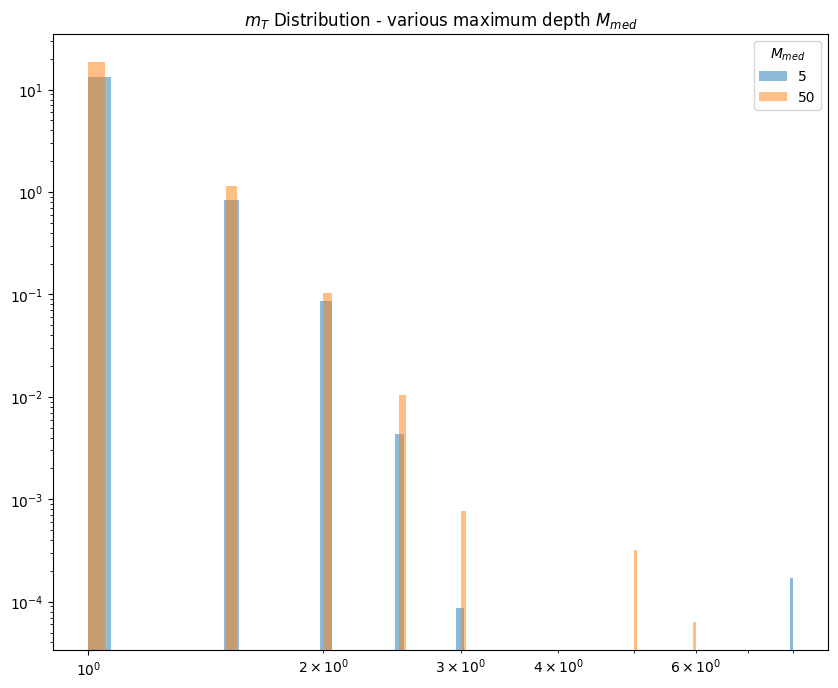

In [95]:
plt.figure(figsize=(10,8))
for s, l in sorted(zip(m_Ts, labels), key = lambda x: int(x[1])):
    if l not in ['5','10','20','50']:
        continue
    plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.5)
plt.legend(loc='upper right', title = '$M_{med}$')
plt.xscale('log')
plt.yscale('log')
plt.title('$m_T$ Distribution - various maximum depth $M_{med}$')

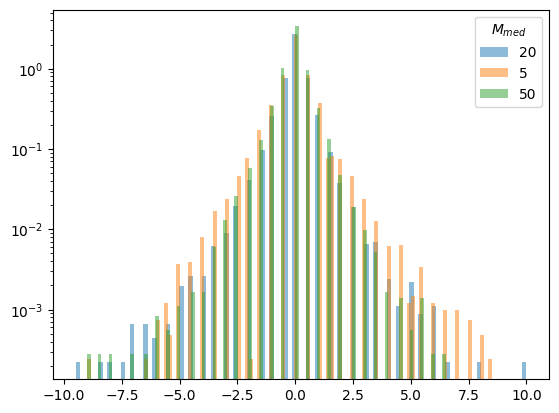

In [60]:
for fname in fnames:
    if '_Mmed_' in fname:
        if  fname.split('_')[-1] not in ['5','20', '50']:
            continue
        with open(path+'\\'+fname, 'rb') as f:
            T, lob = pickle.load(f)
        ask_t = []
        bid_t = []
        ask_d = []
        bid_d= []
        ask_m_D = []
        bid_m_D = []
        bid_m_D_1 = []
        ask_m_D_1 = []
        spread = []
        for r in lob:
            ask_t.append(r['Ask_touch'][0])
            bid_t.append(r['Bid_touch'][0])

        mid = (np.array(ask_t) + np.array(bid_t))/2
        tau = 1
        max_t = np.round(max(np.array(t) - 34200), decimals=0)
        sample_x = np.linspace(0, max_t, int(max_t/tau))
        idxs = np.searchsorted(np.array(t) - 34200, sample_x)[1:-1] - 1
        sample_y = mid[idxs[idxs < len(mid)]]
        rets = np.diff(sample_y)# np.exp(np.diff(np.log(sample_y))) - 1
        plt.hist(rets*100, bins = 100, alpha = 0.5, density = True, label = fname.split('_')[-1])
plt.legend(loc='upper right', title = '$M_{med}$')
plt.yscale('log')
plt.show()

In [88]:
volumes_1 , labels = [], [] 
for fname in fnames:
    if '_Mmed_' in fname:
        # if  fname.split('_')[-1] not in ['5', '20', '50']:
        #     continue
        with open(path+'\\'+fname, 'rb') as f:
            T, lob = pickle.load(f)
        volumes = []
        for r in lob:
            volume = [(( - r['Bid_deep'][0] + r['mid']) + 0.01*i, r['Bid_deep'][1]/r['Bid_m_D']) for i in range(int(r['Bid_m_D']))]
            volume += [((-r['Bid_touch'][0] + r['mid']), r['Bid_touch'][1])]
            volume += [((r['Ask_touch'][0] - r['mid']), r['Ask_touch'][1])]
            volume += [((r['Ask_deep'][0] - r['mid']) + 0.01*i, r['Ask_deep'][1]/r['Ask_m_D']) for i in range(int(r['Ask_m_D']))]
            volumes += [volume]
        volumes_1.append(volumes)
        labels.append(fname.split('_')[-1])

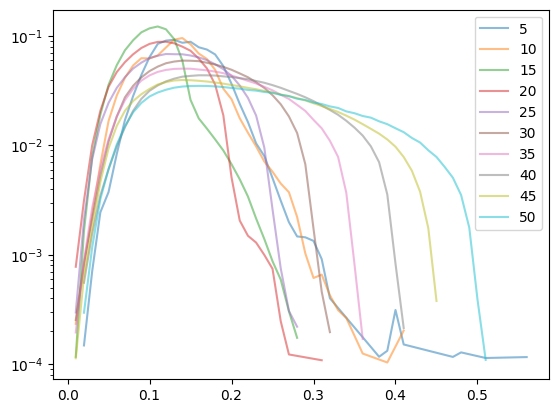

In [89]:
for volumes , label in sorted(zip(volumes_1, labels), key = lambda x: int(x[1])):
    dict_shape = {}
    for v in volumes:
        dists = np.array(v)[:,0]
        vols =  np.array(v)[:,1]
        for d, vol in zip(dists,vols):
            dict_shape[np.round(d, decimals=2)] = dict_shape.get(np.round(d, decimals=2), 0) + vol
    dist = list(dict_shape.keys())
    vol = np.array(list(dict_shape.values()))
    vol = vol/vol.sum()
    plt.plot(np.array(dist)[vol > 1e-4], vol[vol > 1e-4], label = label, alpha=0.5) 
plt.yscale('log')
plt.xscale('log')
plt.legend()

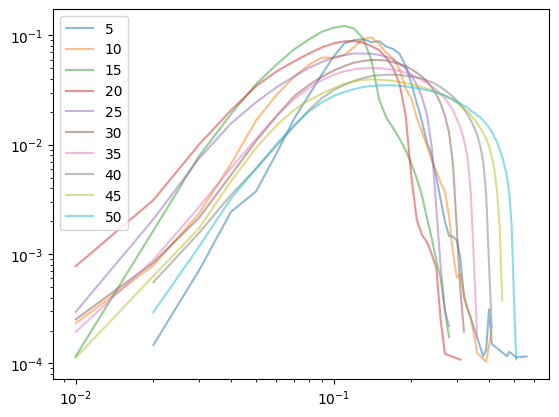

In [93]:
for volumes , label in sorted(zip(volumes_1, labels), key = lambda x: int(x[1])):
    dict_shape = {}
    for v in volumes:
        dists = np.array(v)[:,0]
        vols =  np.array(v)[:,1]
        for d, vol in zip(dists,vols):
            dict_shape[np.round(d, decimals=2)] = dict_shape.get(np.round(d, decimals=2), 0) + vol
    dist = list(dict_shape.keys())
    vol = np.array(list(dict_shape.values()))
    vol = vol/vol.sum()
    plt.plot(np.array(dist)[vol > 1e-4], vol[vol > 1e-4], label = label, alpha=0.5) 
plt.yscale('log')
plt.xscale('log')
plt.legend()

## Initial Sparsity - M0

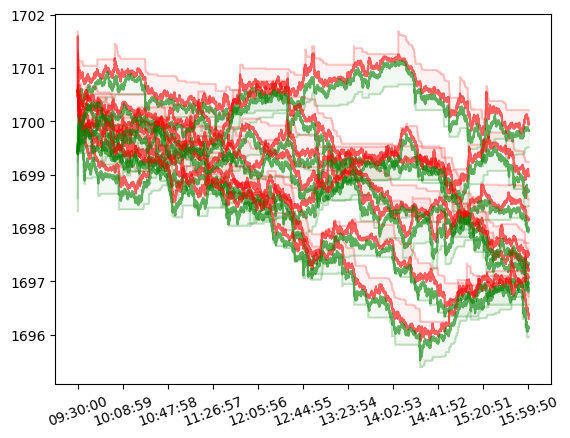

In [32]:
spreads = []
m_Ds, m_Ts = [], []
labels = []
fig, ax = plt.subplots()
for fname in fnames:
    if '_M0_' in fname:
        # if  fname.split('_')[-1] not in ['5', '50']:
        #     continue
        with open(path+'/'+fname, 'rb') as f:
            T, lob = pickle.load(f)
            
        ask_t = []
        bid_t = []
        ask_d = []
        bid_d= []
        ask_m_D = []
        bid_m_D = []
        bid_m_D_1, bid_m_T_1 = [], []
        ask_m_D_1, ask_m_T_1 = [], []
        spread = []
        for r in lob:
            ask_t.append(r['Ask_touch'][0])
            bid_t.append(r['Bid_touch'][0])
            ask_d.append(r['Ask_deep'][0])
            bid_d.append(r['Bid_deep'][0])
            bid_m_D.append(r['Bid_deep'][0] - 0.01*r['Bid_m_D'])
            ask_m_D.append(r['Ask_deep'][0] + 0.01*r['Ask_m_D'])
            bid_m_D_1.append(r['Bid_m_D'])
            ask_m_D_1.append(r['Ask_m_D'])
            bid_m_T_1.append(r['Bid_m_T'])
            ask_m_T_1.append(r['Ask_m_T'])
            spread.append(100*(r['Ask_touch'][0] - r['Bid_touch'][0]))
        t = np.append([0], np.array(T[1:])[:,1])
        t = t.astype(float) + 9.5*3600
        
        
        ax.plot(t, ask_t, color = "r", alpha =0.5)
        ax.plot(t, ask_d, color="r", alpha = 0.2)
        ax.plot(t, ask_m_D, color="r", alpha = 0.2)
        ax.plot(t, bid_t, color="g", alpha =0.5)
        ax.plot(t, bid_d, color="g", alpha = 0.2)
        ax.plot(t, bid_m_D, color="g", alpha = 0.2)
        ax.fill_between(t, bid_d, bid_m_D, color="g", alpha = 0.05)
        ax.fill_between(t, ask_d, ask_m_D, color="r", alpha = 0.05)
        count = int((max(t) - min(t))/10)
        spreads.append(spread)
        labels.append(fname.split('_')[-1])
        m_Ds.append((np.array(bid_m_D_1)+np.array(ask_m_D_1))*0.5)
        m_Ts.append((np.array(bid_m_T_1)+np.array(ask_m_T_1))*0.5)
ax.ticklabel_format(useOffset=False)
ax.set_xticks(ticks = np.arange(min(t), max(t), count), labels = [time.strftime('%H:%M:%S', time.gmtime(x)) for x in np.arange(min(t), max(t), count)], rotation = 20)
plt.show()

Text(0.5, 1.0, '$m_T$ Distribution - various maximum depth $M0$')

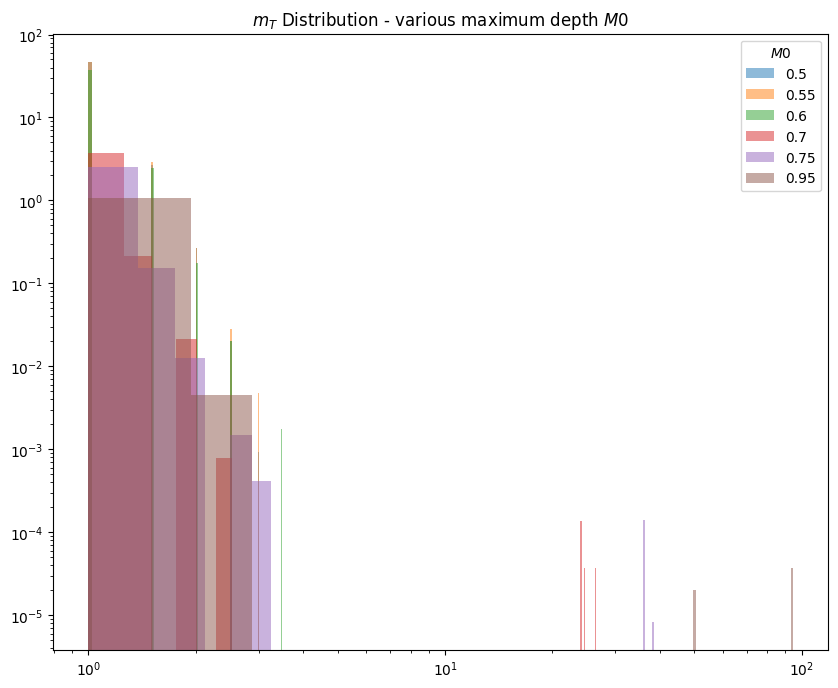

In [103]:
plt.figure(figsize=(10,8))
for s, l in sorted(zip(m_Ts, labels), key = lambda x: float(x[1])):
    # if l not in ['5','10','20','50']:
    #     continue
    plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.5)
plt.legend(loc='upper right', title = '$M0$')
plt.xscale('log')
plt.yscale('log')
plt.title('$m_T$ Distribution - various maximum depth $M0$')

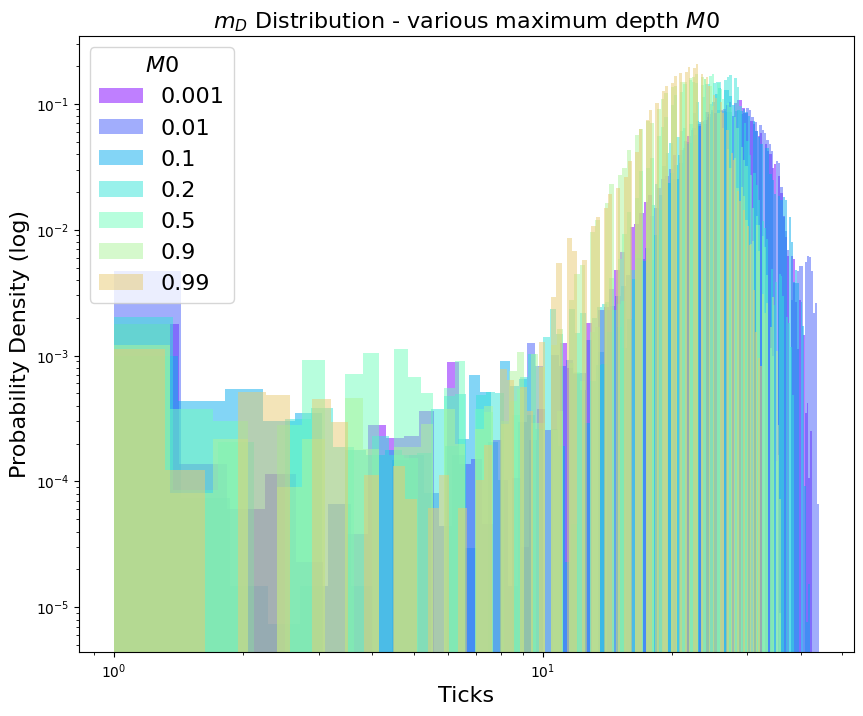

In [33]:
colors = iter([plt.cm.rainbow(30*i) for i in range(len(labels))])
plt.figure(figsize=(10,8))
for s, l in sorted(zip(m_Ds, labels), key = lambda x: float(x[1])):
    # if l not in ['5','10','20','50']:
    #     continue
    plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.5,color=next(colors))
plt.legend(loc='upper left', title = '$M0$', fontsize=16, title_fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.title('$m_D$ Distribution - various maximum depth $M0$', fontsize=16)

plt.xlabel('Ticks', fontsize=16)
plt.ylabel('Probability Density (log)', fontsize=16)
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/ergStudy_M0.png')

## Varying Sparsity - eta

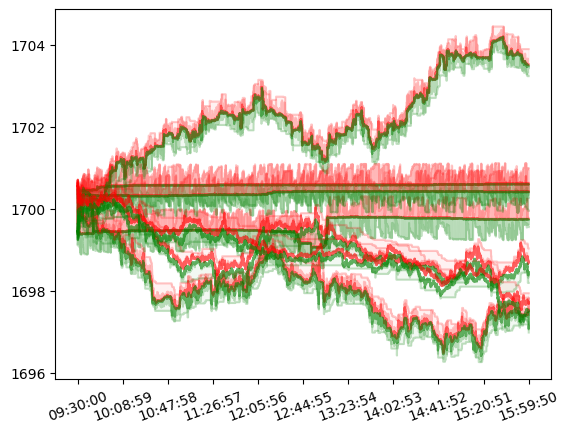

In [6]:
spreads = []
m_Ds, m_Ts = [], []
labels = []
fig, ax = plt.subplots()
for fname in fnames:
    if '_eta_' in fname:
        # if  fname.split('_')[-1] not in ['5', '50']:
        #     continue
        with open(path+fname, 'rb') as f:
            T, lob = pickle.load(f)
            
        ask_t = []
        bid_t = []
        ask_d = []
        bid_d= []
        ask_m_D = []
        bid_m_D = []
        bid_m_D_1, bid_m_T_1 = [], []
        ask_m_D_1, ask_m_T_1 = [], []
        spread = []
        for r in lob:
            ask_t.append(r['Ask_touch'][0])
            bid_t.append(r['Bid_touch'][0])
            ask_d.append(r['Ask_deep'][0])
            bid_d.append(r['Bid_deep'][0])
            bid_m_D.append(r['Bid_deep'][0] - 0.01*r['Bid_m_D'])
            ask_m_D.append(r['Ask_deep'][0] + 0.01*r['Ask_m_D'])
            bid_m_D_1.append(r['Bid_m_D'])
            ask_m_D_1.append(r['Ask_m_D'])
            bid_m_T_1.append(r['Bid_m_T'])
            ask_m_T_1.append(r['Ask_m_T'])
            spread.append(100*(r['Ask_touch'][0] - r['Bid_touch'][0]))
        t = np.append([0], np.array(T[1:])[:,1])
        t = t.astype(float) + 9.5*3600
        
        
        ax.plot(t, ask_t, color = "r", alpha =0.5)
        ax.plot(t, ask_d, color="r", alpha = 0.2)
        ax.plot(t, ask_m_D, color="r", alpha = 0.2)
        ax.plot(t, bid_t, color="g", alpha =0.5)
        ax.plot(t, bid_d, color="g", alpha = 0.2)
        ax.plot(t, bid_m_D, color="g", alpha = 0.2)
        ax.fill_between(t, bid_d, bid_m_D, color="g", alpha = 0.05)
        ax.fill_between(t, ask_d, ask_m_D, color="r", alpha = 0.05)
        count = int((max(t) - min(t))/10)
        spreads.append(spread)
        labels.append(fname.split('_')[-1])
        m_Ds.append((np.array(bid_m_D_1)+np.array(ask_m_D_1))*0.5)
        m_Ts.append((np.array(bid_m_T_1)+np.array(ask_m_T_1))*0.5)
ax.ticklabel_format(useOffset=False)
ax.set_xticks(ticks = np.arange(min(t), max(t), count), labels = [time.strftime('%H:%M:%S', time.gmtime(x)) for x in np.arange(min(t), max(t), count)], rotation = 20)
plt.show()

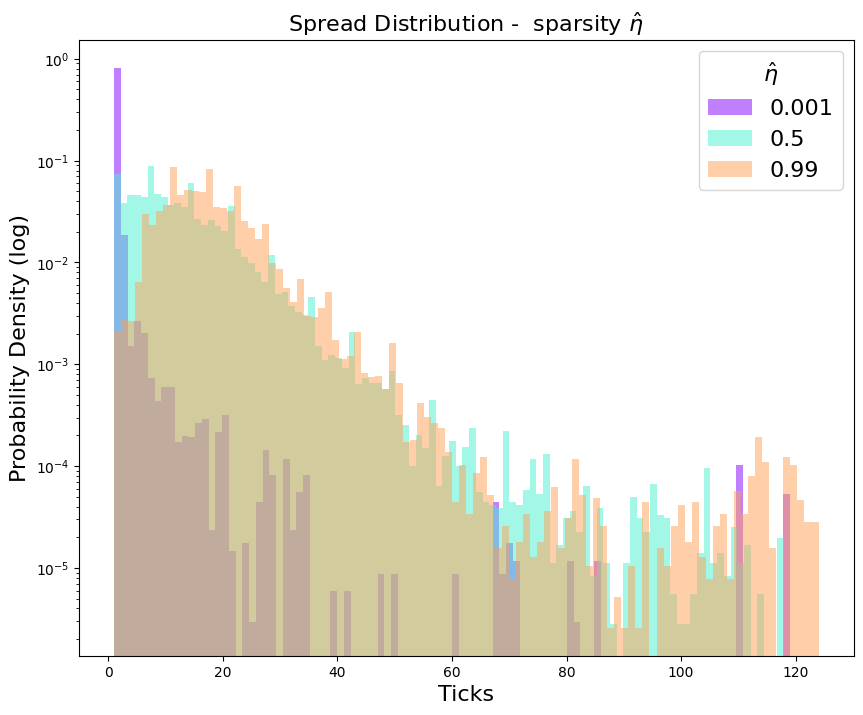

In [36]:
colors = iter([plt.cm.rainbow(100*i) for i in range(len(labels))])
plt.figure(figsize=(10,8))
for s, l in zip(spreads, labels):
    if l in ['0.001', '0.5', '0.99']:        
        plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.5, color=next(colors))
plt.legend(loc='upper right', title = '$\hat{\eta}$', fontsize=16, title_fontsize=16)
# plt.xscale('log')
plt.yscale('log')
plt.title('Spread Distribution -  sparsity $\hat{\eta}$', fontsize=16)
plt.xlabel('Ticks', fontsize=16)
plt.ylabel('Probability Density (log)', fontsize=16)
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/ergStudy_eta_spr.png')

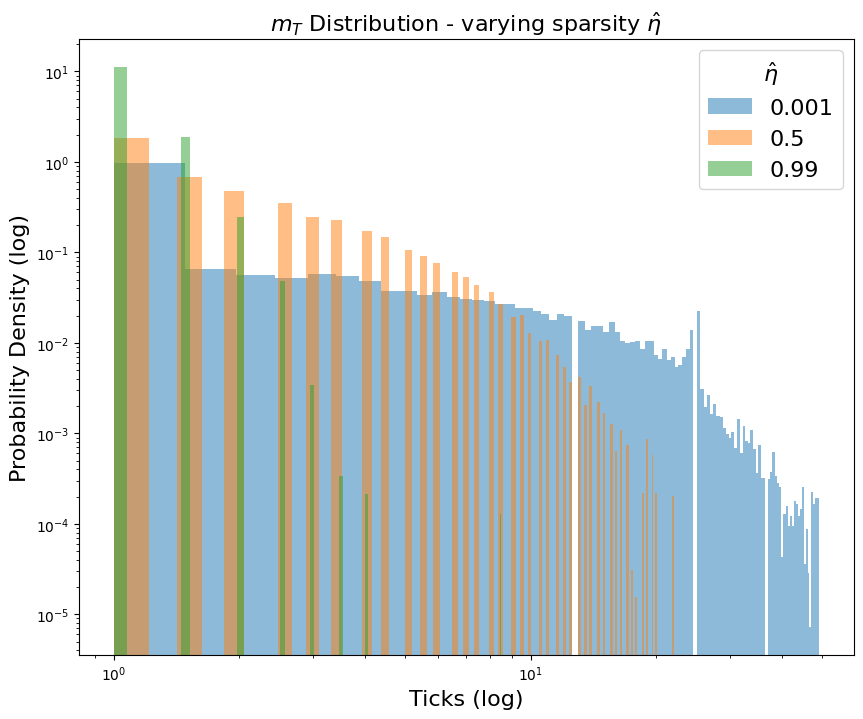

In [39]:
colors = iter([plt.cm.viridis(100*i) for i in range(len(labels))])
plt.figure(figsize=(10,8))
for s, l in sorted(zip(m_Ts, labels), key = lambda x: float(x[1])):
    if l not in ['0.001', '0.5', '0.99']:
        continue
    plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.5)
plt.legend(loc='upper right', title = '$\hat{\eta}$', fontsize=16, title_fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ticks (log)', fontsize=16)
plt.ylabel('Probability Density (log)', fontsize=16)
plt.title('$m_T$ Distribution - varying sparsity $\hat{\eta}$', fontsize=16)
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/ergStudy_eta_m_T.png')

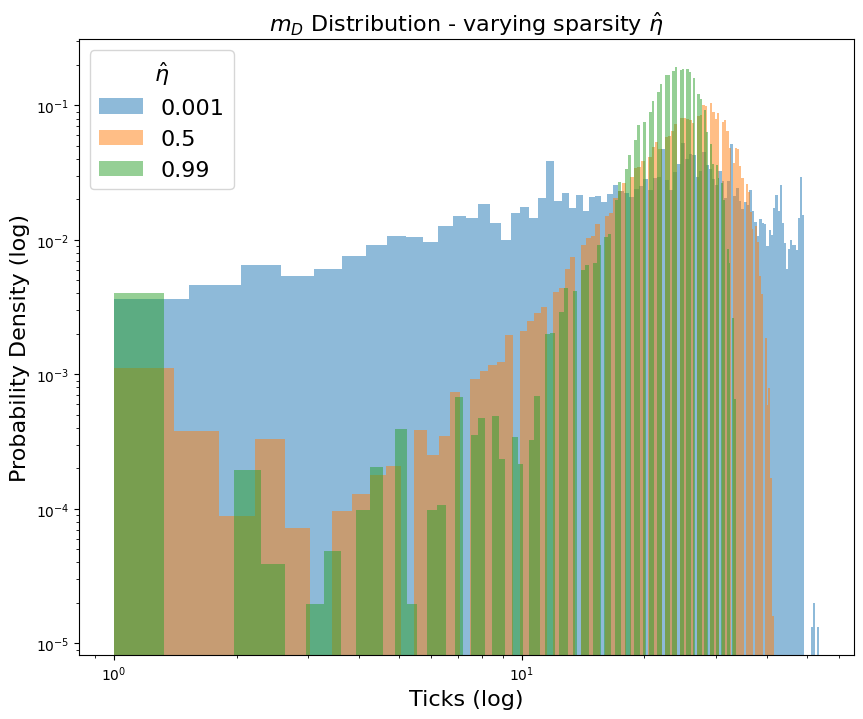

In [43]:
plt.figure(figsize=(10,8))
for s, l in sorted(zip(m_Ds, labels), key = lambda x: float(x[1])):
    if l not in ['0.001', '0.5', '0.99']:
        continue
    plt.hist(s, bins=100, label=l, density=True, histtype = 'stepfilled', alpha = 0.5)
plt.legend(loc='upper left', title = '$\hat{\eta}$', fontsize=16, title_fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.title('$m_D$ Distribution - varying sparsity $\hat{\eta}$', fontsize=16)
plt.xlabel('Ticks (log)', fontsize=16)
plt.ylabel('Probability Density (log)', fontsize=16)
# plt.title('$m_T$ Distribution - varying sparsity $\hat{\eta}$')
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/ergStudy_eta_m_D.png')

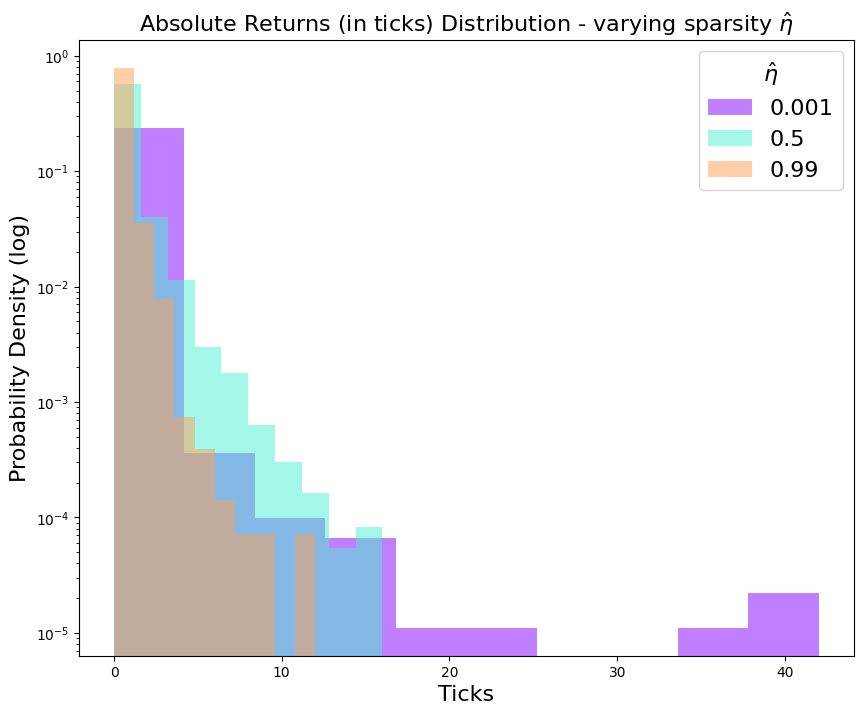

In [41]:
colors = iter([plt.cm.rainbow(100*i) for i in range(len(labels))])
plt.figure(figsize=(10,8))
for fname in fnames:
    if '_eta_' in fname:
        if  fname.split('_')[-1] not in ['0.001', '0.5', '0.99']:
            continue
        with open(path+'/'+fname, 'rb') as f:
            T, lob = pickle.load(f)
        ask_t = []
        bid_t = []
        ask_d = []
        bid_d= []
        ask_m_D = []
        bid_m_D = []
        bid_m_D_1 = []
        ask_m_D_1 = []
        spread = []
        for r in lob:
            ask_t.append(r['Ask_touch'][0])
            bid_t.append(r['Bid_touch'][0])

        mid = (np.array(ask_t) + np.array(bid_t))/2
        tau = 1
        max_t = np.round(max(np.array(t) - 34200), decimals=0)
        sample_x = np.linspace(0, max_t, int(max_t/tau))
        idxs = np.searchsorted(np.array(t) - 34200, sample_x)[1:-1] - 1
        sample_y = mid[idxs[idxs < len(mid)]]
        rets = np.diff(sample_y)# np.exp(np.diff(np.log(sample_y))) - 1
        plt.hist(np.abs(rets)*100, alpha = 0.5, density = True,  histtype = 'stepfilled', label = fname.split('_')[-1], color=next(colors))
plt.legend(loc='upper right', title = '$\hat{\eta}$', fontsize=16, title_fontsize=16)
plt.yscale('log')
plt.title('Absolute Returns (in ticks) Distribution - varying sparsity $\hat{\eta}$', fontsize=16)

plt.xlabel('Ticks', fontsize=16)
plt.ylabel('Probability Density (log)', fontsize=16)
# plt.title('$m_T$ Distribution - varying sparsity $\hat{\eta}$')
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/ergStudy_eta_ret.png')
plt.show()

In [10]:
volumes_1 , labels = [], [] 
for fname in fnames:
    if '_eta_' in fname:
            if  fname.split('_')[-1] not in ['0.001', '0.5', '0.99']:
                continue
            with open(path+'/'+fname, 'rb') as f:
                T, lob = pickle.load(f)
            volumes = []
            for r in lob[2*len(lob)//5:3*len(lob)//5]:
                volume = [(( - r['Bid_deep'][0] + r['mid']) + 0.01*i, r['Bid_deep'][1]/r['Bid_m_D']) for i in range(int(r['Bid_m_D']))]
                volume += [((-r['Bid_touch'][0] + r['mid']), r['Bid_touch'][1])]
                volume += [((r['Ask_touch'][0] - r['mid']), r['Ask_touch'][1])]
                volume += [((r['Ask_deep'][0] - r['mid']) + 0.01*i, r['Ask_deep'][1]/r['Ask_m_D']) for i in range(int(r['Ask_m_D']))]
                volumes += [volume]
            volumes_1.append(volumes)
            labels.append(fname.split('_')[-1])

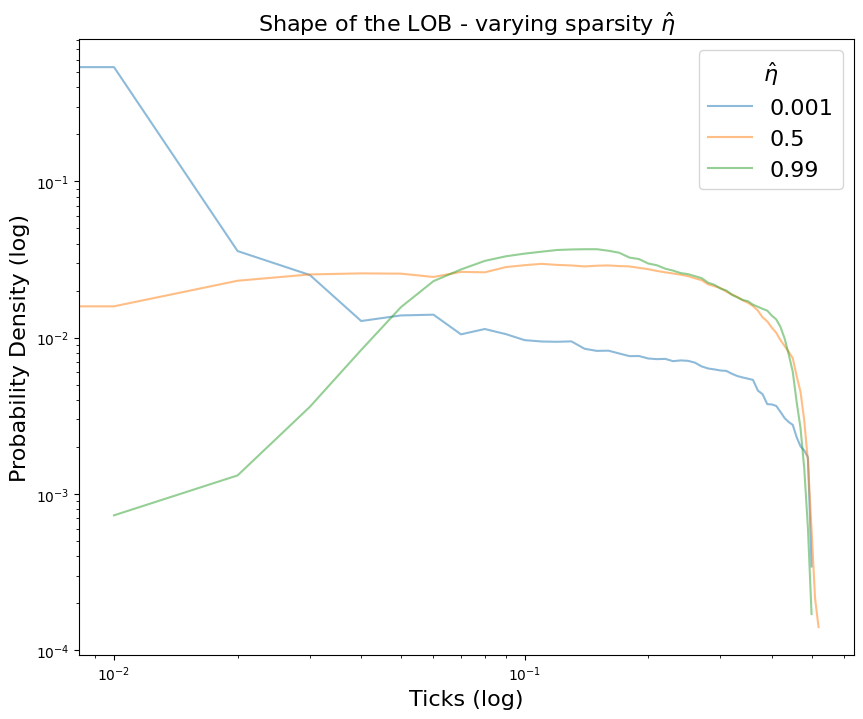

In [11]:

plt.figure(figsize=(10,8))
for volumes , label in zip(volumes_1, ['0.001', '0.5', '0.99']):
    dict_shape = {}
    for v in volumes:
        dists = np.array(v)[:,0]
        vols =  np.array(v)[:,1]
        for d, vol in zip(dists,vols):
            dict_shape[np.round(d, decimals=2)] = dict_shape.get(np.round(d, decimals=2), 0) + vol
    dist = np.sort(list(dict_shape.keys()))
    vol = np.array([dict_shape[d] for d in dist])
    vol = vol/vol.sum()
    plt.plot(np.array(dist)[vol > 1e-4 ], vol[vol > 1e-4], label = label, alpha=0.5) 
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right', title = '$\hat{\eta}$', fontsize=16, title_fontsize=16)
plt.ylabel('Probability Density (log)', fontsize=16)
plt.title('Shape of the LOB - varying sparsity $\hat{\eta}$', fontsize=16)
plt.xlabel('Ticks (log)', fontsize=16)
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/ergStudy_eta_shape.png')

# Assumptions Evidence

In [127]:
with open("/SAN/fca/Konark_PhD_Experiments/smallTick/CHTR_EDA_assumptions", 'rb') as f:
    res = pickle.load(f)

## cond / uncond prod 

In [ ]:
orderDict = {10:'LO', 11:'IS', 30: 'CO', 40:'MO'}
for s in stocks:
    try:
        with open("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_EDA_assumptions", 'rb') as f:
            res = pickle.load(f)
    except:
        continue
    uncond = res['uncondCounts_mT'].reset_index()
    uncond['Type'] = uncond['Type_mT'].apply(lambda x: orderDict[int(x[:2])])
    uncond['mT'] = uncond['Type_mT'].apply(lambda x: np.abs(int(x[2:])))
    #raw = uncond.groupby('mT')['Time'].sum()/uncond['Time'].sum()
    #raw['cat'] = raw['mT'].apply(lambda x: categories[np.searchsorted(categories, x)])
    #raw = raw.groupby('cat')['Time'].sum()
    uncond['Time'] = uncond['Time']/uncond['Time'].sum()
    df = res['uncondCounts_mT']/res['uncondCounts_mT'].sum()
    df = df[df>1e-4].reset_index()
    df['mT'] = df['Type_mT'].apply(lambda x: int(x[2:]))
    depthMax = df['mT'].max()
    depthMin = df['mT'].min()
    categories = np.logspace(np.log(depthMin)/np.log(10),np.log(depthMax)/np.log(10), 50) #np.append(-1*np.logspace(np.log(depthMax)/np.log(10),0,50), np.append([0],np.logspace(0,np.log(depthMax)/np.log(10), 50)))
    categories =np.unique(categories.astype(int))
    #categories = np.arange(1,40,5)
    cat_names = np.append(categories, ['>'+str(categories[-1])]) #['<=1','(1,100]','(100,200]','(200,500]','(500,1000]', '(1000,2000]', '>2000']
    uncond['cat'] = uncond['mT'].apply(lambda x: cat_names[np.searchsorted(categories, x)])
    uncond = ((uncond.groupby(['Type','cat'])['Time'].sum()/uncond.groupby(['Type'])['Time'].sum())/uncond.groupby(['cat'])['Time'].sum()).reset_index()
    uncond.columns = ['OrderType','$m_T$','Probability Ratio']
    df = uncond
    dfp = df.pivot_table(index='$m_T$', columns='OrderType', values=['Probability Ratio'], aggfunc='sum')
    dfp = dfp.reindex(index=cat_names)
    plt.figure()
    #plt.title(s + ' independence mT')
    dfp.plot(kind='bar', subplots=True, rot=90, figsize=(18, 6), layout=(1, 4), title= s + ' $m_T$ vs $\\frac{P(e, m_T)}{P(e)P(m_T)}$', ylabel = 'Probability Ratio')
    #plt.yscale('log')
    plt.tight_layout()
    plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_independence_m_T.png")

In [ ]:
orderDict = {10:'LO', 11:'IS', 30: 'CO', 40:'MO'}
for s in stocks:
    try:
        with open("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_EDA_assumptions", 'rb') as f:
            res = pickle.load(f)
    except:
        continue
    uncond = res['uncondCounts_mD'].reset_index()
    uncond['Type'] = uncond['Type_mD'].apply(lambda x: orderDict[int(x[:2])])
    uncond['mD'] = uncond['Type_mD'].apply(lambda x: np.abs(int(x[2:])))
    #raw = uncond.groupby('mD')['Time'].sum()/uncond['Time'].sum()
    #raw['cat'] = raw['mD'].apply(lambda x: categories[np.searchsorted(categories, x)])
    #raw = raw.groupby('cat')['Time'].sum()
    uncond['Time'] = uncond['Time']/uncond['Time'].sum()
    df = res['uncondCounts_mD']/res['uncondCounts_mD'].sum()
    df = df[df>1e-4].reset_index()
    df['mD'] = df['Type_mD'].apply(lambda x: 1+int(x[2:]))
    depthMax = df['mD'].max()
    depthMin = df['mD'].min()
    categories = np.logspace(np.log(depthMin)/np.log(10),np.log(depthMax)/np.log(10), 50) #np.append(-1*np.logspace(np.log(depthMax)/np.log(10),0,50), np.append([0],np.logspace(0,np.log(depthMax)/np.log(10), 50)))
    categories =np.unique(categories.astype(int))
    #categories = np.arange(1,40,5)
    cat_names = np.append(categories, ['>'+str(categories[-1])]) #['<=1','(1,100]','(100,200]','(200,500]','(500,1000]', '(1000,2000]', '>2000']
    uncond['cat'] = uncond['mD'].apply(lambda x: cat_names[np.searchsorted(categories, x)])
    uncond = ((uncond.groupby(['Type','cat'])['Time'].sum()/uncond.groupby(['Type'])['Time'].sum())/uncond.groupby(['cat'])['Time'].sum()).reset_index()
    uncond.columns = ['OrderType','$m_D$','Probability Ratio']
    df = uncond
    dfp = df.pivot_table(index='$m_D$', columns='OrderType', values=['Probability Ratio'], aggfunc='sum')
    dfp = dfp.reindex(index=cat_names)
    plt.figure()
    #plt.title(s + ' independence mD')
    dfp.plot(kind='bar', subplots=True, rot=90, figsize=(18, 6), layout=(1, 4), title= s + ' $m_D$ vs $\\frac{P(e, m_D)}{P(e)P(m_D)}$', ylabel = 'Probability Ratio')
    #plt.yscale('log')
    plt.tight_layout()
    plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_independence_m_D.png")

/tmp/ipykernel_53838/1756392955.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

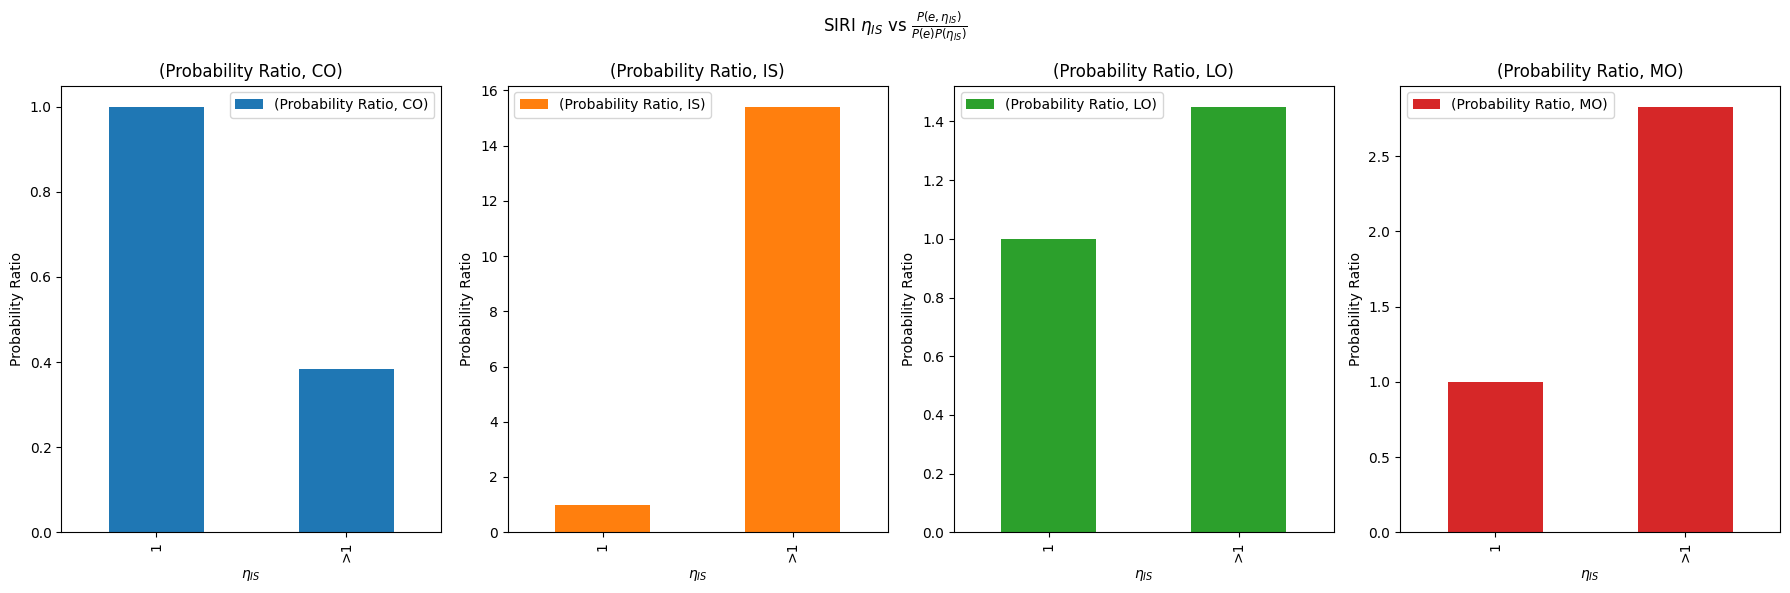

<Figure size 640x480 with 0 Axes>

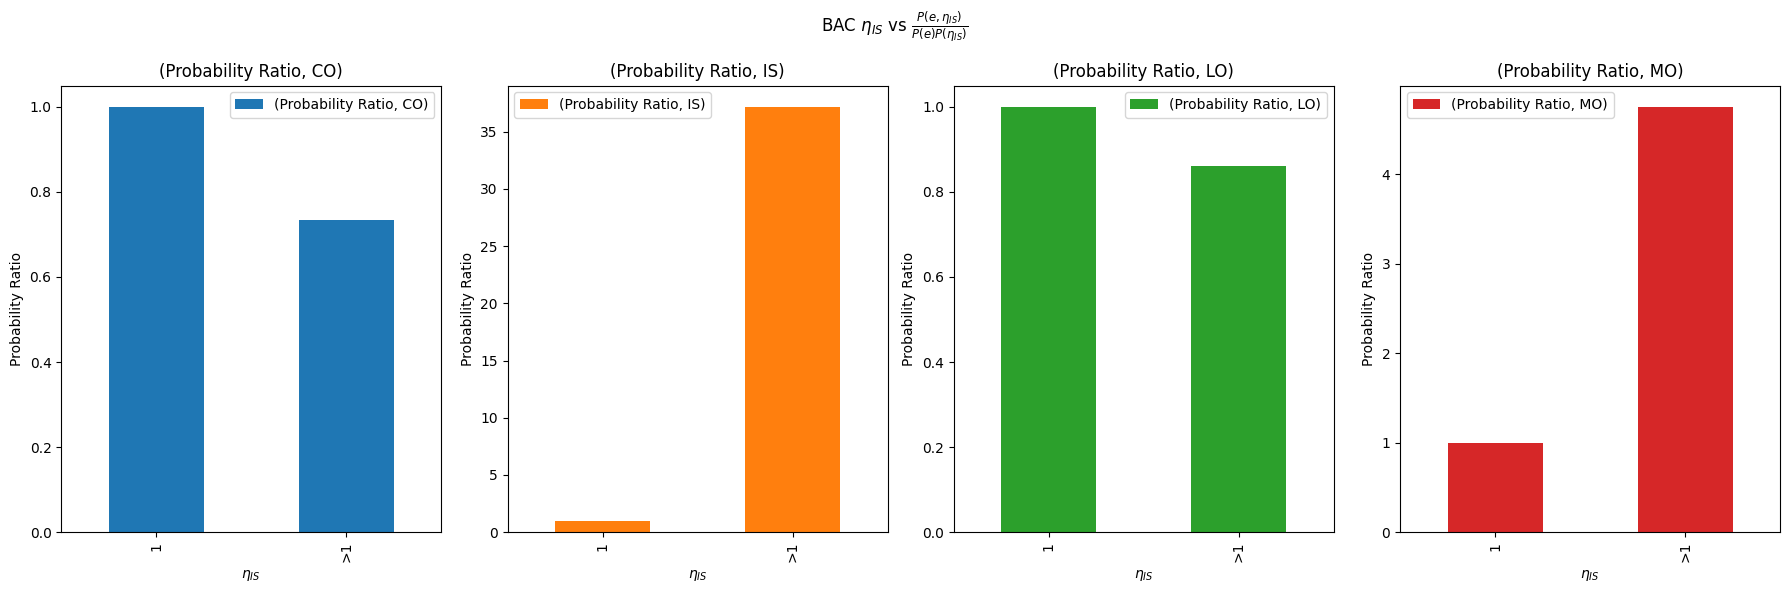

<Figure size 640x480 with 0 Axes>

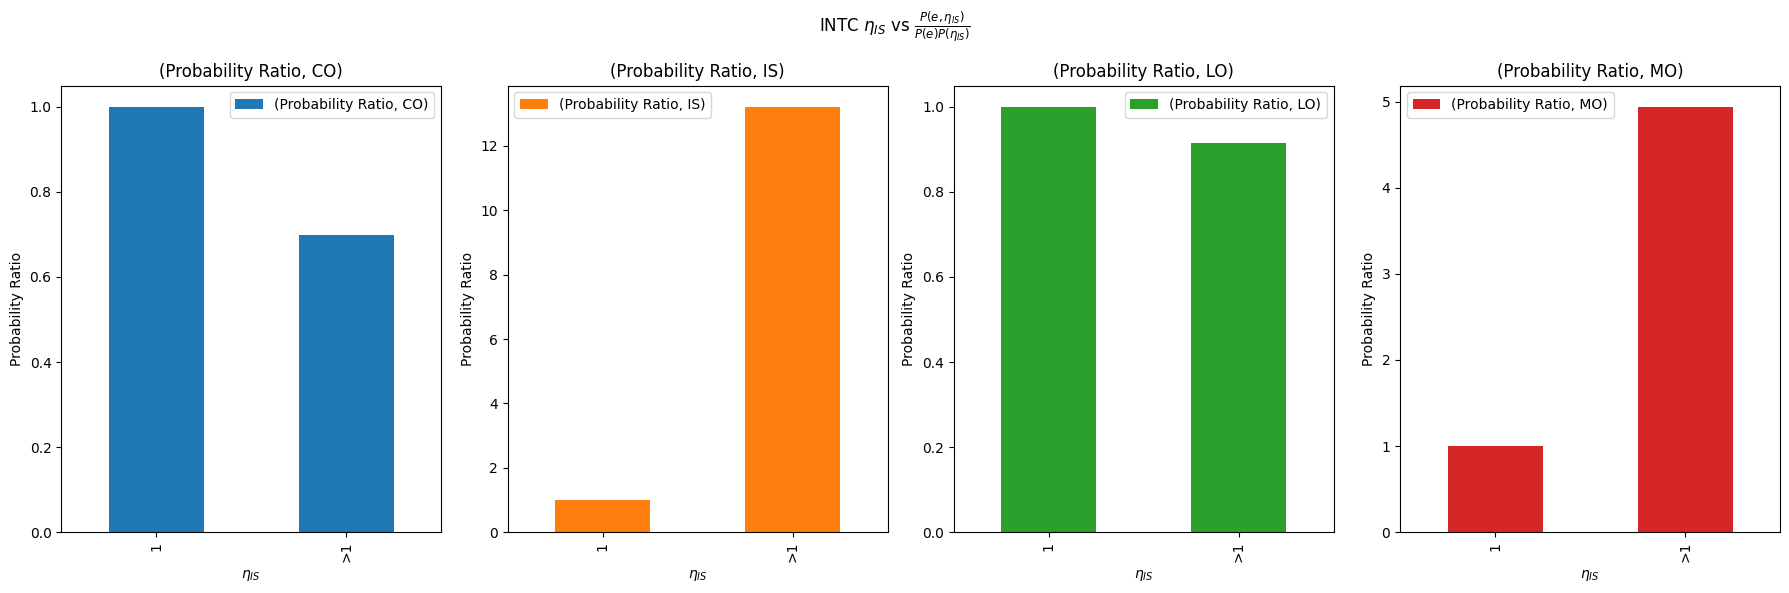

<Figure size 640x480 with 0 Axes>

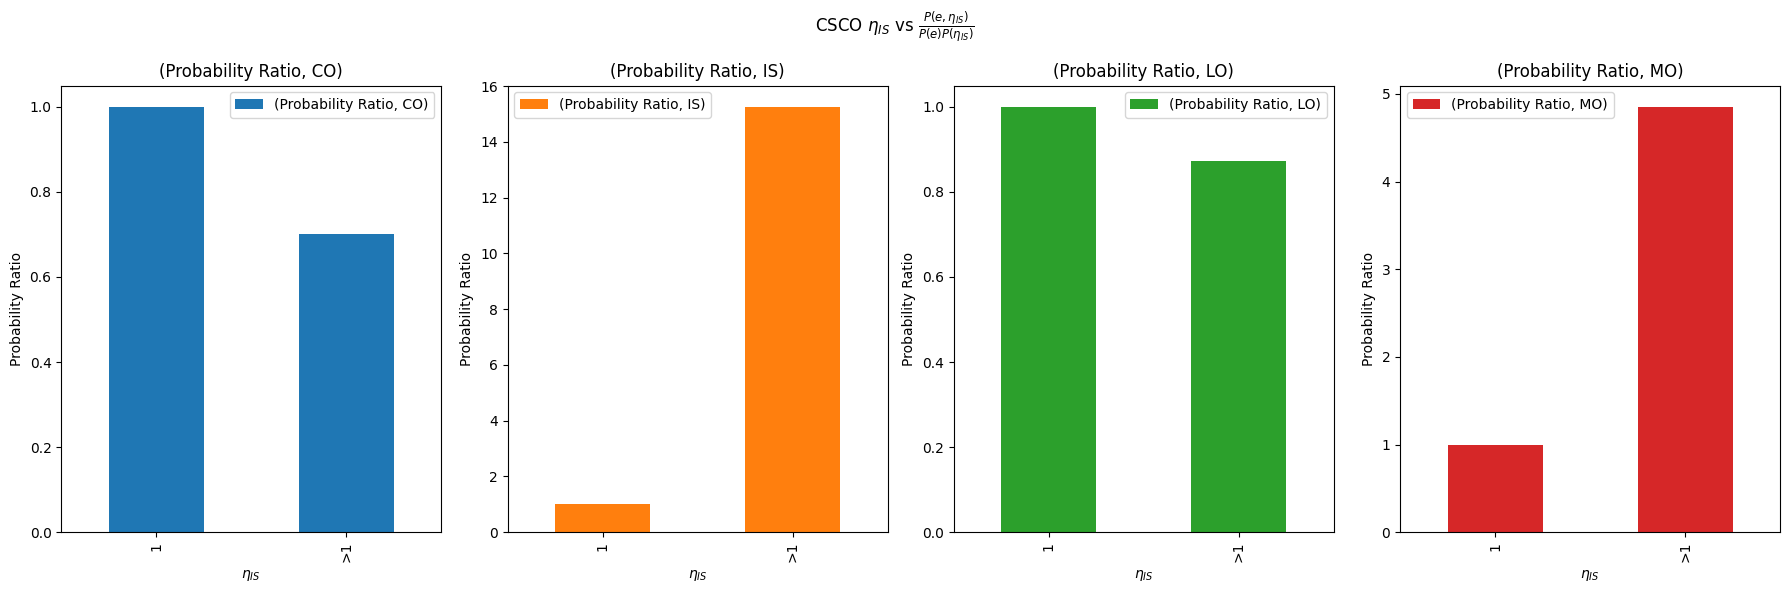

<Figure size 640x480 with 0 Axes>

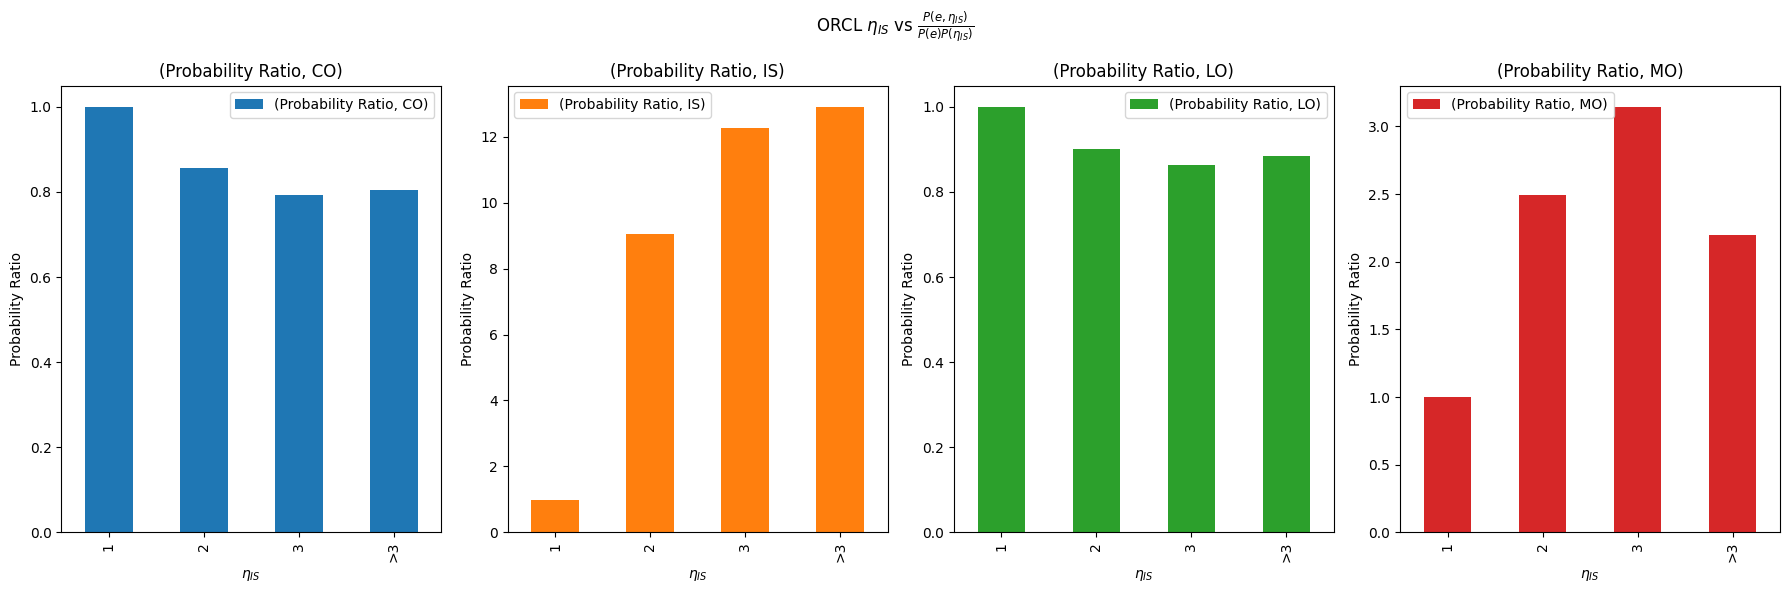

<Figure size 640x480 with 0 Axes>

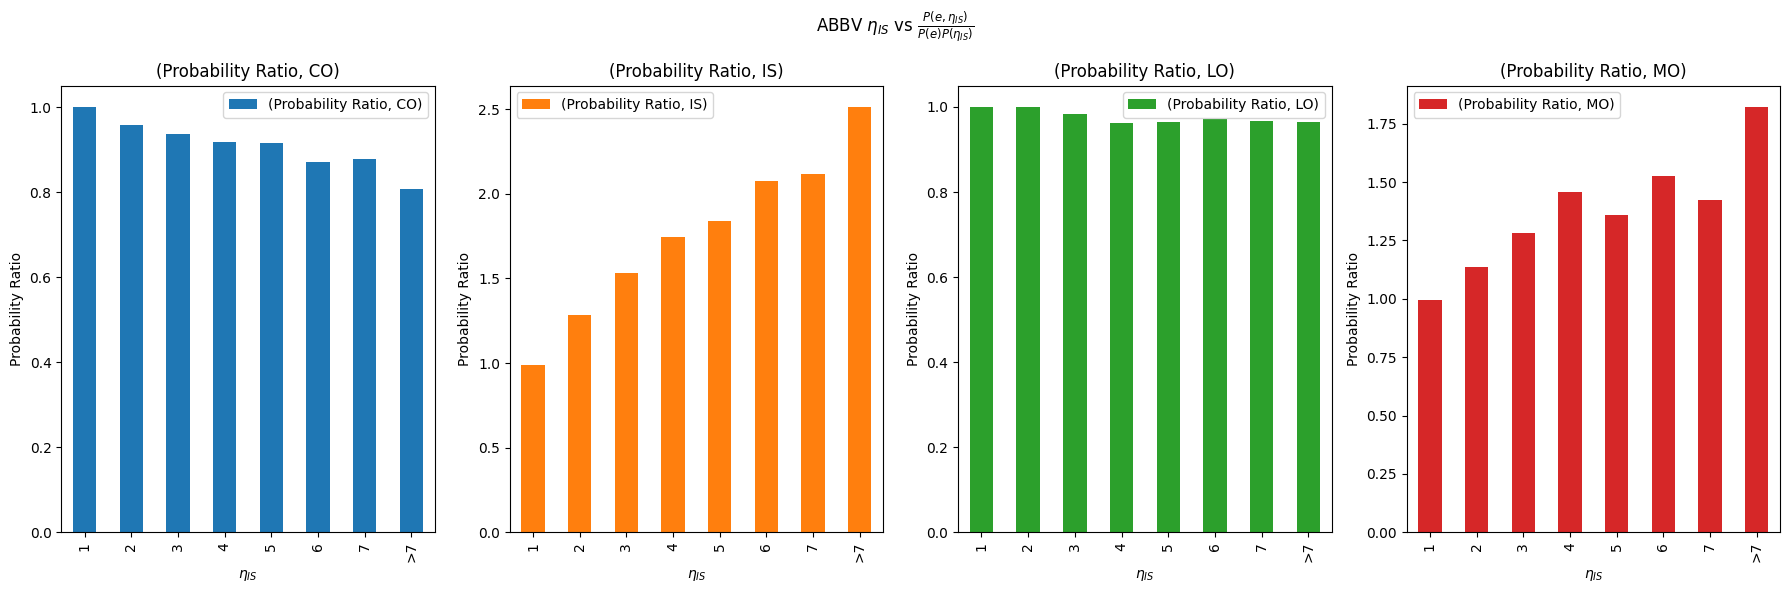

<Figure size 640x480 with 0 Axes>

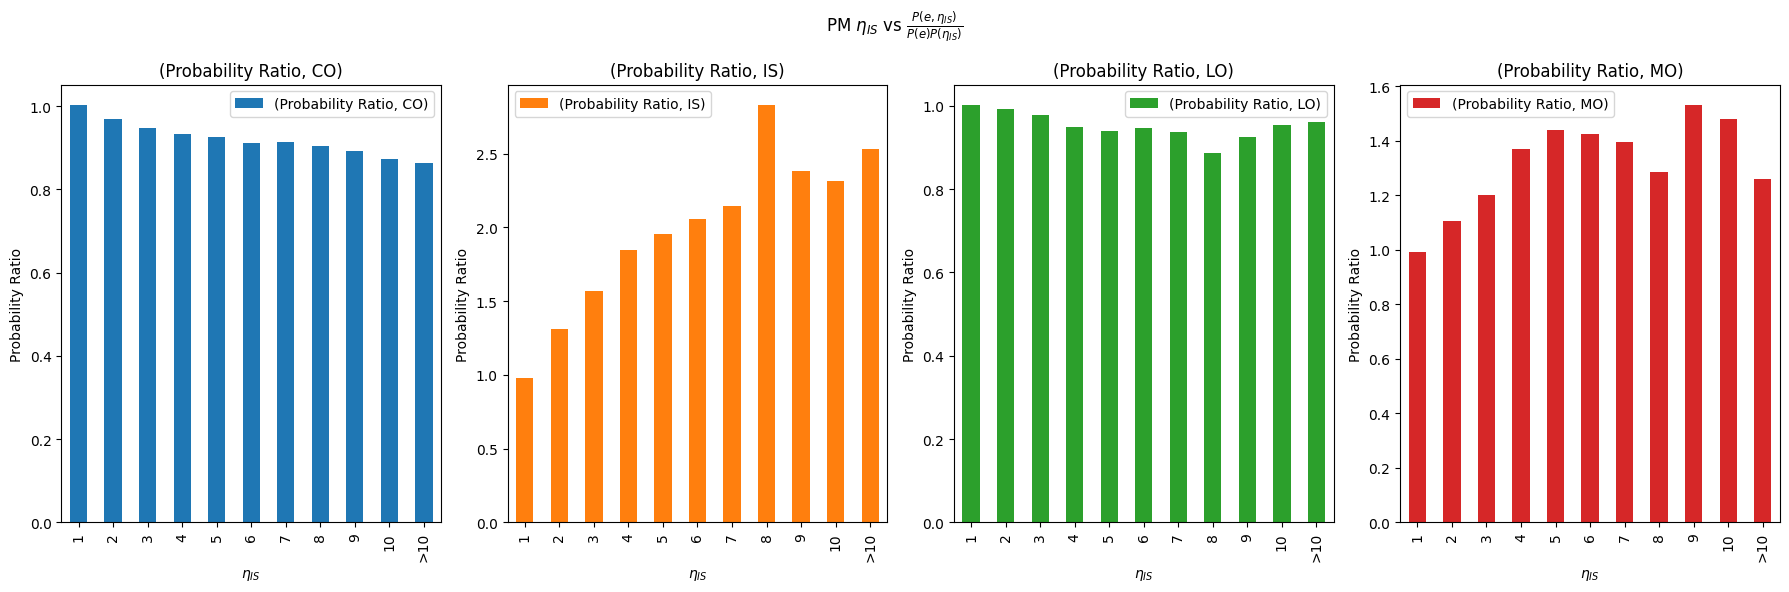

<Figure size 640x480 with 0 Axes>

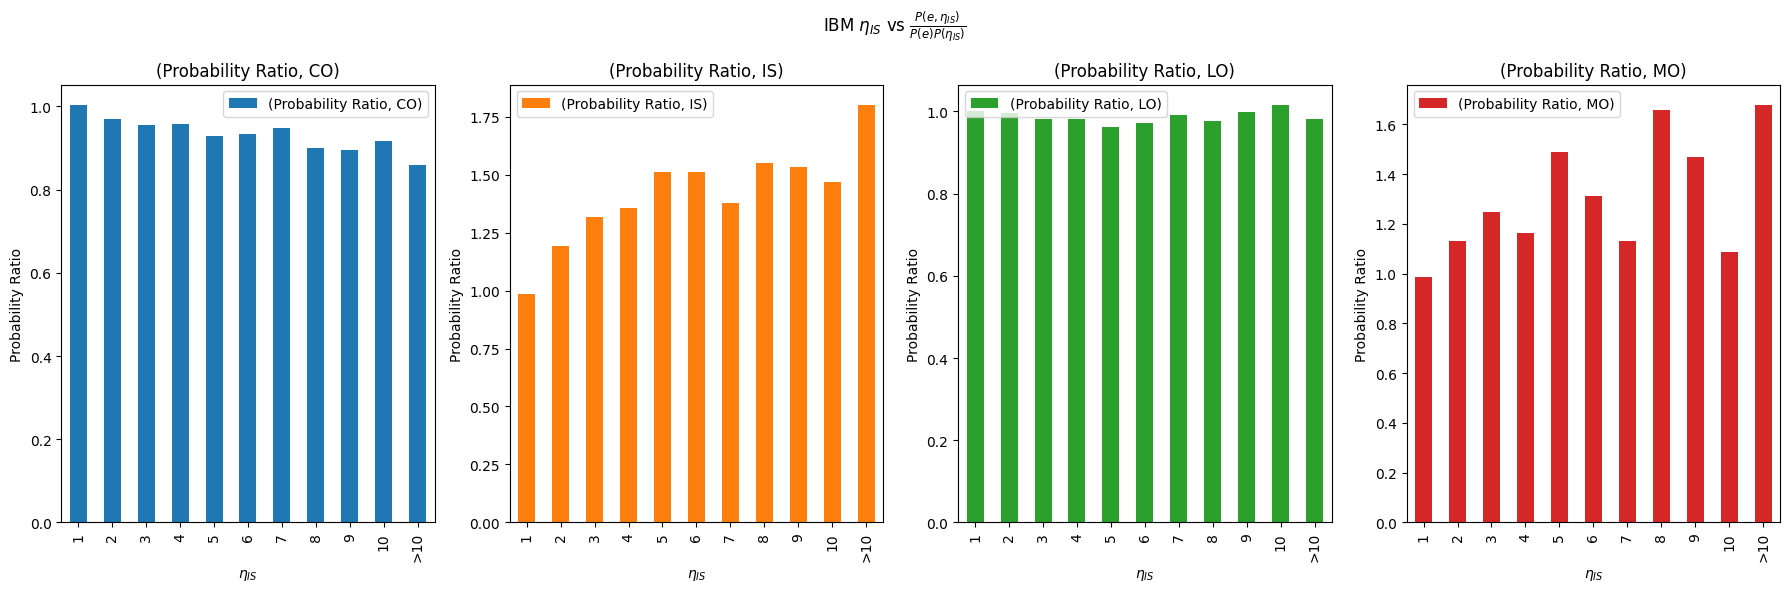

<Figure size 640x480 with 0 Axes>

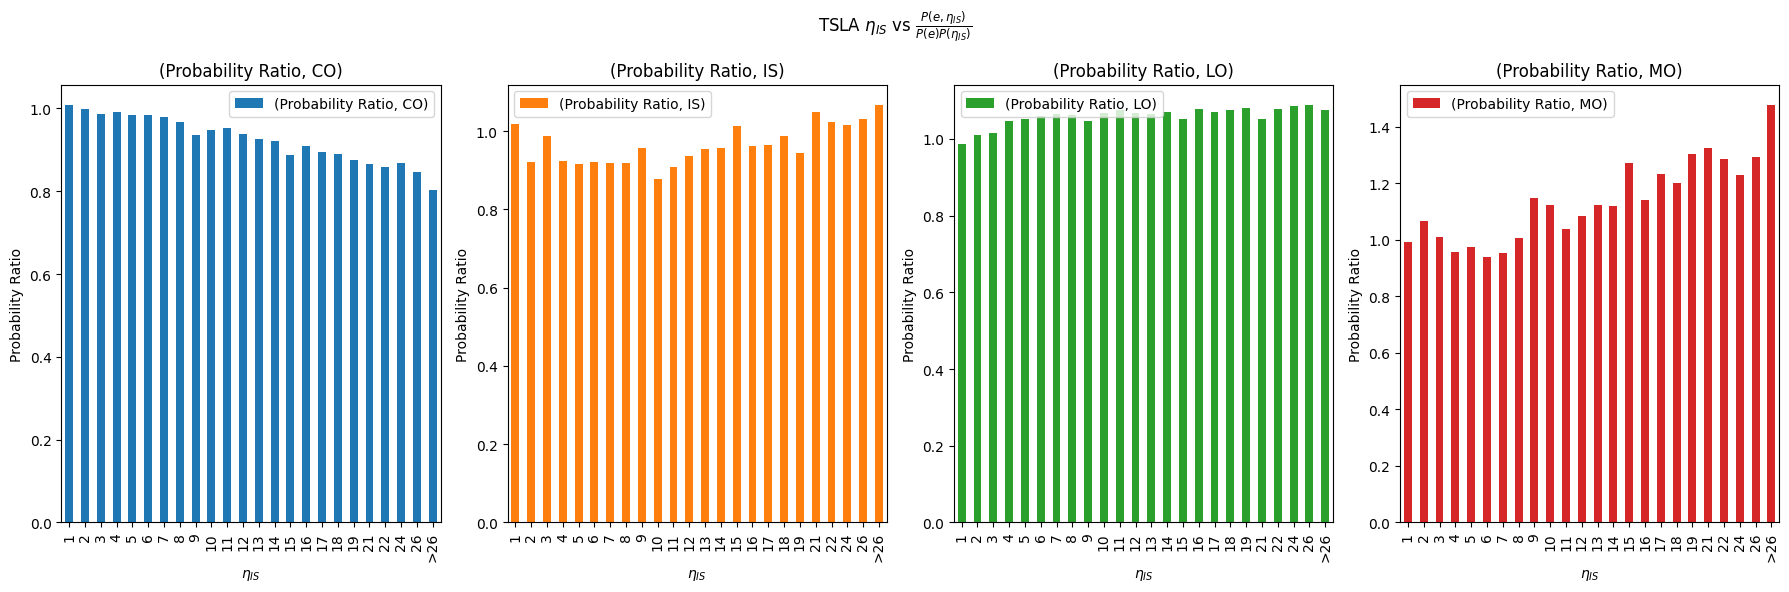

<Figure size 640x480 with 0 Axes>

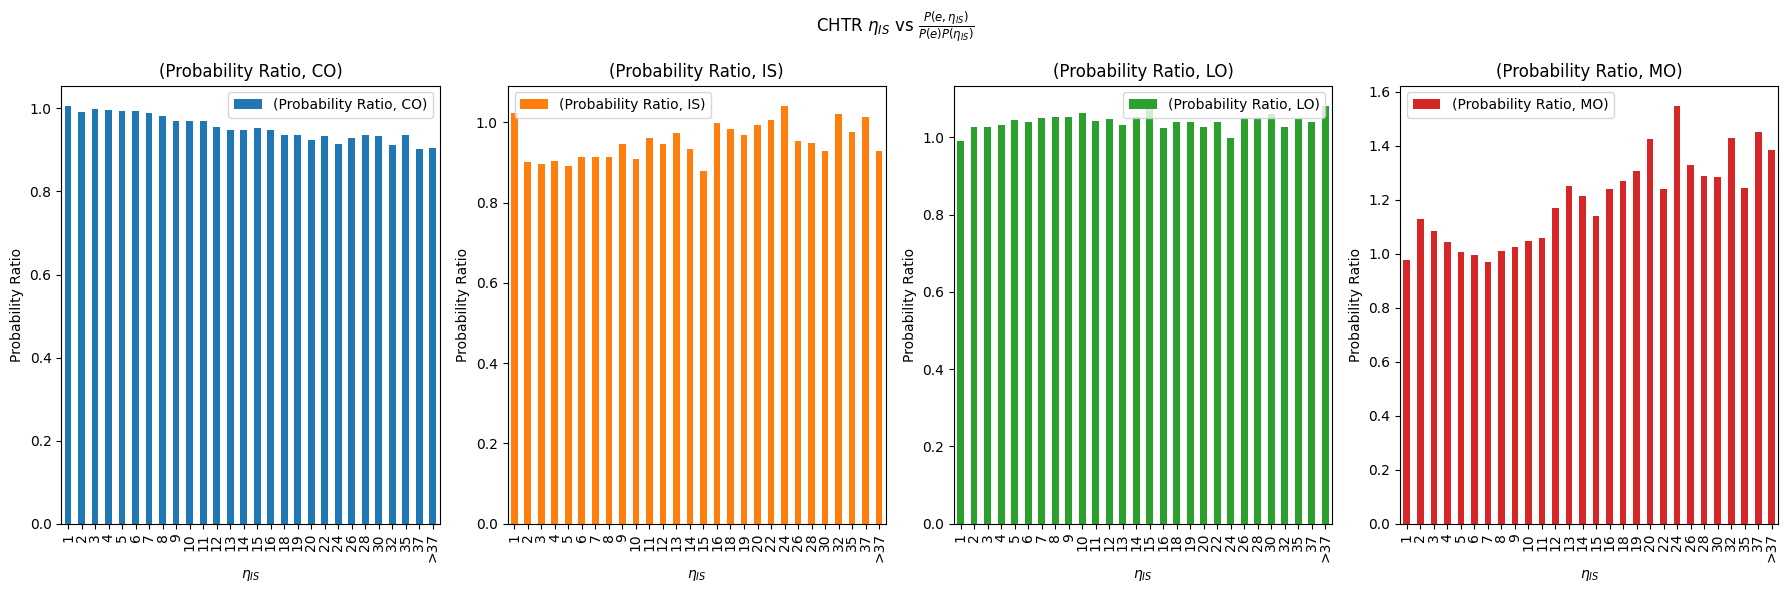

<Figure size 640x480 with 0 Axes>

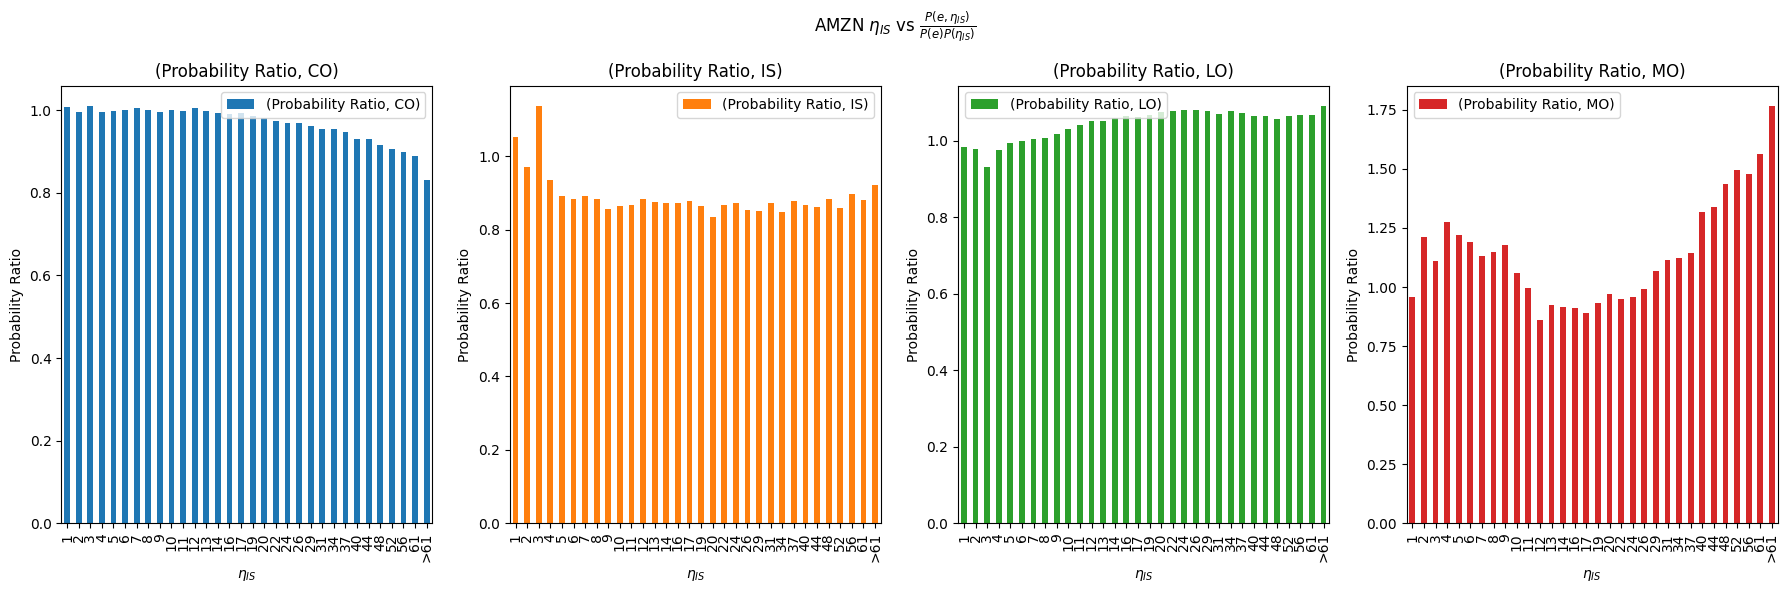

<Figure size 640x480 with 0 Axes>

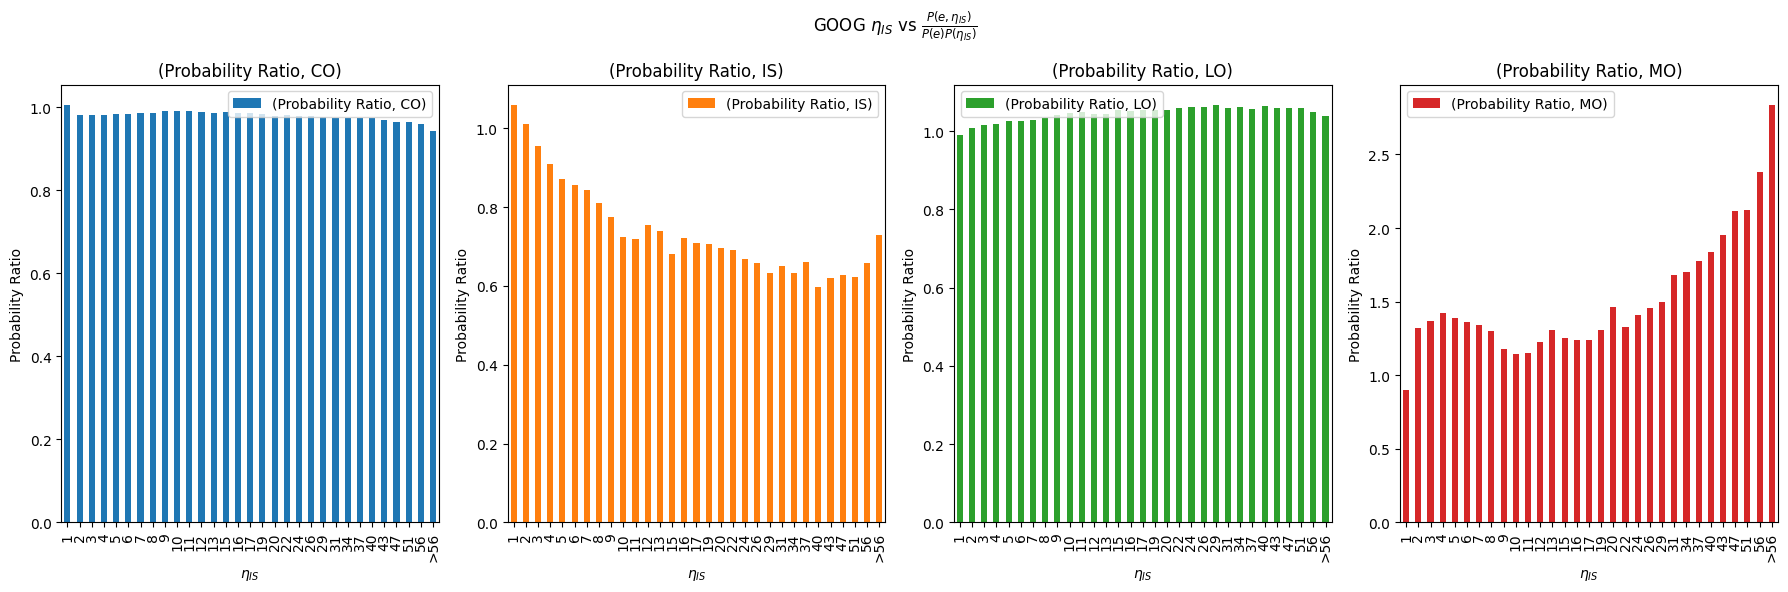

<Figure size 640x480 with 0 Axes>

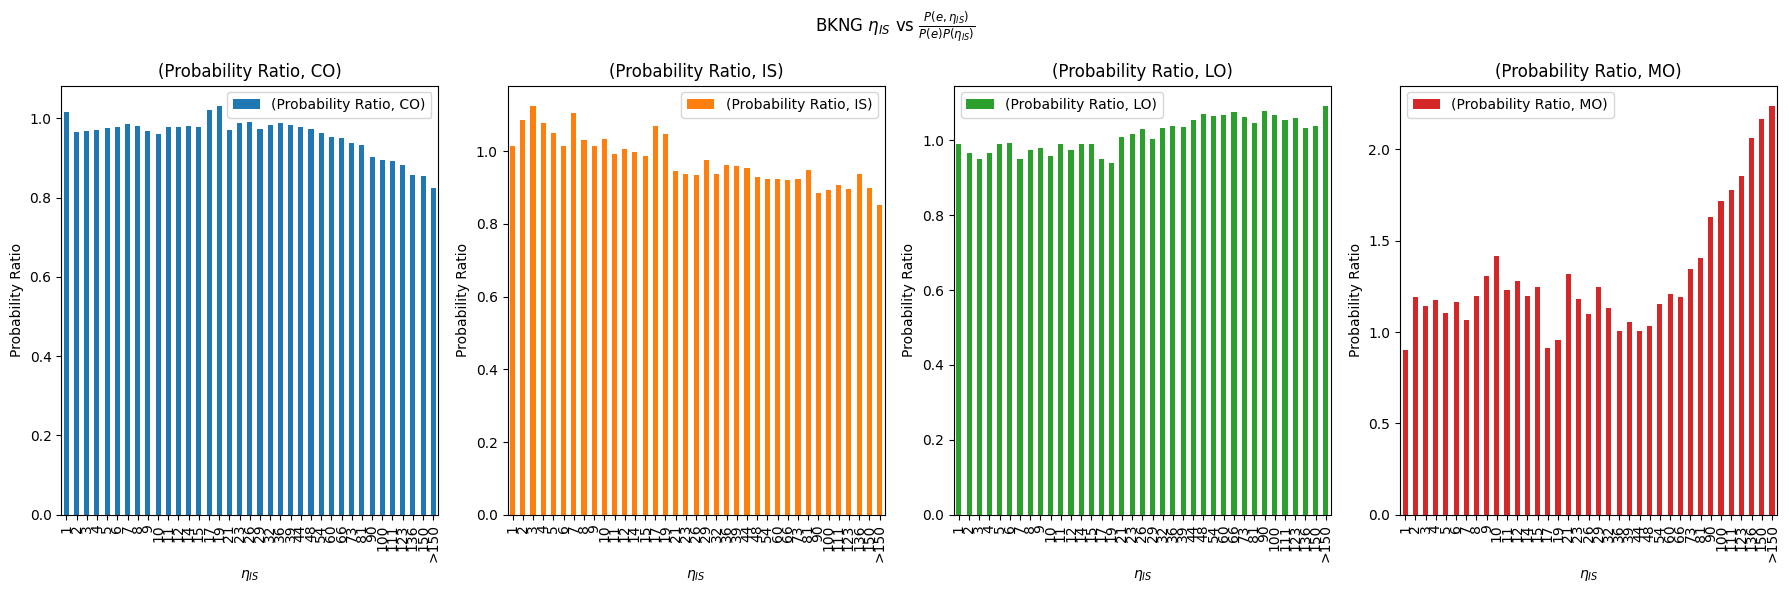

In [123]:
orderDict = {10:'LO', 11:'IS', 30: 'CO', 40:'MO'}
for s in stocks:
    try:
        with open("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_EDA_assumptions", 'rb') as f:
            res = pickle.load(f)
    except:
        continue
    uncond = res['uncondCounts_eta_is'].reset_index()
    uncond['Type'] = uncond['Type_eta_is'].apply(lambda x: orderDict[int(x[:2])])
    uncond['eta_is'] = uncond['Type_eta_is'].apply(lambda x: np.abs(int(x[2:])))
    #raw = uncond.groupby('eta_is')['Time'].sum()/uncond['Time'].sum()
    #raw['cat'] = raw['eta_is'].apply(lambda x: categories[np.searchsorted(categories, x)])
    #raw = raw.groupby('cat')['Time'].sum()
    uncond['Time'] = uncond['Time']/uncond['Time'].sum()
    df = res['uncondCounts_eta_is']/res['uncondCounts_eta_is'].sum()
    df = df[df>1e-4].reset_index()
    df['eta_is'] = df['Type_eta_is'].apply(lambda x: 1+int(x[2:]))
    depthMax = df['eta_is'].max()
    depthMin = df['eta_is'].min()
    categories = np.logspace(np.log(depthMin)/np.log(10),np.log(depthMax)/np.log(10), 50) #np.append(-1*np.logspace(np.log(depthMax)/np.log(10),0,50), np.append([0],np.logspace(0,np.log(depthMax)/np.log(10), 50)))
    categories =np.unique(categories.astype(int))
    #categories = np.arange(1,40,5)
    cat_names = np.append(categories, ['>'+str(categories[-1])]) #['<=1','(1,100]','(100,200]','(200,500]','(500,1000]', '(1000,2000]', '>2000']
    uncond['cat'] = uncond['eta_is'].apply(lambda x: cat_names[np.searchsorted(categories, x)])
    uncond = ((uncond.groupby(['Type','cat'])['Time'].sum()/uncond.groupby(['Type'])['Time'].sum())/uncond.groupby(['cat'])['Time'].sum()).reset_index()
    uncond.columns = ['OrderType','$\\eta_{IS}$','Probability Ratio']
    df = uncond
    dfp = df.pivot_table(index='$\\eta_{IS}$', columns='OrderType', values=['Probability Ratio'], aggfunc='sum')
    dfp = dfp.reindex(index=cat_names)
    plt.figure()
    #plt.title(s + ' independence eta_is')
    dfp.plot(kind='bar', subplots=True, rot=90, figsize=(18, 6), layout=(1, 4), title= s + ' $\\eta_{IS}$ vs $\\frac{P(e, \\eta_{IS})}{P(e)P(\\eta_{IS})}$', ylabel = 'Probability Ratio')
    #plt.yscale('log')
    plt.tight_layout()
    plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_independence_eta_IS.png")

In [ ]:
orderDict = {10:'LO', 11:'IS', 30: 'CO', 40:'MO'}
for s in stocks:
    try:
        with open("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_EDA_assumptions", 'rb') as f:
            res = pickle.load(f)
    except:
        continue
    uncond = res['uncondCounts_q_LO'].reset_index()
    uncond['Type'] = uncond['Type_q_LO'].apply(lambda x: orderDict[int(x[:2])])
    uncond['q_LO'] = uncond['Type_q_LO'].apply(lambda x: np.abs(int(x[2:])))
    #raw = uncond.groupby('q_LO')['Time'].sum()/uncond['Time'].sum()
    #raw['cat'] = raw['q_LO'].apply(lambda x: categories[np.searchsorted(categories, x)])
    #raw = raw.groupby('cat')['Time'].sum()
    uncond['Time'] = uncond['Time']/uncond['Time'].sum()
    df = res['uncondCounts_q_LO']/res['uncondCounts_q_LO'].sum()
    df = df[df>1e-4].reset_index()
    df['q_LO'] = df['Type_q_LO'].apply(lambda x: 1+int(x[2:]))
    depthMax = df['q_LO'].max()
    depthMin = df['q_LO'].min()
    categories = np.logspace(np.log(depthMin)/np.log(10),np.log(depthMax)/np.log(10), 50) #np.append(-1*np.logspace(np.log(depthMax)/np.log(10),0,50), np.append([0],np.logspace(0,np.log(depthMax)/np.log(10), 50)))
    categories =np.unique(categories.astype(int))
    #categories = np.arange(1,40,5)
    cat_names = np.append(categories, ['>'+str(categories[-1])]) #['<=1','(1,100]','(100,200]','(200,500]','(500,1000]', '(1000,2000]', '>2000']
    uncond['cat'] = uncond['q_LO'].apply(lambda x: cat_names[np.searchsorted(categories, x)])
    uncond = ((uncond.groupby(['Type','cat'])['Time'].sum()/uncond.groupby(['Type'])['Time'].sum())/uncond.groupby(['cat'])['Time'].sum()).reset_index()
    uncond.columns = ['OrderType','$\\kappa_{LO}$','Probability Ratio']
    df = uncond
    dfp = df.pivot_table(index='$\\kappa_{LO}$', columns='OrderType', values=['Probability Ratio'], aggfunc='sum')
    dfp = dfp.reindex(index=cat_names)
    plt.figure()
    #plt.title(s + ' independence q_LO')
    dfp.plot(kind='bar', subplots=True, rot=90, figsize=(18, 6), layout=(1, 4), title= s + ' $\\kappa_{LO}$ vs $\\frac{P(e, \\kappa_{LO})}{P(e)P(\\kappa_{LO})}$', ylabel = 'Probability Ratio')
    #plt.yscale('log')
    plt.tight_layout()
    plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_independence_q_LO.png")

In [ ]:
orderDict = {10:'LO', 11:'IS', 30: 'CO', 40:'MO'}
for s in stocks:
    try:
        with open("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_EDA_assumptions", 'rb') as f:
            res = pickle.load(f)
    except:
        continue
    uncond = res['uncondCounts_q_MO'].reset_index()
    uncond['Type'] = uncond['Type_q_MO'].apply(lambda x: orderDict[int(x[:2])])
    uncond['q_MO'] = uncond['Type_q_MO'].apply(lambda x: np.abs(int(x[2:])))
    #raw = uncond.groupby('q_MO')['Time'].sum()/uncond['Time'].sum()
    #raw['cat'] = raw['q_MO'].apply(lambda x: categories[np.searchsorted(categories, x)])
    #raw = raw.groupby('cat')['Time'].sum()
    uncond['Time'] = uncond['Time']/uncond['Time'].sum()
    df = res['uncondCounts_q_MO']/res['uncondCounts_q_MO'].sum()
    df = df[df>1e-4].reset_index()
    df['q_MO'] = df['Type_q_MO'].apply(lambda x: 1+int(x[2:]))
    depthMax = df['q_MO'].max()
    depthMin = df['q_MO'].min()
    categories = np.logspace(np.log(depthMin)/np.log(10),np.log(depthMax)/np.log(10), 50) #np.append(-1*np.logspace(np.log(depthMax)/np.log(10),0,50), np.append([0],np.logspace(0,np.log(depthMax)/np.log(10), 50)))
    categories =np.unique(categories.astype(int))
    #categories = np.arange(1,40,5)
    cat_names = np.append(categories, ['>'+str(categories[-1])]) #['<=1','(1,100]','(100,200]','(200,500]','(500,1000]', '(1000,2000]', '>2000']
    uncond['cat'] = uncond['q_MO'].apply(lambda x: cat_names[np.searchsorted(categories, x)])
    uncond = ((uncond.groupby(['Type','cat'])['Time'].sum()/uncond.groupby(['Type'])['Time'].sum())/uncond.groupby(['cat'])['Time'].sum()).reset_index()
    uncond.columns = ['OrderType','$\\kappa_{MO}$','Probability Ratio']
    df = uncond
    dfp = df.pivot_table(index='$\\kappa_{MO}$', columns='OrderType', values=['Probability Ratio'], aggfunc='sum')
    dfp = dfp.reindex(index=cat_names)
    plt.figure()
    #plt.title(s + ' independence q_MO')
    dfp.plot(kind='bar', subplots=True, rot=90, figsize=(18, 6), layout=(1, 4), title= s + ' $\\kappa_{MO}$ vs $\\frac{P(e, \\kappa_{MO})}{P(e)P(\\kappa_{MO})}$', ylabel = 'Probability Ratio')
    #plt.yscale('log')
    plt.tight_layout()
    plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_independence_q_MO.png")

<Figure size 640x480 with 0 Axes>

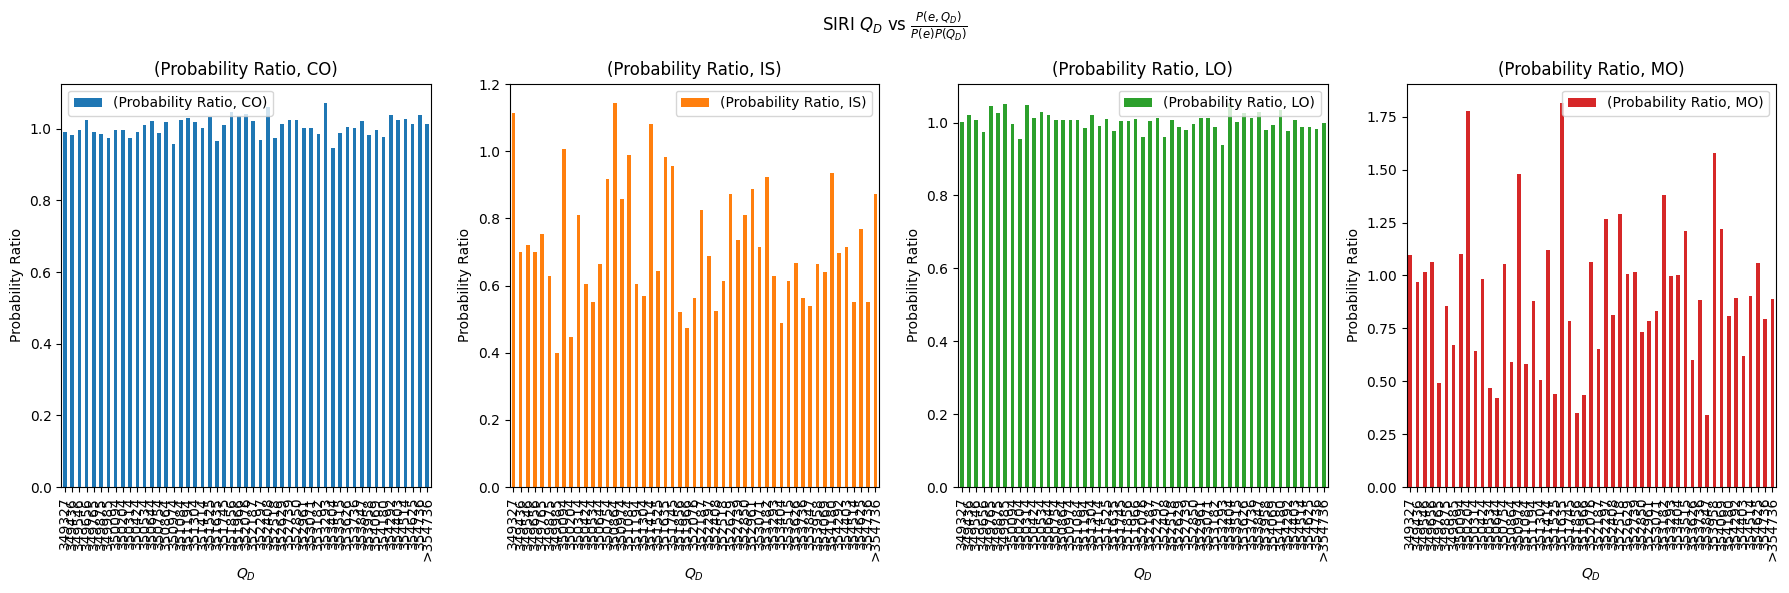

In [6]:
orderDict = {10:'LO', 11:'IS', 30: 'CO', 31: 'CO', 41: 'MO',40:'MO'}
for s in ['SIRI']:
    try:
        res = pd.read_csv("D:\\PhD\\results - small tick\\"+s+"_EDA_uncondCounts_qD.csv")
    except:
        continue
    uncond = res.reset_index()
    uncond['Type'] = uncond['Type_qD'].astype(str).apply(lambda x: orderDict[int(x[:2])])
    uncond['qD'] = uncond['Type_qD'].astype(str).apply(lambda x: np.abs(int(x[2:])))
    #raw = uncond.groupby('qD')['Time'].sum()/uncond['Time'].sum()
    #raw['cat'] = raw['qD'].apply(lambda x: categories[np.searchsorted(categories, x)])
    #raw = raw.groupby('cat')['Time'].sum()
    uncond['Time'] = uncond['Time']/uncond['Time'].sum()
    df = (res['Time']/res['Time'].sum()).to_frame()
    df['Type_qD'] = res['Type_qD']
    df = df[df['Time']>1e-4].reset_index()
    df['qD'] = df['Type_qD'].astype(str).apply(lambda x: 1+int(x[2:]))
    depthMax = np.percentile(df['qD'].values,90)
    depthMin = np.percentile(df['qD'].values,10)
    categories = np.logspace(np.log(depthMin)/np.log(10),np.log(depthMax)/np.log(10), 50) #np.append(-1*np.logspace(np.log(depthMax)/np.log(10),0,50), np.append([0],np.logspace(0,np.log(depthMax)/np.log(10), 50)))
    categories =np.unique(categories.astype(int))
    #categories = np.arange(1,40,5)
    cat_names = np.append(categories, ['>'+str(categories[-1])]) #['<=1','(1,100]','(100,200]','(200,500]','(500,1000]', '(1000,2000]', '>2000']
    uncond['cat'] = uncond['qD'].apply(lambda x: cat_names[np.searchsorted(categories, x)])
    uncond = ((uncond.groupby(['Type','cat'])['Time'].sum()/uncond.groupby(['Type'])['Time'].sum())/uncond.groupby(['cat'])['Time'].sum()).reset_index()
    uncond.columns = ['OrderType','$Q_D$','Probability Ratio']
    df = uncond
    dfp = df.pivot_table(index='$Q_D$', columns='OrderType', values=['Probability Ratio'], aggfunc='sum')
    dfp = dfp.reindex(index=cat_names)
    plt.figure()
    #plt.title(s + ' independence qD')
    dfp.plot(kind='bar', subplots=True, rot=90, figsize=(18, 6), layout=(1, 4), title= s + ' $Q_D$ vs $\\frac{P(e, Q_D)}{P(e)P(Q_D)}$', ylabel = 'Probability Ratio')
    #plt.yscale('log')
    plt.tight_layout()
    plt.savefig("D:\\PhD\\results - small tick\\"+s+"_independence_qD.png")

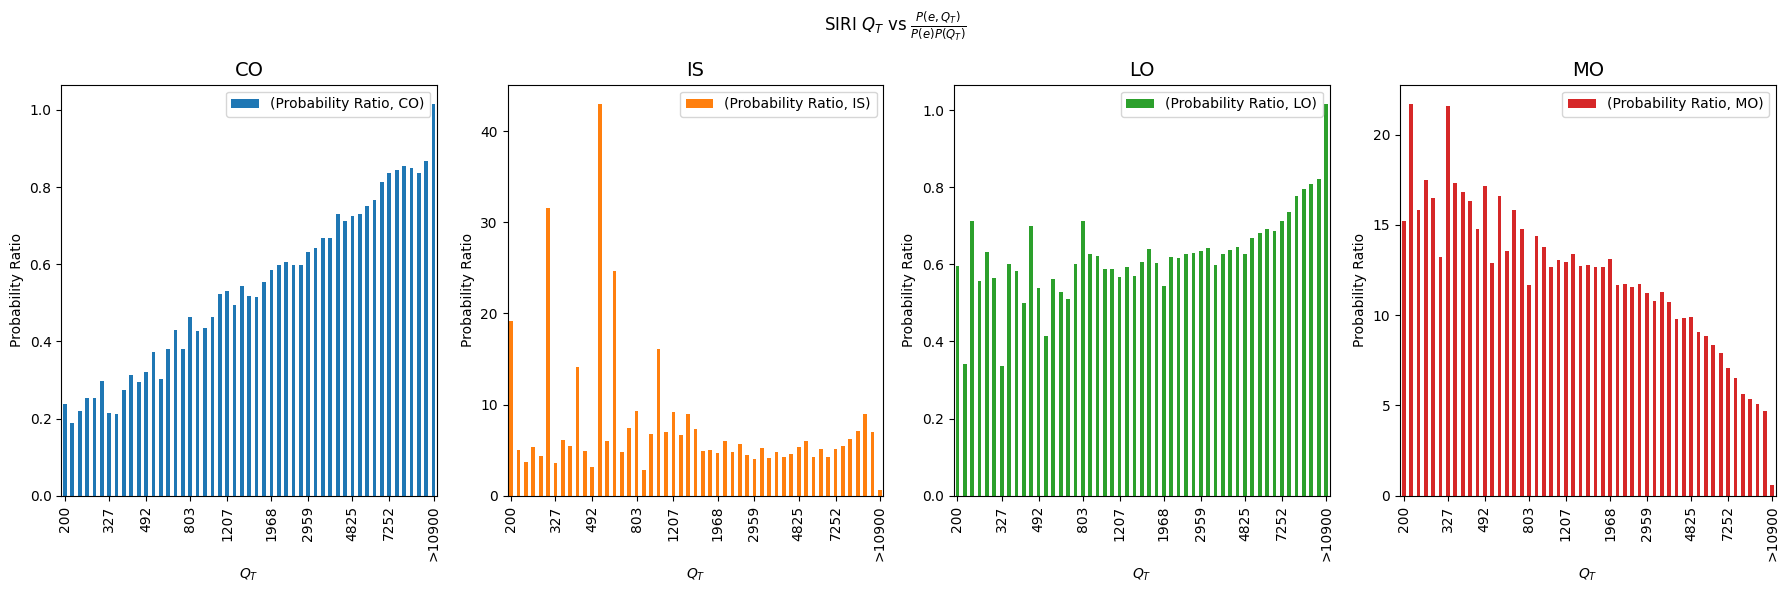

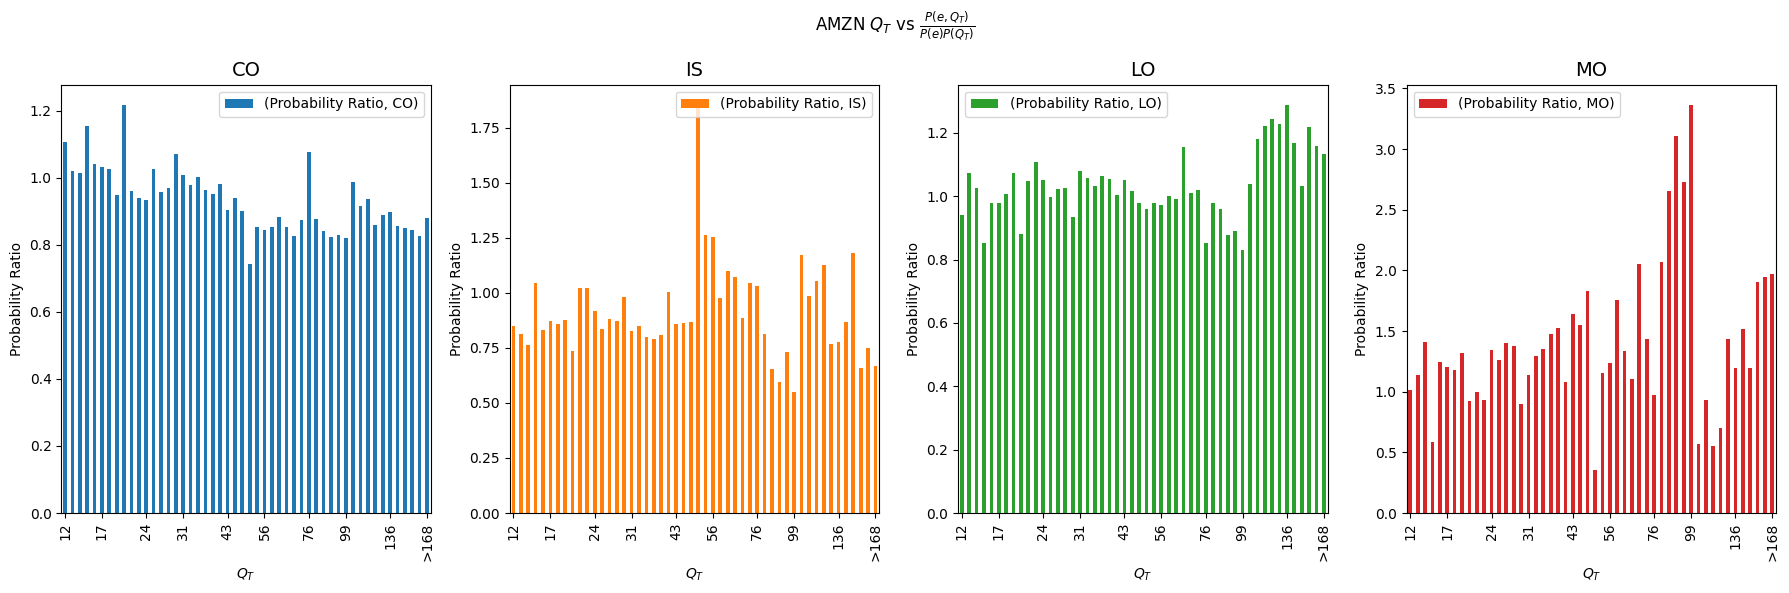

In [20]:
orderDict = {10:'LO', 11:'IS', 30: 'CO', 31: 'CO', 41: 'MO',40:'MO'}
for s in ['SIRI', 'AMZN']:
    try:
        res = pd.read_csv("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_EDA_uncondCounts_qT.csv")
    except:
        continue
    uncond = res.reset_index()
    uncond['Type'] = uncond['Type_qT'].astype(str).apply(lambda x: orderDict[int(x[:2])])
    uncond['qT'] = uncond['Type_qT'].astype(str).apply(lambda x: np.abs(int(x[2:])))
    #raw = uncond.groupby('qT')['Time'].sum()/uncond['Time'].sum()
    #raw['cat'] = raw['qT'].apply(lambda x: categories[np.searchsorted(categories, x)])
    #raw = raw.groupby('cat')['Time'].sum()
    uncond['Time'] = uncond['Time']/uncond['Time'].sum()
    df = (res['Time']/res['Time'].sum()).to_frame()
    df['Type_qT'] = res['Type_qT']
    df = df[df['Time']>1e-4].reset_index()
    df['qT'] = df['Type_qT'].astype(str).apply(lambda x: 1+int(x[2:]))
    depthMax = np.percentile(df['qT'].values,90)
    depthMin = np.percentile(df['qT'].values,10)
    categories = np.logspace(np.log(depthMin)/np.log(10),np.log(depthMax)/np.log(10), 50) #np.append(-1*np.logspace(np.log(depthMax)/np.log(10),0,50), np.append([0],np.logspace(0,np.log(depthMax)/np.log(10), 50)))
    categories =np.unique(categories.astype(int))
    #categories = np.arange(1,40,5)
    cat_names = np.append(categories, ['>'+str(categories[-1])]) #['<=1','(1,100]','(100,200]','(200,500]','(500,1000]', '(1000,2000]', '>2000']
    uncond['cat'] = uncond['qT'].apply(lambda x: cat_names[np.searchsorted(categories, x)])
    uncond = ((uncond.groupby(['Type','cat'])['Time'].sum()/uncond.groupby(['Type'])['Time'].sum())/uncond.groupby(['cat'])['Time'].sum()).reset_index()
    uncond.columns = ['OrderType','$Q_T$','Probability Ratio']
    df = uncond
    dfp = df.pivot_table(index='$Q_T$', columns='OrderType', values=['Probability Ratio'], aggfunc='sum')
    dfp = dfp.reindex(index=cat_names)
    idx = np.round(np.linspace(0, len(cat_names) - 1, 10)).astype(int)
    #plt.title(s + ' independence qT')
    axs = dfp.plot(kind='bar', subplots=True, rot=90, figsize=(18, 6), layout=(1, 4), title= s + ' $Q_T$ vs $\\frac{P(e, Q_T)}{P(e)P(Q_T)}$', ylabel = 'Probability Ratio', xticks = idx)
    for ax in axs[0]:
        ax.set_xticklabels( np.array(cat_names)[idx])
        ax.set_title(ax.title.get_text()[-3:-1], fontsize=14)
    #plt.yscale('log')
    plt.tight_layout()
    plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_independence_qT.png")

'(Probability Ratio, MO)'

## Leverage plots

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 22 24 26 28 30
 32 35 38 40]


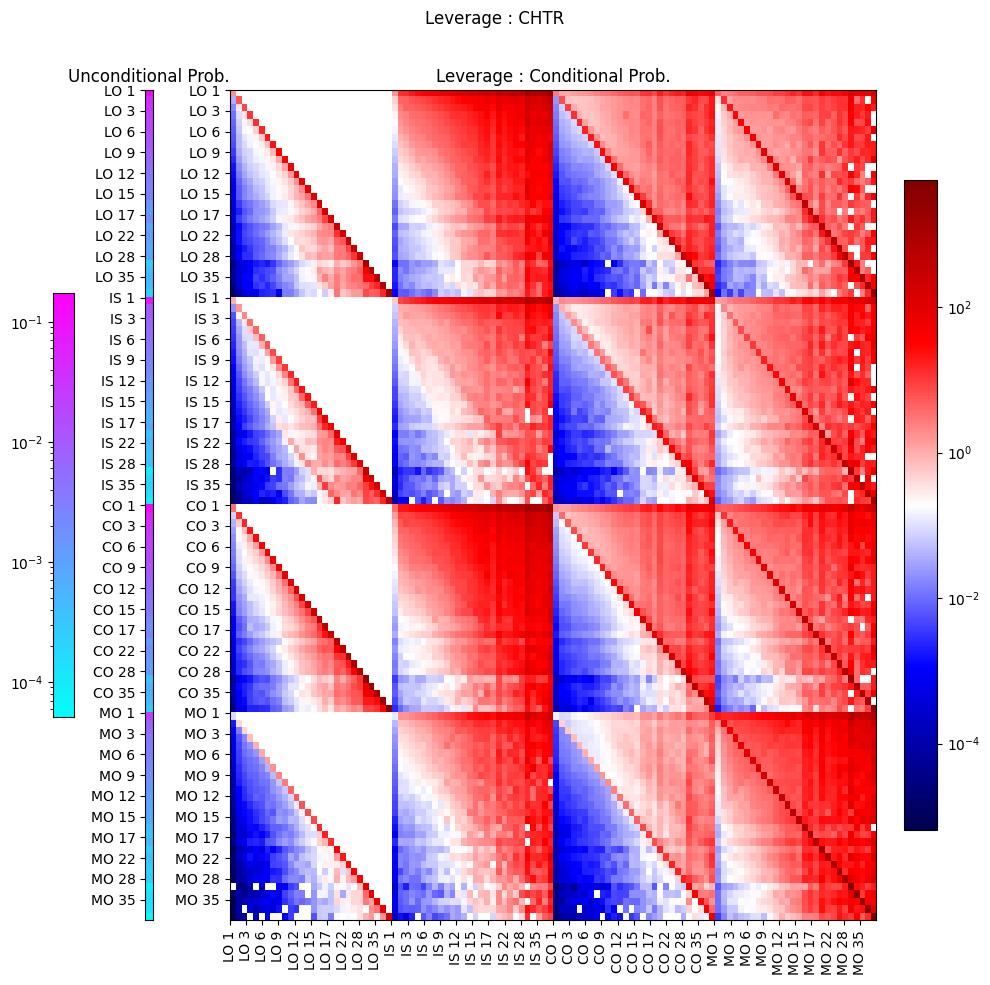

In [99]:
for s in ['CHTR']:
        with open('/SAN/fca/Konark_PhD_Experiments/smallTick/'+s+'_EDA_assumptions', 'rb') as f:
            dict_res = pickle.load(f)
        condCounts, uncondCounts = dict_res['condCounts_mT'], dict_res['uncondCounts_mT']
        df = uncondCounts/uncondCounts.sum()
        df = df[df>1e-4].reset_index()
        df['mT'] = df['Type_mT'].apply(lambda x: int(x[2:]))
        depthMax = df['mT'].max()
        depthMin = df['mT'].min()
        categories = np.logspace(np.log(depthMin)/np.log(10),np.log(depthMax)/np.log(10), 50) #np.append(-1*np.logspace(np.log(depthMax)/np.log(10),0,50), np.append([0],np.logspace(0,np.log(depthMax)/np.log(10), 50)))
        categories =np.unique(categories.astype(int))
        print(categories)
        condCounts_categorized = condCounts.reset_index().copy()
        condCounts_categorized['cat'] = condCounts_categorized['Type_mT'].apply(lambda x : x[:2]+ str( np.searchsorted(categories, np.abs(int(x[2:])))))
        condCounts_categorized['cat_1'] = condCounts_categorized['Type_mT_1'].apply(lambda x : x[:2]+ str( np.searchsorted(categories, np.abs(int(x[2:])))))
        uncondCounts_categorized = uncondCounts.reset_index().copy()
        uncondCounts_categorized['cat'] = uncondCounts_categorized['Type_mT'].apply(lambda x : x[:2]+ str( np.searchsorted(categories, np.abs(int(x[2:])))))
        condCounts_categorized = condCounts_categorized.groupby(['cat','cat_1'])['Time'].sum()
        uncondCounts_categorized = uncondCounts_categorized.groupby('cat')['Time'].sum()
        condProb_categorized = condCounts_categorized/uncondCounts_categorized
        uncondProb_categorized = uncondCounts_categorized/uncondCounts_categorized.sum()
        leverage_categorized = condProb_categorized/uncondProb_categorized
        leverage_categorized = leverage_categorized.reset_index()
        leverage_categorized[['Type','cat']]= np.stack(leverage_categorized['cat'].apply(lambda x: np.array([int(x[:2]) , int(x[2:])])).values)
        leverage_categorized[['Type_1','cat_1']]= np.stack(leverage_categorized['cat_1'].apply(lambda x: np.array([int(x[:2]) , int(x[2:])])).values)
        # depthMax = int(np.max(leverage_categorized.Depth.apply(np.abs)))
        leverage_categorized = leverage_categorized.set_index(['Type_1','cat_1','Type', 'cat'])
        matrix = np.zeros((int(len(categories)*4), int(len(categories)*4)))
        converter ={  0: 10, 1:11, 2: 30,  3: 40}
        for i in range(int(len(categories)*4)):
            type_i = converter[i//len(categories)]
            depth_i = i%len(categories)
            for j in range(len(categories)*4):
                type_j = converter[j//len(categories)]
                depth_j =j%len(categories)
                if (int(type_i), int(depth_i), int(type_j), int(depth_j)) in leverage_categorized.index:
                    matrix[i, j] = leverage_categorized.loc[(int(type_i), int(depth_i), int(type_j), int(depth_j))]['Time']
    
        fig, axs = plt.subplots(1, 2, figsize=(10,10), gridspec_kw={'width_ratios': [1, 5]})
        im = axs[1].imshow(matrix,norm='log', cmap='seismic', aspect="auto")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        locs = np.linspace(0, len(matrix), num = 41)
        labels = []
        for x, y in zip( np.array(["LO"]*10 + ['IS']*10 + ["CO"]*10 + ["MO"]*10) , np.array([" " + str(int(x)) for x in np.array(list(categories)*4)[[int(x) for x in (locs[:-1])]]])):
            labels.append(x+y)
        axs[1].set_xticks(ticks = -0.5+locs[:-1], labels = labels, rotation=90)
        axs[1].set_yticks(ticks = -0.5+locs[:-1] ,labels = labels)
        df = uncondProb_categorized.reset_index()
        df['Type'] = df['cat'].apply(lambda x: int(x[:2]))
        df['Depth'] = df['cat'].apply(lambda x: int(x[2:]))
        df = df.sort_values(['Type','Depth'])
        df = df.set_index(['Type','Depth'])
        mat = np.zeros(len(categories)*4)
        for i in range(int(len(categories)*4)):
            type_i = converter[i//len(categories)]
            depth_i = i%len(categories)
            if (int(type_i), int(depth_i)) in df.index:
                mat[i] = df.loc[(int(type_i), int(depth_i))]['Time']
        im2 = axs[0].imshow(1e-7+mat.reshape((len(mat), 1)), norm='log', cmap = 'cool')
        plt.colorbar(im2, location='left', pad=0.5)
        axs[0].set_xticks(ticks = [])
        axs[0].set_yticks(ticks = -0.5+locs[:-1] ,labels = labels)
        fig.tight_layout()
        axs[0].set_title('Unconditional Prob.')
        axs[1].set_title('Leverage : Conditional Prob.')
        fig.suptitle('Leverage : '+s)
        fig.subplots_adjust(top=0.9)
        #plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_leverage_truetop.png")

In [126]:
res['perSecDF']

q_LO    q_MO    eta_is    Time
sec   Type TradeDirection                                   
34200 1    -1               3934.0     NaN       0.0  3296.0
            1               4502.0     NaN  105604.5  3370.0
      3    -1                  NaN     NaN       NaN   309.0
            1                  NaN     NaN       NaN   363.0
      4    -1                  NaN  2205.0       NaN   337.0
...                            ...     ...       ...     ...
57599 1     1              26813.0     NaN    3438.0  4706.0
      3    -1                  NaN     NaN       NaN  2129.0
            1                  NaN     NaN       NaN  2694.0
      4    -1                  NaN  7876.0       NaN   867.0
            1                  NaN  8043.0       NaN   760.0

[139822 rows x 4 columns]

## LB Test for iid

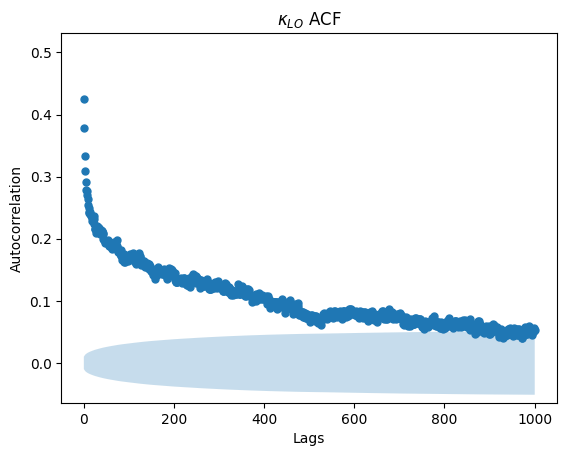

In [88]:
sm.graphics.tsa.plot_acf(np.log(data['q_LO'].dropna().values), lags=1000, zero=False, use_vlines = False,auto_ylims=True)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('$\\kappa_{LO}$ ACF')
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/CHTR_q_LO_acf.png")

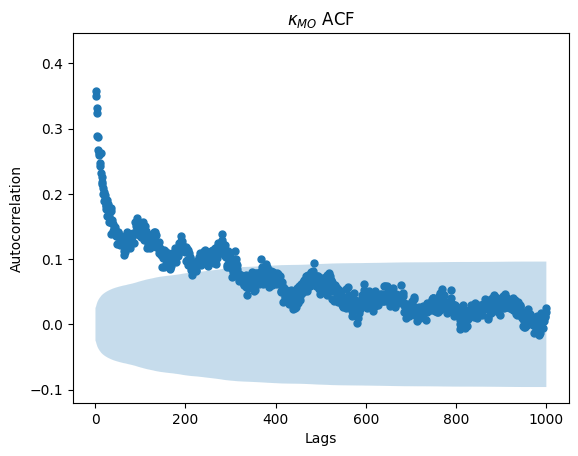

In [89]:
sm.graphics.tsa.plot_acf(np.log(data['q_MO'].dropna().values), lags=1000, zero=False, use_vlines = False,auto_ylims=True)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('$\\kappa_{MO}$ ACF')
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/CHTR_q_MO_acf.png")
plt.show()

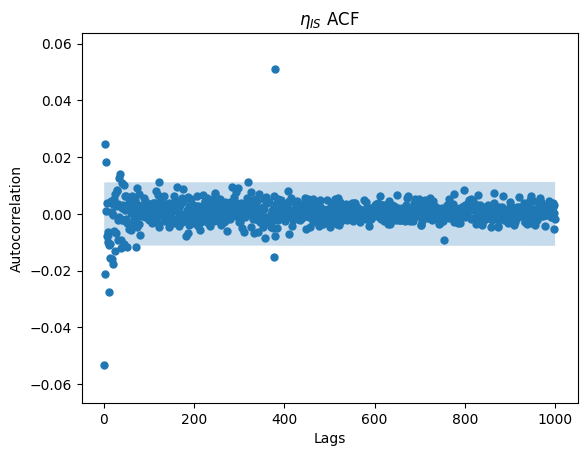

In [90]:
sm.graphics.tsa.plot_acf(data['eta_is'].dropna().values, lags=1000, zero=False, use_vlines = False,auto_ylims=True)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('$\\eta_{IS}$ ACF')
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/CHTR_eta_IS_acf.png")
plt.show()

In [53]:
with open('/SAN/fca/Konark_PhD_Experiments/simulated/smallTick/demo_tickness_avgSpr_beta_0.5_0.55', 'rb') as f:
    sim = pickle.load(f)

In [64]:
simDf = pd.DataFrame(sim[1])

In [65]:
simDf['e'] = np.append([''] , np.array(sim[0][1:])[:,0])

In [66]:
simDf['q_LO']

mid        Ask_touch         Bid_touch  Ask_m_T  Ask_m_D  Bid_m_T  \
0       1700.00     (1700.55, 2)     (1699.45, 10)     11.0      3.0     10.0   
1       1699.95     (1700.55, 2)   (1699.35, 36.0)     11.0      3.0      1.0   
2       1699.96     (1700.55, 2)     (1699.36, 32)     11.0      3.0      1.0   
3       1699.96     (1700.55, 2)      (1699.37, 9)     11.0      3.0      1.0   
4       1699.96     (1700.55, 2)     (1699.38, 40)     11.0      3.0      1.0   
...         ...              ...               ...      ...      ...      ...   
313995  1696.72  (1696.76, 69.0)  (1696.67, 190.0)      1.0     25.0      1.0   
313996  1696.72  (1696.76, 69.0)  (1696.67, 190.0)      1.0     25.0      1.0   
313997  1696.72  (1696.76, 80.0)  (1696.67, 190.0)      1.0     25.0      1.0   
313998  1696.71    (1696.75, 15)  (1696.67, 190.0)      1.0     26.0      1.0   
313999  1696.71    (1696.75, 15)  (1696.67, 190.0)      1.0     26.0      1.0   

        Bid_m_D                   Ask_deep                  Bid_deep  \
0           1.0  (1700.6599999999999, 168)  (1699.3500000000001, 36)   
1           1.0             (1700.66, 168)             (1699.34, 36)   
2           1.0             (1700.66, 168)           (1699.35, 36.0)   
3           1.0             (1700.66, 168)           (1699.36, 32.0)   
4           1.0             (1700.66, 168)            (1699.37, 9.0)   
...         ...                        ...                       ...   
313995     28.0          (1696.77, 3788.0)         (1696.66, 5371.0)   
313996     28.0          (1696.77, 3787.0)         (1696.66, 5371.0)   
313997     28.0          (1696.77, 3787.0)         (1696.66, 5371.0)   
313998     28.0          (1696.76, 3867.0)         (1696.66, 5371.0)   
313999     28.0          (1696.76, 3823.0)         (1696.66, 5371.0)   

                      e  
0                        
1            co_top_Bid  
2       lo_inspread_Bid  
3       lo_inspread_Bid  
4       lo_inspread_Bid  
...                 ...  
313995      co_deep_Ask  
313996      co_deep_Ask  
313997       lo_top_Ask  
313998  lo_inspread_Ask  
313999      co_deep_Ask  

[314000 rows x 10 columns]

In [69]:
simDf['q_LO'] =simDf['Ask_touch'].apply(lambda x: x[1]).diff()

(array([5.389e+03, 1.597e+03, 7.170e+02, 1.398e+03, 6.580e+02, 1.610e+03,
        1.106e+03, 4.580e+02, 8.510e+02, 3.930e+02, 7.660e+02, 7.000e+02,
        2.770e+02, 5.710e+02, 2.830e+02, 4.870e+02, 4.250e+02, 2.030e+02,
        3.760e+02, 1.980e+02, 3.060e+02, 1.620e+02, 2.690e+02, 2.490e+02,
        1.060e+02, 2.030e+02, 8.300e+01, 1.840e+02, 1.690e+02, 7.000e+01,
        5.150e+02, 6.200e+01, 8.700e+01, 1.130e+02, 5.200e+01, 9.900e+01,
        4.100e+01, 6.500e+01, 7.800e+01, 2.900e+01, 4.900e+01, 2.200e+01,
        5.000e+01, 1.600e+01, 3.400e+01, 3.200e+01, 1.600e+01, 2.700e+01,
        1.200e+01, 2.900e+01, 2.600e+01, 9.000e+00, 1.800e+01, 1.000e+01,
        2.400e+01, 1.600e+01, 5.000e+00, 1.800e+01, 2.000e+00, 6.000e+00,
        5.000e+00, 7.000e+00, 8.051e+03, 3.000e+00, 8.000e+00, 3.000e+00,
        5.000e+00, 8.000e+00, 3.000e+00, 8.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 2.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 5.000e+00,
        0.000e+00, 1.000e+00, 2.000e+0

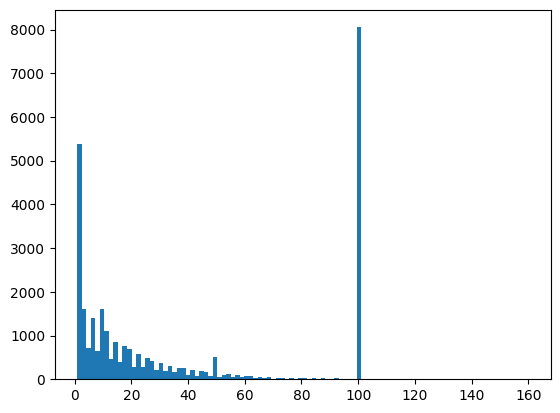

In [77]:
plt.hist(simDf.loc[(simDf.e == 'lo_top_Ask')&(simDf.q_LO > 0 )]['q_LO'].values, bins =100)

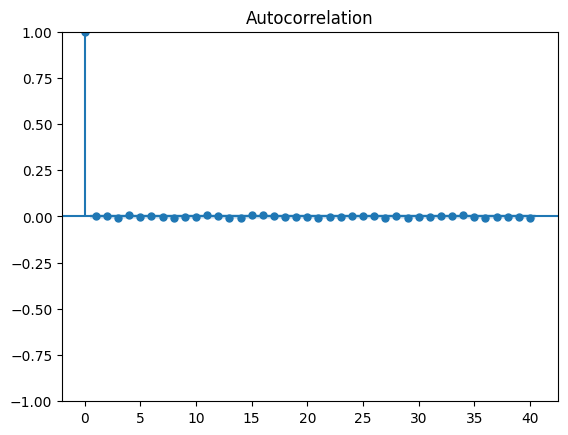

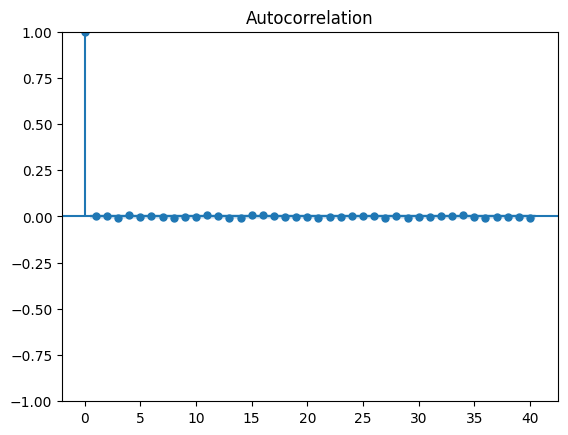

In [76]:
sm.graphics.tsa.plot_acf(np.log(simDf.loc[(simDf.e == 'lo_top_Ask')&(simDf.q_LO > 0 )]['q_LO'].values), lags=40)

## Intensity vs state variables boxplots

In [3]:
for s in ['AMZN']:
    try:
        with open("/SAN/fca/Konark_PhD_Experiments/smallTick/"+s+"_EDA_percentisecDF", 'rb') as f:
            res = pickle.load(f)
    except:
        continue
    

In [132]:
with open("/SAN/fca/Konark_PhD_Experiments/extracted/AAPL.OQ_ParamsInferredWCutoff_2019-01-02_2019-03-31_poisson", "rb") as f:
        data=pickle.load(f)

In [4]:
res = pd.read_csv("D:\\PhD\\results - small tick\\AMZN_EDA_persecDF.csv")

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\konar\AppData\Local\Temp\ipykernel_27956\751364955.py:1: SyntaxWarning: invalid escape sequence '\P'
  res = pd.read_csv("D:\PhD\\results - small tick\AMZN_EDA_persecDF.csv")


In [6]:
res.reset_index(inplace=True)

In [33]:
res_lo = res.loc[(res['Type']==1)&(res['TradeDirection']==1)]

In [34]:
res_lo['m_T_Ask'].values

array([list([53.0]), list([95.0]), list([88.0]), ...,
       list([10.0, 12.0, 5.0]), list([10.0, 1.0]), list([43.0])],
      dtype=object)

In [35]:
m_T = np.hstack([x for x in res_lo['m_T_Ask'].values])
intensity = np.hstack([x for x in res_lo['Time'].values])

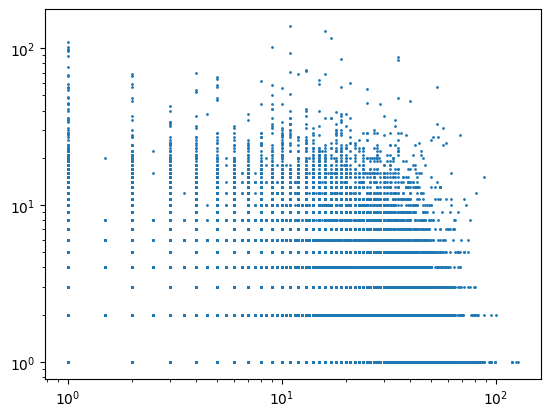

In [36]:
plt.scatter(m_T, intensity, s=1)
plt.xscale('log')
plt.yscale('log')

<Axes: xlabel='m_T'>

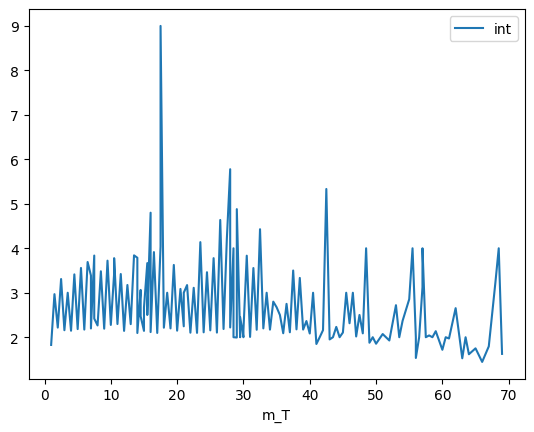

In [37]:
df = pd.DataFrame({'m_T':m_T,'int': intensity}).groupby('m_T').count()
df = df/df.sum()
m_Tmax = np.max(df[df['int']>1e-4].index)
df = pd.DataFrame({'m_T':m_T,'int': intensity})
df = df.loc[df.m_T <= m_Tmax ]
df.groupby('m_T').mean().plot()

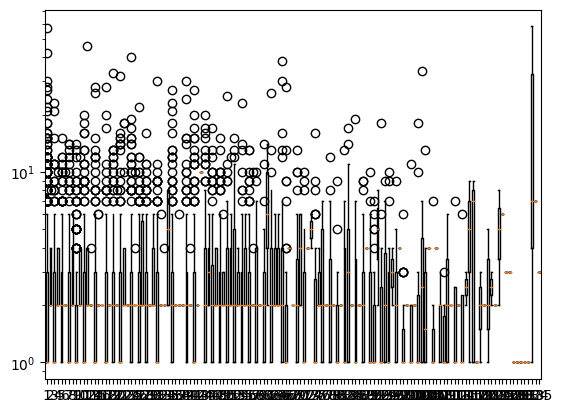

In [29]:
plt.boxplot(df.groupby('m_T')['int'].apply(np.array))
plt.yscale('log')

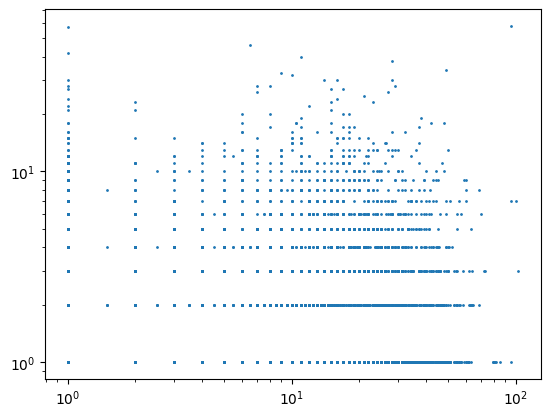

In [31]:
m_T_a = np.hstack([x for x in res_lo['m_T_Ask'].values])
plt.scatter(m_T_a, intensity, s=1)
plt.xscale('log')
plt.yscale('log')

<Axes: xlabel='m_T'>

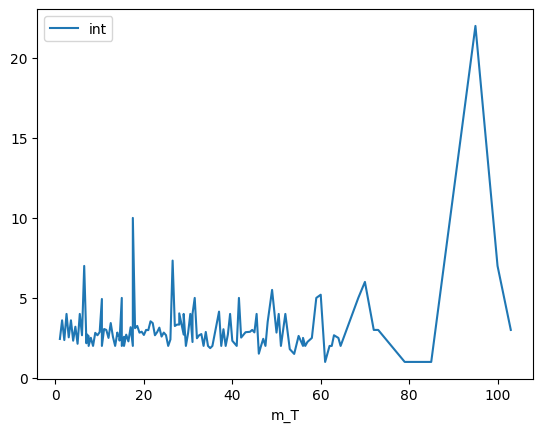

In [32]:
df = pd.DataFrame({'m_T':m_T_a,'int': intensity}).groupby('m_T').count()
df = df/df.sum()
m_Tmax = np.max(df[df['int']>1e-4].index)
df = pd.DataFrame({'m_T':m_T_a,'int': intensity})
df = df.loc[df.m_T <= m_Tmax ]
df.groupby('m_T').mean().plot()

In [47]:
# AR q_LO

In [48]:
res = pd.read_csv("D:\\PhD\\results - small tick\\TSLA_2019-05-16_12D.csv")

C:\Users\konar\AppData\Local\Temp\ipykernel_27956\2837418046.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  res = pd.read_csv("D:\\PhD\\results - small tick\\TSLA_2019-05-16_12D.csv")


In [51]:
x = res.loc[res['event'] == 'lo_top_Ask'].Size.values

In [52]:
from statsmodels.tsa.ar_model import AutoReg

In [54]:
res = AutoReg(x, lags = 10).fit()

In [55]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                11648
Model:                    AutoReg(10)   Log Likelihood              -65445.130
Method:               Conditional MLE   S.D. of innovations             66.985
Date:                Thu, 22 Aug 2024   AIC                         130914.260
Time:                        18:15:37   BIC                         131002.604
Sample:                            10   HQIC                        130943.940
                                11648                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.0670      1.831     25.711      0.000      43.479      50.655
y.L1           0.0666      0.009      7.189      0.000       0.048       0.085
y.L2           0.0553      0.009      5.960      0.000       0.037       0.074
y.L3           0.0668      0.009      7.181      0.000       0.049       0.085
y.L4           0.0409      0.009      4.391      0.000       0.023       0.059
y.L5           0.0223      0.009      2.389      0.017       0.004       0.041
y.L6           0.0296      0.009      3.182      0.001       0.011       0.048
y.L7           0.0379      0.009      4.072      0.000       0.020       0.056
y.L8           0.0290      0.009      3.122      0.002       0.011       0.047
y.L9           0.0213      0.009      2.292      0.022       0.003       0.039
y.L10          0.0187      0.009      2.023      0.043       0.001       0.037
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.2020           -0.0000j            1.2020           -0.0000
AR.2             1.0662           -0.9299j            1.4147           -0.1141
AR.3             1.0662           +0.9299j            1.4147            0.1141
AR.4             0.3530           -1.5251j            1.5654           -0.2138
AR.5             0.3530           +1.5251j            1.5654            0.2138
AR.6            -0.5090           -1.4404j            1.5277           -0.3041
AR.7            -0.5090           +1.4404j            1.5277            0.3041
AR.8            -1.5839           -0.0000j            1.5839           -0.5000
AR.9            -1.2870           -0.8899j            1.5648           -0.4037
AR.10           -1.2870           +0.8899j            1.5648            0.4037
------------------------------------------------------------------------------
"""

In [63]:
data = np.log(x)
n = len(data)
ntrain = int(n*0.9)
ntest = n - ntrain
lag = 500
res = AutoReg(data[:ntrain], lags = lag).fit()

In [64]:
preds = res.model.predict(res.params, start=n-ntest, end=n)

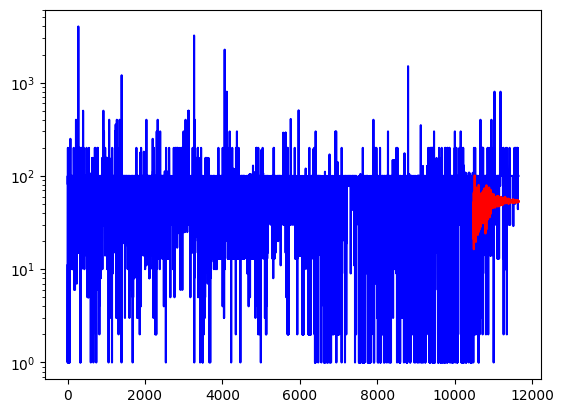

In [66]:
plt.plot(np.arange(n), x, color = 'b')
plt.plot(np.arange(n - len(preds), n), np.exp(preds), color='r')
plt.yscale('log')

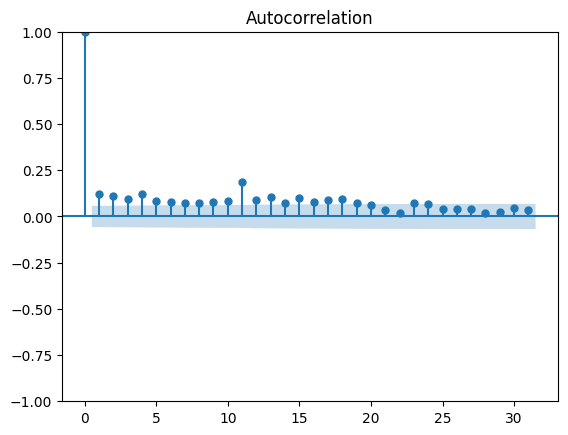

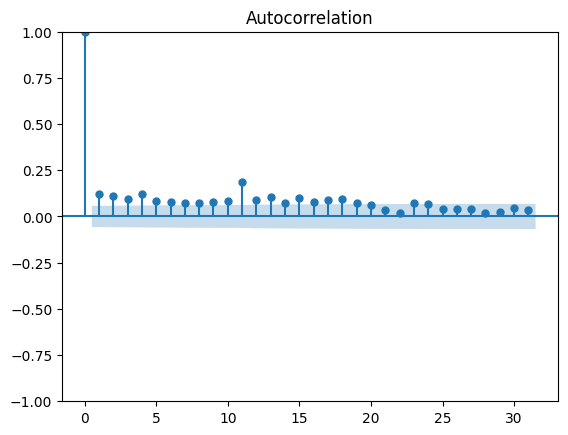

In [74]:
sm.graphics.tsa.plot_acf(np.exp(data[ntrain-1:]) - np.exp(preds))

# Phase Diagrams

In [5]:
path = '/SAN/fca/Konark_PhD_Experiments/simulated/smallTick/is/'
fnames = os.listdir(path)    

In [6]:
spreads = []
labels = []
#fig, ax = plt.subplots()
for fname in fnames:
    if 'demo' in fname:
        with open(path+fname, 'rb') as f:
            T, lob = pickle.load(f)
        ask_t = []
        bid_t = []
        ask_d = []
        bid_d= []
        ask_m_D = []
        bid_m_D = []
        spread = []
        for r in lob:
            #ask_t.append(r['Ask_touch'][0])
            #bid_t.append(r['Bid_touch'][0])
            #ask_d.append(r['Ask_deep'][0])
            #bid_d.append(r['Bid_deep'][0])
            #bid_m_D.append(r['Bid_deep'][0] - 0.01*r['Bid_m_D'])
            #ask_m_D.append(r['Ask_deep'][0] + 0.01*r['Ask_m_D'])
            spread.append(100*(r['Ask_touch'][0] - r['Bid_touch'][0]))
        t = np.append([0], np.array(T[1:])[:,1])
        t = t.astype(float) + 9.5*3600
        
        
        
        count = int((max(t) - min(t))/10)
        spreads.append(spread)
        labels.append(fname.split('beta_')[-1])
#ax.ticklabel_format(useOffset=False)
#ax.set_xticks(ticks = np.arange(min(t), max(t), count), labels = [time.strftime('%H:%M:%S', time.gmtime(x)) for x in np.arange(min(t), max(t), count)], rotation = 20)
#plt.show()

demo_0.4_0.7
3.3542230023285216


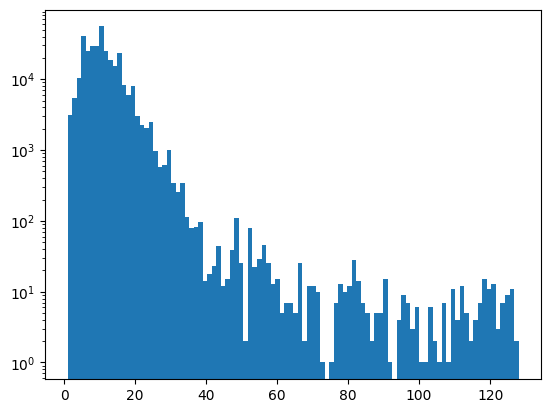

In [13]:
s = spreads[-1]
print(labels[-1])
print(np.mean(s)**2/np.var(s))
plt.hist(s, bins=100)
plt.yscale('log')

In [61]:
dict_res = {}
a , b, k = [] ,[ ],[]
for i in range(len(spreads)):
    s = spreads[i]
    l = labels[i]
    dict_res[l.split('demo_')[-1]] = (np.mean(s)**2/np.var(s), np.var(s)/np.mean(s))
    a += [float(l.split('_')[1])]
    b += [float(l.split('_')[2])]
    k+= [np.mean(s)**2/np.var(s)]

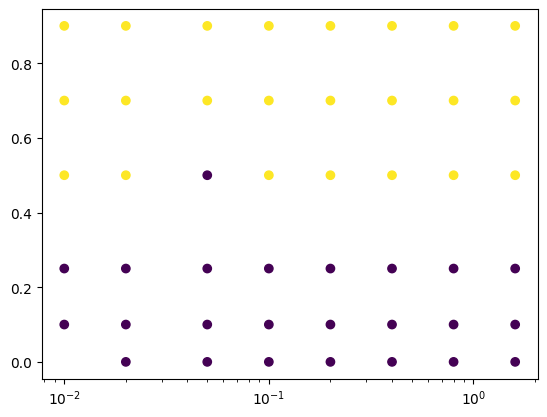

In [62]:
plt.scatter(a, b, c = np.array(k)>1.)
plt.xscale('log')

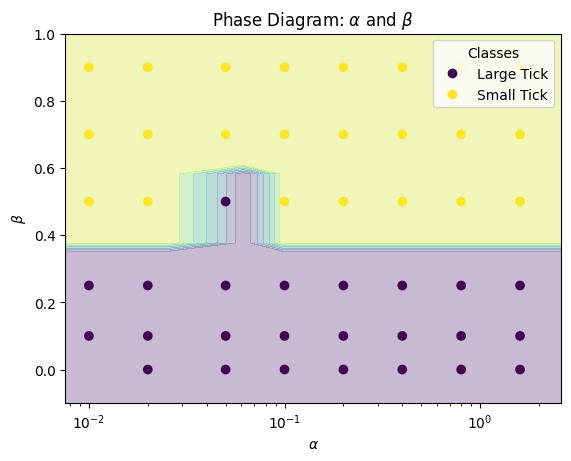

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
X, y = np.array([a, b]).transpose(), np.array(k)>1.
clf = DecisionTreeClassifier().fit(X, y)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, response_method="predict", alpha=0.3)
scatter=disp.ax_.scatter(X[:, 0], X[:, 1], c=y)
plt.xscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.ylim(-0.1, 1)
legend1 = plt.legend(*(scatter.legend_elements()[0],['Large Tick','Small Tick']),
                    loc="best", title="Classes")
plt.title('Phase Diagram: $\\alpha$ and $\\beta$')
plt.savefig(path + 'phaseDiag_is.png')
plt.show()

demo_0.05_0.9 (array([0]),)
demo_0.05_0.7 (array([0]),)
demo_0.01_0.9 (array([0]),)
demo_0.02_0.9 (array([0]),)
demo_0.01_0.5 (array([0]),)
demo_0.01_0.7 (array([0]),)
demo_0.02_0.5 (array([0]),)
demo_0.2_0.9 (array([3]),)
demo_0.02_0.25 (array([0]),)
demo_0.1_0.7 (array([0]),)
demo_0.02_0.7 (array([0]),)
demo_0.1_0.9 (array([0]),)
demo_0.4_0.9 (array([11]),)
demo_0.05_0.5 (array([0]),)
demo_1.6_0.9 (array([25]),)
demo_0.2_0.7 (array([0]),)
demo_0.01_0.25 (array([0]),)
demo_0.1_0.5 (array([0]),)
demo_0.2_0.5 (array([0]),)
demo_0.1_0.1 (array([0]),)
demo_0.1_0.0 (array([0]),)
demo_0.8_0.0 (array([0]),)
demo_0.1_0.25 (array([0]),)
demo_0.8_0.5 (array([4]),)
demo_0.01_0.1 (array([0]),)
demo_1.6_0.0 (array([0]),)
demo_1.6_0.1 (array([0]),)
demo_0.8_0.7 (array([11]),)
demo_0.05_0.0 (array([0]),)
demo_0.8_0.9 (array([12]),)
demo_1.6_0.7 (array([16]),)
demo_0.8_0.1 (array([0]),)
demo_0.4_0.0 (array([0]),)
demo_0.05_0.1 (array([0]),)
demo_0.4_0.25 (array([0]),)
demo_1.6_0.25 (array([0]),)
demo

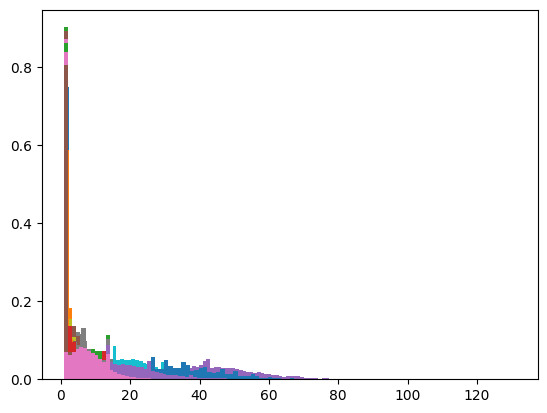

In [64]:
modes = {}
for i in range(len(spreads)):
    s = spreads[i]
    l = labels[i]
    n, b, patches = plt.hist(s, bins=100, density=True, histtype='stepfilled')

    bin_max = np.where(n == n.max())
    print(l, bin_max)
    modes[l.split('demo_')[-1]] = bin_max

In [ ]:
dict_shape_ = {}
volumes_1 , labels = [], [] 
for fname in fnames:
    if 'demo' in fname:
        # if  fname.split('_')[-1] not in ['5', '20', '50']:
        #     continue
        l = fname.split('demo_')[-1]
        with open(path+fname, 'rb') as f:
                T, lob = pickle.load(f)
        volumes = []
        for r in lob:
                volume = [(( - r['Bid_deep'][0] + r['mid']) + 0.01*i, r['Bid_deep'][1]/r['Bid_m_D']) for i in range(int(r['Bid_m_D']))]
                volume += [((-r['Bid_touch'][0] + r['mid']), r['Bid_touch'][1])]
                volume += [((r['Ask_touch'][0] - r['mid']), r['Ask_touch'][1])]
                volume += [((r['Ask_deep'][0] - r['mid']) + 0.01*i, r['Ask_deep'][1]/r['Ask_m_D']) for i in range(int(r['Ask_m_D']))]
                volumes += [volume]
        volumes_1.append(volumes)
        labels.append(l)
for volumes , label in zip(volumes_1, labels):
    dict_shape = {}
    for v in volumes:
        dists = np.array(v)[:,0]
        vols =  np.array(v)[:,1]
        for d, vol in zip(dists,vols):
            dict_shape[np.round(d, decimals=2)] = dict_shape.get(np.round(d, decimals=2), 0) + vol
    dist = np.sort(list(dict_shape.keys()))
    vol = np.array([dict_shape[d] for d in dist])
    vol = vol/vol.sum()
    dict_shape_[label] = vol

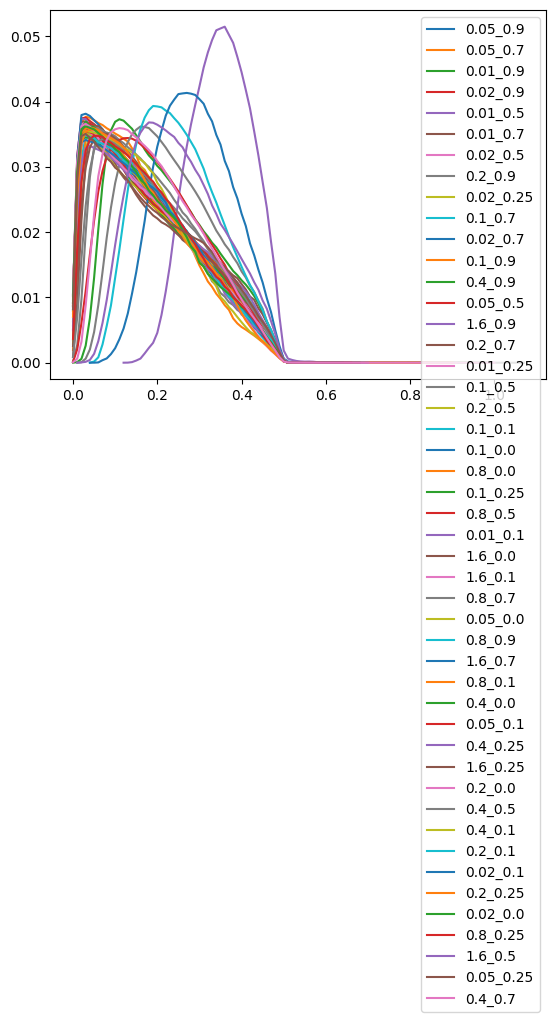

In [19]:
for fn in fnames:
    if 'shape' in fn:
        with open('/SAN/fca/Konark_PhD_Experiments/simulated/smallTick/is/'+fn, 'rb') as f:
            res = pickle.load(f)
        plt.plot(res[0],res[1], label = fn.split('shape_')[-1])
plt.legend()

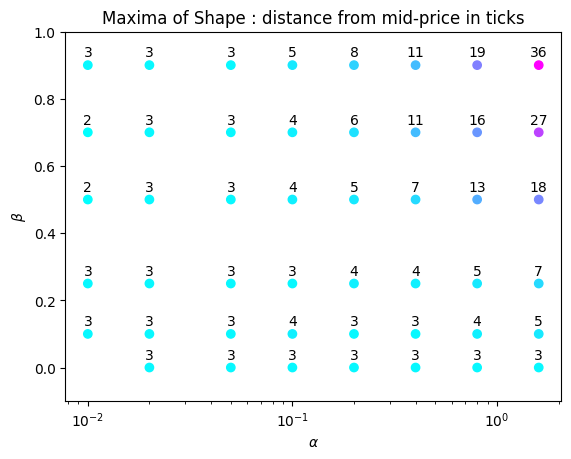

In [54]:
maxima, alpha, beta = [], [], []
for fn in fnames:
    if 'shape' in fn:
        with open('/SAN/fca/Konark_PhD_Experiments/simulated/smallTick/is/'+fn, 'rb') as f:
            res = pickle.load(f)
        maxima += [np.array(res[0])[np.array(res[1]) == np.array(res[1]).max()]]
        alpha += [float(fn.split('shape_')[-1].split('_')[0])]
        beta += [float(fn.split('shape_')[-1].split('_')[1])]
scatter = plt.scatter(alpha, beta, c = np.array(maxima)*100, label = np.array(maxima)*100, cmap = 'cool')
plt.xscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.ylim(-0.1, 1)
#plt.xlim(1e-3, 2)
#legend1 = plt.legend(*scatter.legend_elements(),
#                    loc="lower left", title="Shape Maxima (ticks)")
for a, b, c in zip(alpha, beta, maxima):
    plt.annotate(str(int(c[0]*100)), (a, b),xytext=(0, 4),textcoords='offset points', ha='center', va='bottom')
plt.title('Maxima of Shape : distance from mid-price in ticks')
plt.savefig(path + 'shapeMaxima_is.png')
plt.show()

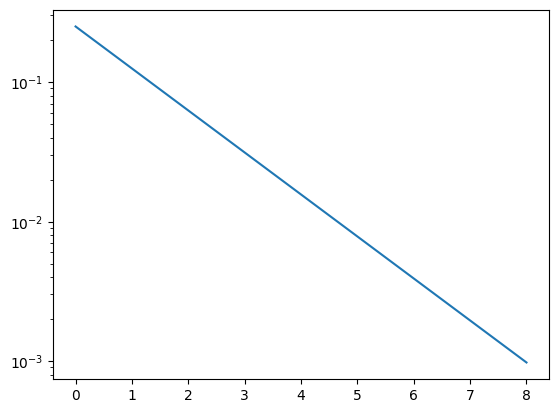

In [58]:
p = 0.5
plt.plot([p*(1-p)**k for k in range(1,10)])
plt.yscale('log')